In [1]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.dates as mdates
from scipy.optimize import minimize
import gc
import pylab
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import coint
from scipy.stats import t
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_cam = pd.read_csv("df_cam.csv", index_col=0)
df_cam.index = pd.to_datetime(df_cam.index)

C:\Users\Sebas\.conda\envs\CAMQUANT\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Sebas\.conda\envs\CAMQUANT\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Sebas\.conda\envs\CAMQUANT\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


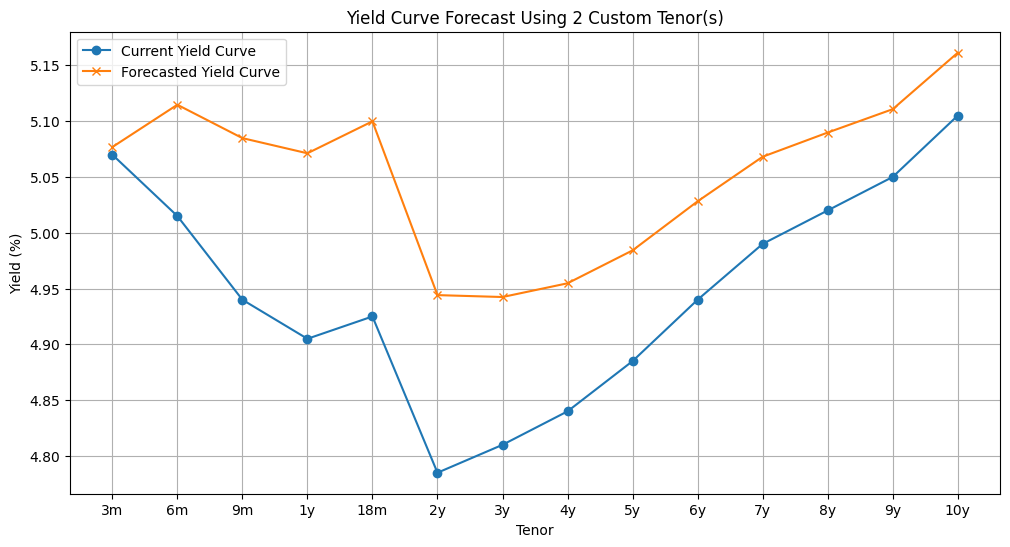

In [3]:
# USE PCA t forecast swap curve based on changes in 1, 2 or three datapoints

columns=['3m','6m','9m','1y','18m','2y','3y','4y','5y','6y','7y','8y','9y','10y']
datapoints = 250
days_change = 5
df_tenors = df_cam[columns].tail(datapoints)


# Calculate yield changes
yield_changes = df_tenors.diff(days_change).dropna()

# PCA
pca = PCA()
pca.fit(yield_changes)

# Principal components and explained variance
pc_scores = pca.transform(yield_changes)
explained_variance = pca.explained_variance_ratio_


def forecast_yield_curve_with_top3_components(selected_tenors, new_values):
    """
    Forecast the yield curve using PCA and specified new values for custom tenors,
    using only the top 3 principal components.
    
    Args:
        selected_tenors (list): List of tenors to use (e.g., ["1y", "5y", "10y"]).
        new_values (list): List of new yield values for the selected tenors.
    
    Returns:
        pd.Series: Forecasted yield curve.
    """
    if len(selected_tenors) != len(new_values):
        raise ValueError("Number of selected tenors must match the number of new values.")
    if len(selected_tenors) < 1 or len(selected_tenors) > 3:
        raise ValueError("You must select between 1 and 3 tenors.")

    # Calculate the changes based on the last observed yields
    last_values = df_tenors.iloc[-1][selected_tenors].values
    future_changes = np.array(new_values) - last_values

    # Use the selected tenors for regression
    X_selected = yield_changes[selected_tenors]
    models = [LinearRegression().fit(X_selected, pca.transform(yield_changes)[:, i]) for i in range(3)]  # Top 3 components

    # Predict principal components using the calculated changes
    future_changes = future_changes.reshape(1, -1)  # Reshape to match model input
    forecasted_pcs = np.array([model.predict(future_changes)[0] for model in models])

    # Extend to match all components (fill higher-order components with zeros)
    full_pcs = np.zeros(pca.n_components_)
    full_pcs[:3] = forecasted_pcs  # Use only the top 3 components

    # Reconstruct the yield curve using the top 3 components
    forecasted_yield_changes = pca.inverse_transform(full_pcs.reshape(1, -1))
    forecasted_yield_curve = df_tenors.iloc[-1] + forecasted_yield_changes[0]  # Add to last observed curve

    return pd.Series(forecasted_yield_curve, index=df_cam[columns].columns)

# Test the updated function
selected_tenors = ["2y","5y"]  # Choose tenors
new_values = [4.95,4.98]  # New yield values for the selected tenors

forecasted_curve = forecast_yield_curve_with_top3_components(selected_tenors, new_values)

# Plot the current and forecasted yield curves
plt.figure(figsize=(12, 6))
plt.plot(df_tenors.columns, df_tenors.iloc[-1], label="Current Yield Curve", marker="o")
plt.plot(df_tenors.columns, forecasted_curve, label="Forecasted Yield Curve", marker="x")
plt.xlabel("Tenor")
plt.ylabel("Yield (%)")
plt.title(f"Yield Curve Forecast Using {len(selected_tenors)} Custom Tenor(s)")
plt.legend()
plt.grid()
plt.show()

In [4]:
forecasted_curve

3m     5.076750
6m     5.114691
9m     5.084800
1y     5.071206
18m    5.099836
2y     4.944130
3y     4.942421
4y     4.954724
5y     4.984215
6y     5.028169
7y     5.068119
8y     5.089783
9y     5.110726
10y    5.161307
Name: 2024-12-06 00:00:00, dtype: float64

In [157]:
df_tenors.iloc[-1]

3m     5.070
6m     5.015
9m     4.940
1y     4.905
18m    4.925
2y     4.785
3y     4.810
4y     4.840
5y     4.885
6y     4.940
7y     4.990
8y     5.020
9y     5.050
10y    5.105
Name: 2024-12-06 00:00:00, dtype: float64

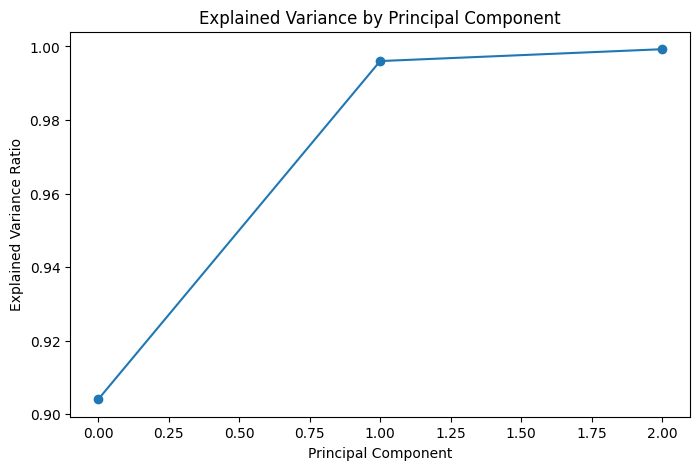

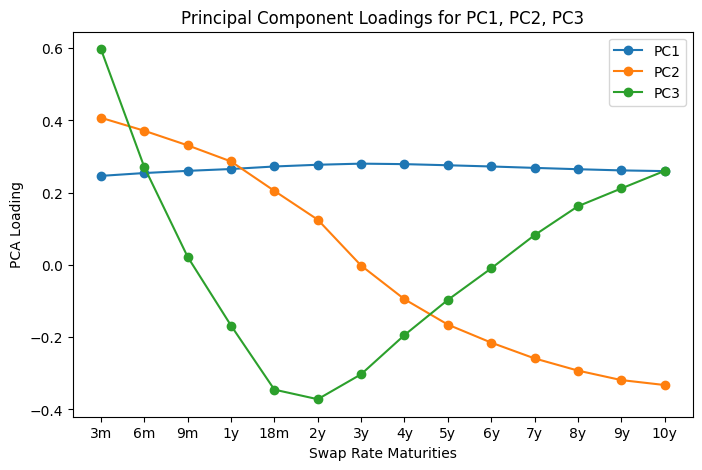

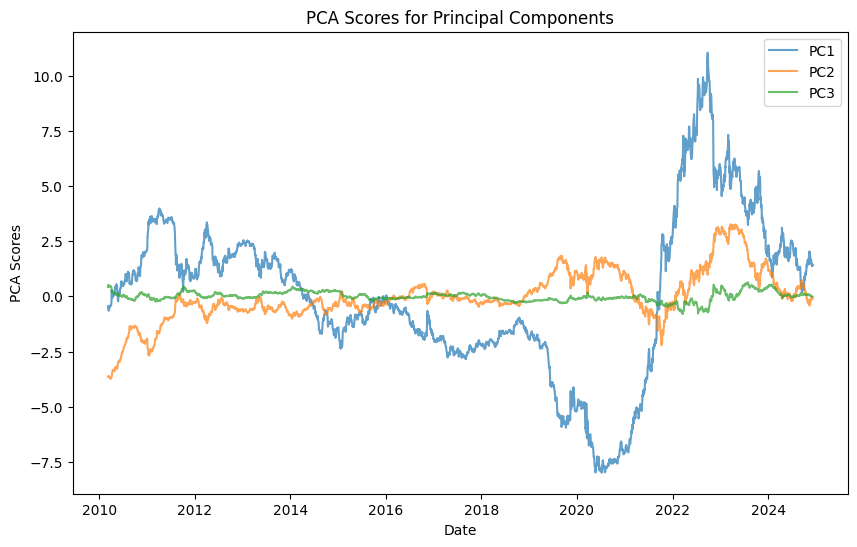

In [10]:

#columns = ['3m3m','6m3m','9m3m','1y6m','18m6m','1y1y','2y1y','3y1y','4y1y','2y2y','3y2y','5y2y','7y3y','5y5y']
columns =  ['3m','6m','9m','1y','18m','2y','3y','4y','5y','6y','7y','8y','9y','10y']
#columns =  ['2y','3y','4y','5y','6y','7y','8y','9y','10y']
#columns = ['3m3m','6m6m','1y1y','2y1y','3y1y','4y1y','5y1y','6y1y','7y1y','8y1y','9y1y']
#df_cam.loc['2010-03-09':,'Date']
start_date,end_date = ['2010-03-09','2024-12-06']
x_scaled = StandardScaler().fit_transform(df_cam.loc[start_date:end_date,columns].dropna())

pca = PCA(n_components=3)#n_components=14
pca = pca.fit(x_scaled)

df_cam['Date'] = df_cam.index

# Extract loadings for Exhibit 5
loadings_original = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2)", "PC3"],
    index=columns)

# Plot explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance by Principal Component")
plt.show()

# Plot the first three principal component loadings
plt.figure(figsize=(8, 5))
for i, pc in enumerate(pca.components_[:3], start=1):
    plt.plot(columns, pc, marker='o', label=f'PC{i}')
plt.xlabel("Swap Rate Maturities")
plt.ylabel("PCA Loading")
plt.title("Principal Component Loadings for PC1, PC2, PC3")
plt.legend(loc='upper right')
plt.show()


# Transform the data using PCA and plot
x_pca_transformed =pca.transform(x_scaled)

plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(df_cam.loc[start_date:end_date,'Date'], x_pca_transformed[:, i], alpha=0.7, label=f'PC{i+1}')
plt.xlabel("Date")
plt.ylabel("PCA Scores")
plt.title("PCA Scores for Principal Components")
plt.legend(loc='upper right')
plt.show()

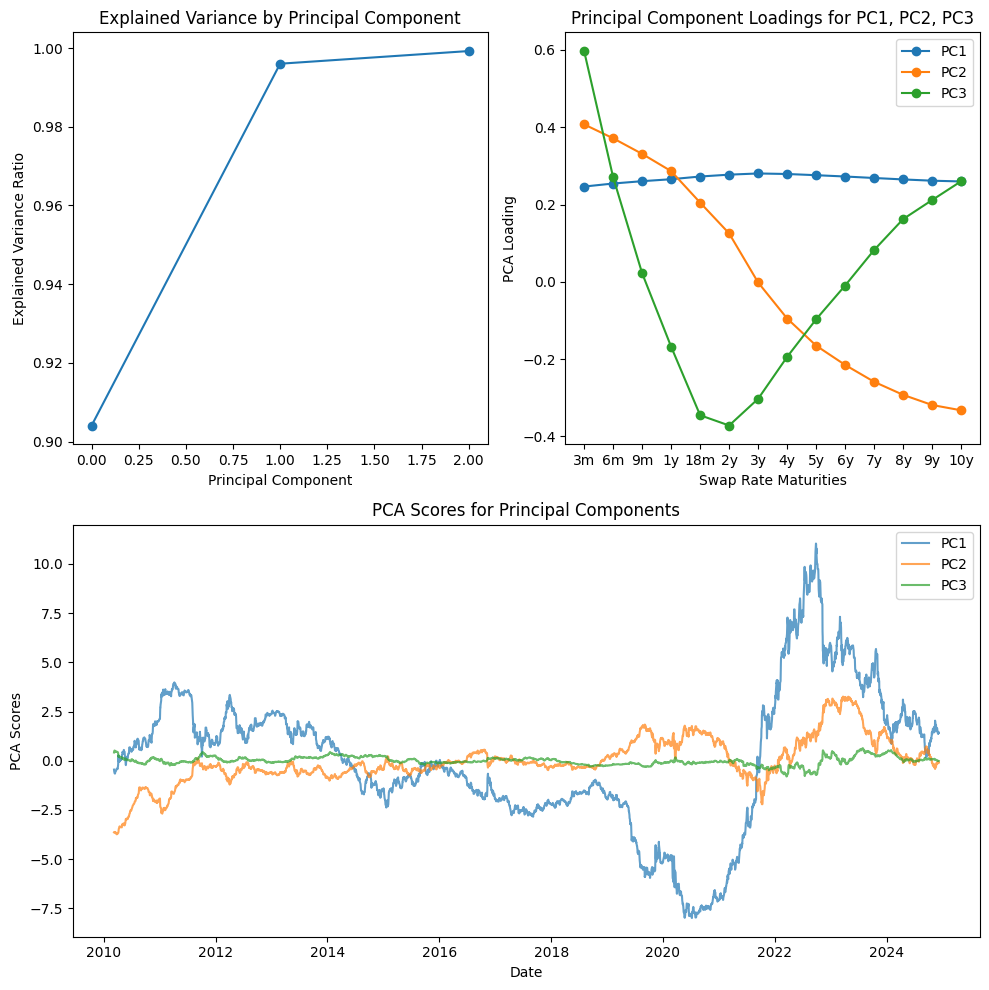

In [11]:


# Create a figure and GridSpec
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2, height_ratios=[1, 1])  # 2 rows, 2 columns

# First plot (top-left)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(pca.explained_variance_ratio_.cumsum(), marker='o')
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance Ratio")
ax1.set_title("Explained Variance by Principal Component")

# Second plot (top-right)
ax2 = fig.add_subplot(gs[0, 1])
for i, pc in enumerate(pca.components_[:3], start=1):
    ax2.plot(columns, pc, marker='o', label=f'PC{i}')
ax2.set_xlabel("Swap Rate Maturities")
ax2.set_ylabel("PCA Loading")
ax2.set_title("Principal Component Loadings for PC1, PC2, PC3")
ax2.legend(loc='upper right')

# Third plot (bottom, spanning both columns)
ax3 = fig.add_subplot(gs[1, :])  # This spans both columns in the second row
for i in range(3):
    ax3.plot(df_cam.loc[start_date:end_date, 'Date'], x_pca_transformed[:, i], alpha=0.7, label=f'PC{i+1}')
ax3.set_xlabel("Date")
ax3.set_ylabel("PCA Scores")
ax3.set_title("PCA Scores for Principal Components")
ax3.legend(loc='upper right')

# Adjust layout and show
plt.tight_layout()
plt.show()



In [28]:
#Generate regressions sklearn diff change
data_points = 2500
factor1 = '5y' #X
factor2 = '3s5s10s' #y

X =df_cam[factor1].diff(5).tail(data_points)
y = df_cam[factor2].diff(5).tail(data_points)
X = X.values.reshape(-1,1)
model = lm.LinearRegression()
results = model.fit(X,y)
y_pred = model.predict(X)
df_pred = pd.DataFrame({'Actual': y, 'Predicted': y_pred})
df_pred.index = df_cam.tail(data_points).index
df_pred['Residuals']  =df_pred['Actual'] - model.predict(X)
#print(model.intercept_,model.coef_)
print('Beta :',model.coef_.item())
print('R^2 :',model.score(X, y))
df_pred



Beta : 0.12956333407161583
R^2 : 0.1598263447452366


Actual  Predicted  Residuals
Date                                    
2015-05-01   0.020   0.003805   0.016195
2015-05-04   0.000   0.006396  -0.006396
2015-05-05   0.030   0.014170   0.015830
2015-05-06   0.050   0.020648   0.029352
2015-05-07   0.020   0.016761   0.003239
...            ...        ...        ...
2024-12-02   0.005  -0.016278   0.021278
2024-12-03   0.000  -0.013038   0.013038
2024-12-04   0.005  -0.004617   0.009617
2024-12-05   0.005  -0.001378   0.006378
2024-12-06   0.000   0.000566  -0.000566

[2500 rows x 3 columns]

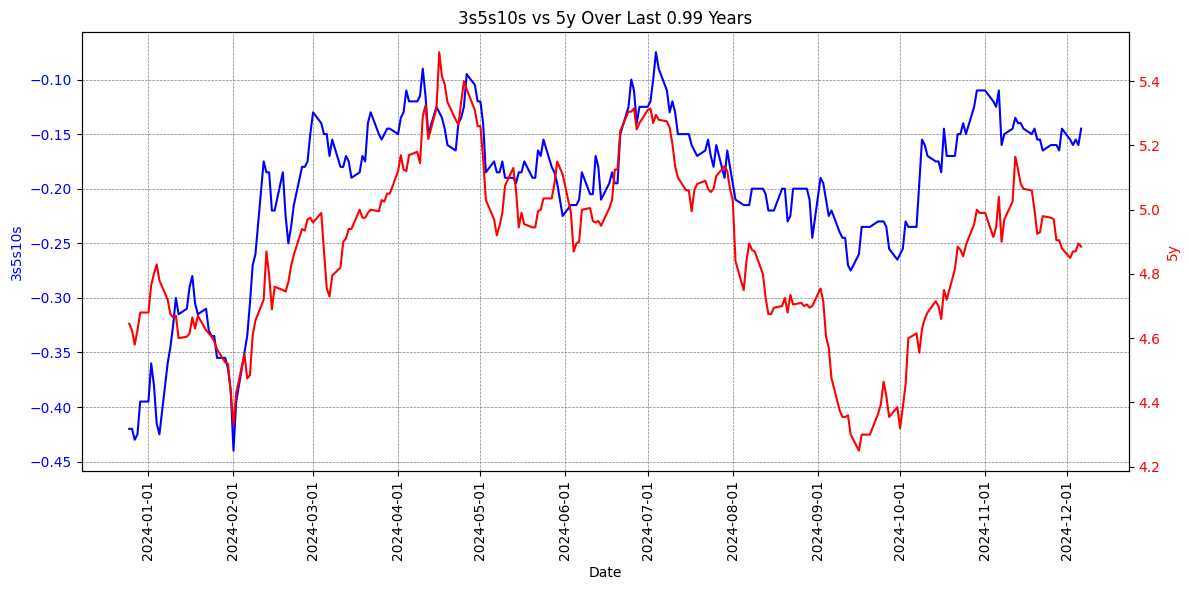

In [12]:
data_points = 250
factor1 = '5y' #X
factor2 = '3s5s10s' #y


# Plotting with vertical x-axis labels
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis for 3s5s10s
ax1.plot(df_cam.tail(data_points).index, df_cam[factor2].tail(data_points).values, color='blue', label=factor2)
ax1.set_ylabel(factor2, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Secondary y-axis for 5y
ax2 = ax1.twinx()
ax2.plot(df_cam.tail(data_points).index,df_cam[factor1].tail(data_points).values, color='red', label=factor1)
ax2.set_ylabel(factor1, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# X-axis settings with date formatting
ax1.set_xlabel('Date')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as yyyy-mm-dd
ax1.xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks at monthly intervals

# Rotate x-axis labels explicitly at 90 degrees
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)

# Add major gridlines
ax1.grid(which='major', linestyle='--', linewidth=0.5, color='gray')

# Title and layout
plt.title(f'{factor2} vs {factor1} Over Last {np.round(data_points/252,2)} Years')
plt.tight_layout()
plt.show()

In [10]:

df_cam.loc['2010-03-09':,'Date']

Date
2010-03-09   2010-03-09
2010-03-10   2010-03-10
2010-03-11   2010-03-11
2010-03-12   2010-03-12
2010-03-15   2010-03-15
                ...    
2024-12-02   2024-12-02
2024-12-03   2024-12-03
2024-12-04   2024-12-04
2024-12-05   2024-12-05
2024-12-06   2024-12-06
Name: Date, Length: 3843, dtype: datetime64[ns]

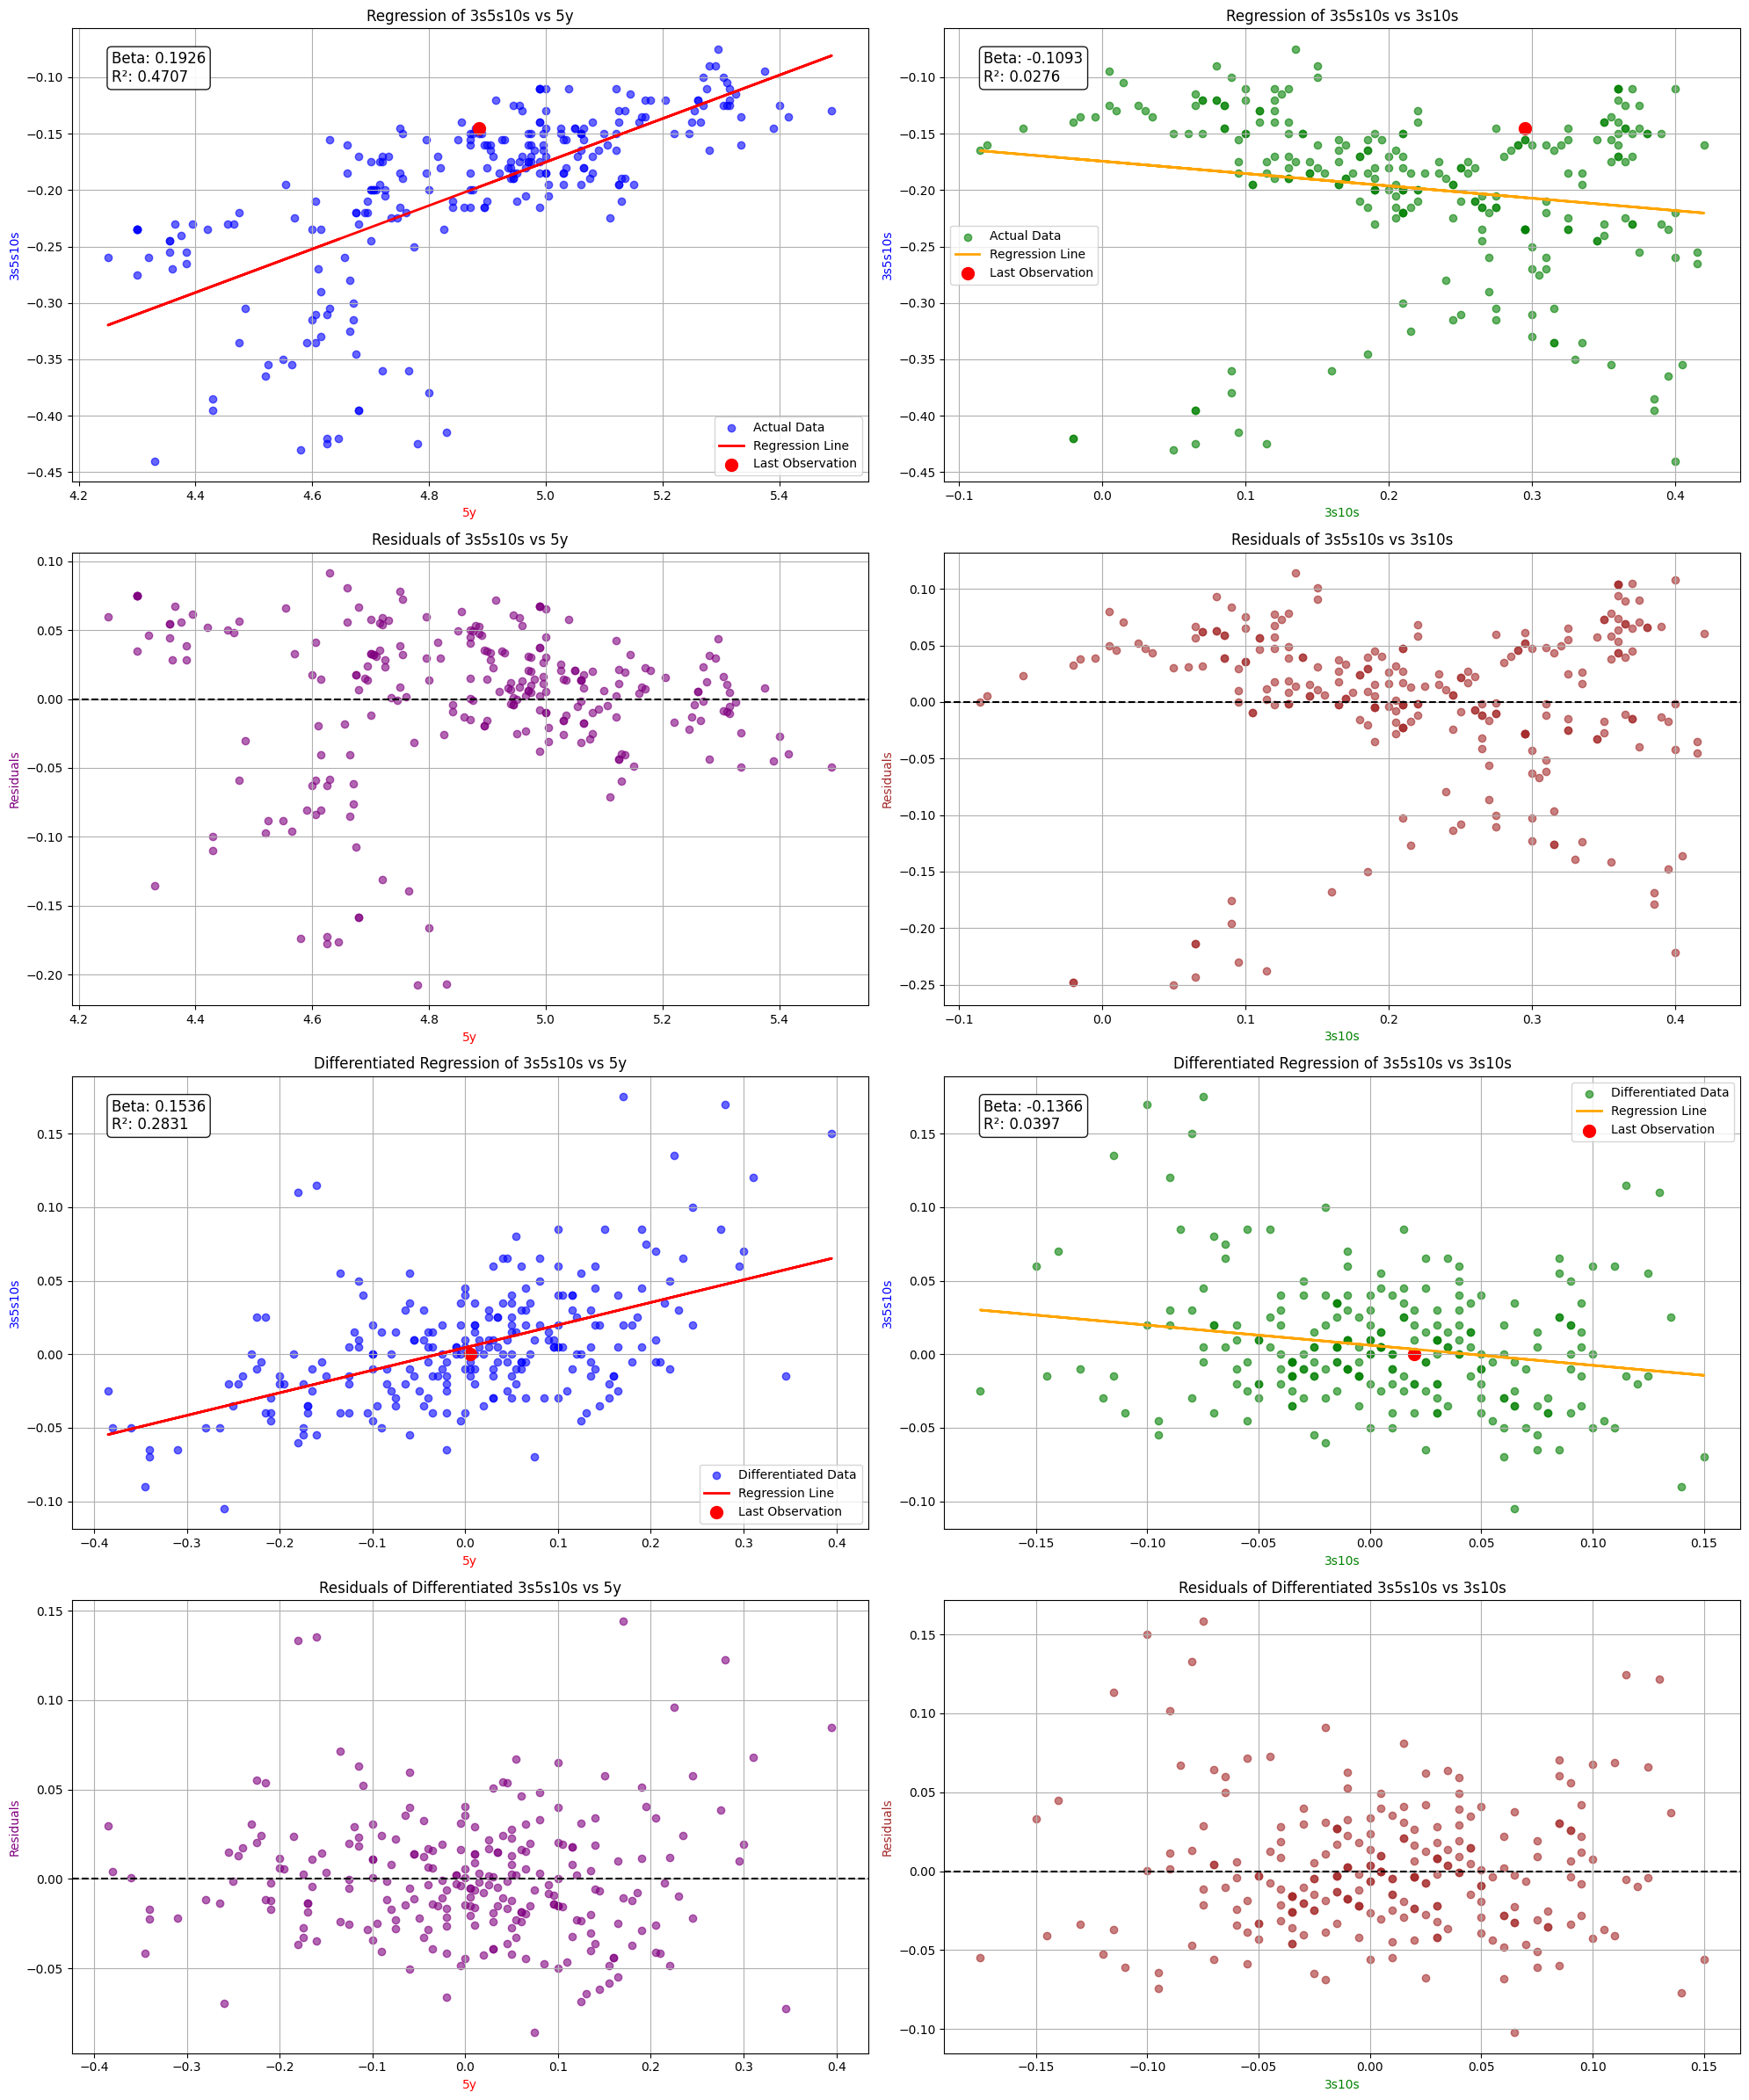

In [13]:
#Run regression between outright factors and plot residuals. Add regression vs changes and plot residuals

data_points = 250
# Define the factors
factor1 = '5y'  # Independent variable (X-axis, first regression)
factor2 = '3s5s10s'  # Dependent variable (Y-axis, both regressions)
factor3 = '3s10s'  # Independent variable (X-axis, second regression)
n_d = 5


# Variables for the first regression: 5y vs 3s5s10s
x1 = df_cam[factor1].tail(data_points).values.reshape(-1, 1)  # Independent variable (5y)
y1 = df_cam[factor2].tail(data_points).values  # Dependent variable (3s5s10s)

# Perform the first regression
model1 = LinearRegression()
model1.fit(x1, y1)

# Generate regression line and residuals for the first plot
y_pred1 = model1.predict(x1)
residuals1 = y1 - y_pred1

# Variables for the second regression: 3s10s vs 3s5s10s
x2 = df_cam[factor3].tail(data_points).values.reshape(-1, 1)  # Independent variable (3s10s)
y2 = df_cam[factor2].tail(data_points).values  # Dependent variable (3s5s10s)

# Perform the second regression
model2 = LinearRegression()
model2.fit(x2, y2)

# Generate regression line and residuals for the second plot
y_pred2 = model2.predict(x2)
residuals2 = y2 - y_pred2




# Define variables for differentiated regressions
x1_diff = df_cam[factor1].diff(n_d).tail(data_points).values.reshape(-1, 1)  # Independent variable for first differentiated regression
y1_diff = df_cam[factor2].diff(n_d).tail(data_points).values  # Dependent variable for first differentiated regression

x2_diff = df_cam[factor3].diff(n_d).tail(data_points).values.reshape(-1, 1)  # Independent variable for second differentiated regression
y2_diff = df_cam[factor2].diff(n_d).tail(data_points).values  # Dependent variable for second differentiated regression

# First differentiated regression
model1_diff = LinearRegression()
model1_diff.fit(x1_diff, y1_diff)
y_pred1_diff = model1_diff.predict(x1_diff)
residuals1_diff = y1_diff - y_pred1_diff

# Second differentiated regression
model2_diff = LinearRegression()
model2_diff.fit(x2_diff, y2_diff)
y_pred2_diff = model2_diff.predict(x2_diff)
residuals2_diff = y2_diff - y_pred2_diff

# Plotting the four regressions with residuals and differentiated data
fig, axes = plt.subplots(4, 2, figsize=(20, 24))

# Original data plots
# First plot: 5y vs 3s5s10s
axes[0, 0].scatter(x1, y1, color='blue', label='Actual Data', alpha=0.6)
axes[0, 0].plot(x1, y_pred1, color='red', label='Regression Line', linewidth=2)
axes[0, 0].scatter(x1[-1], y1[-1], color='red', s=100, label='Last Observation')
axes[0, 0].set_xlabel(factor1, color='red')
axes[0, 0].set_ylabel(factor2, color='blue')
axes[0, 0].set_title(f'Regression of {factor2} vs {factor1}')
axes[0, 0].grid()
axes[0, 0].legend()

# Residual plot for the first regression
axes[1, 0].scatter(x1, residuals1, color='purple', alpha=0.6)
axes[1, 0].axhline(0, color='black', linestyle='--')
axes[1, 0].set_xlabel(factor1, color='red')
axes[1, 0].set_ylabel('Residuals', color='purple')
axes[1, 0].set_title(f'Residuals of {factor2} vs {factor1}')
axes[1, 0].grid()

# Second plot: 3s10s vs 3s5s10s
axes[0, 1].scatter(x2, y2, color='green', label='Actual Data', alpha=0.6)
axes[0, 1].plot(x2, y_pred2, color='orange', label='Regression Line', linewidth=2)
axes[0, 1].scatter(x2[-1], y2[-1], color='red', s=100, label='Last Observation')
axes[0, 1].set_xlabel(factor3, color='green')
axes[0, 1].set_ylabel(factor2, color='blue')
axes[0, 1].set_title(f'Regression of {factor2} vs {factor3}')
axes[0, 1].grid()
axes[0, 1].legend()

# Residual plot for the second regression
axes[1, 1].scatter(x2, residuals2, color='brown', alpha=0.6)
axes[1, 1].axhline(0, color='black', linestyle='--')
axes[1, 1].set_xlabel(factor3, color='green')
axes[1, 1].set_ylabel('Residuals', color='brown')
axes[1, 1].set_title(f'Residuals of {factor2} vs {factor3}')
axes[1, 1].grid()

# Differentiated data plots
# Differentiated first plot: 5y vs 3s5s10s
axes[2, 0].scatter(x1_diff, y1_diff, color='blue', label='Differentiated Data', alpha=0.6)
axes[2, 0].plot(x1_diff, y_pred1_diff, color='red', label='Regression Line', linewidth=2)
axes[2, 0].scatter(x1_diff[-1], y1_diff[-1], color='red', s=100, label='Last Observation')
axes[2, 0].set_xlabel(factor1, color='red')
axes[2, 0].set_ylabel(factor2, color='blue')
axes[2, 0].set_title(f'Differentiated Regression of {factor2} vs {factor1}')
axes[2, 0].grid()
axes[2, 0].legend()

# Differentiated residual plot for the first regression
axes[3, 0].scatter(x1_diff, residuals1_diff, color='purple', alpha=0.6)
axes[3, 0].axhline(0, color='black', linestyle='--')
axes[3, 0].set_xlabel(factor1, color='red')
axes[3, 0].set_ylabel('Residuals', color='purple')
axes[3, 0].set_title(f'Residuals of Differentiated {factor2} vs {factor1}')
axes[3, 0].grid()

# Differentiated second plot: 3s10s vs 3s5s10s
axes[2, 1].scatter(x2_diff, y2_diff, color='green', label='Differentiated Data', alpha=0.6)
axes[2, 1].plot(x2_diff, y_pred2_diff, color='orange', label='Regression Line', linewidth=2)
axes[2, 1].scatter(x2_diff[-1], y2_diff[-1], color='red', s=100, label='Last Observation')
axes[2, 1].set_xlabel(factor3, color='green')
axes[2, 1].set_ylabel(factor2, color='blue')
axes[2, 1].set_title(f'Differentiated Regression of {factor2} vs {factor3}')
axes[2, 1].grid()
axes[2, 1].legend()

# Differentiated residual plot for the second regression
axes[3, 1].scatter(x2_diff, residuals2_diff, color='brown', alpha=0.6)
axes[3, 1].axhline(0, color='black', linestyle='--')
axes[3, 1].set_xlabel(factor3, color='green')
axes[3, 1].set_ylabel('Residuals', color='brown')
axes[3, 1].set_title(f'Residuals of Differentiated {factor2} vs {factor3}')
axes[3, 1].grid()


# Calculate beta and R² for the original regressions
beta1 = model1.coef_[0]
r_squared1 = model1.score(x1, y1)

beta2 = model2.coef_[0]
r_squared2 = model2.score(x2, y2)

# Calculate beta and R² for the differentiated regressions
beta1_diff = model1_diff.coef_[0]
r_squared1_diff = model1_diff.score(x1_diff, y1_diff)

beta2_diff = model2_diff.coef_[0]
r_squared2_diff = model2_diff.score(x2_diff, y2_diff)

# Add beta and R² annotations to the plots
# First plot: 5y vs 3s5s10s
axes[0, 0].text(
    0.05, 0.95, f"Beta: {beta1:.4f}\nR²: {r_squared1:.4f}",
    transform=axes[0, 0].transAxes, fontsize=12, verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9), zorder=10
)

# Second plot: 3s10s vs 3s5s10s
axes[0, 1].text(
    0.05, 0.95, f"Beta: {beta2:.4f}\nR²: {r_squared2:.4f}",
    transform=axes[0, 1].transAxes, fontsize=12, verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9), zorder=10
)

# Differentiated first plot: 5y vs 3s5s10s
axes[2, 0].text(
    0.05, 0.95, f"Beta: {beta1_diff:.4f}\nR²: {r_squared1_diff:.4f}",
    transform=axes[2, 0].transAxes, fontsize=12, verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9), zorder=10
)

# Differentiated second plot: 3s10s vs 3s5s10s
axes[2, 1].text(
    0.05, 0.95, f"Beta: {beta2_diff:.4f}\nR²: {r_squared2_diff:.4f}",
    transform=axes[2, 1].transAxes, fontsize=12, verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9), zorder=10
)
# Adjust layout and show the plots
plt.tight_layout()
plt.show()


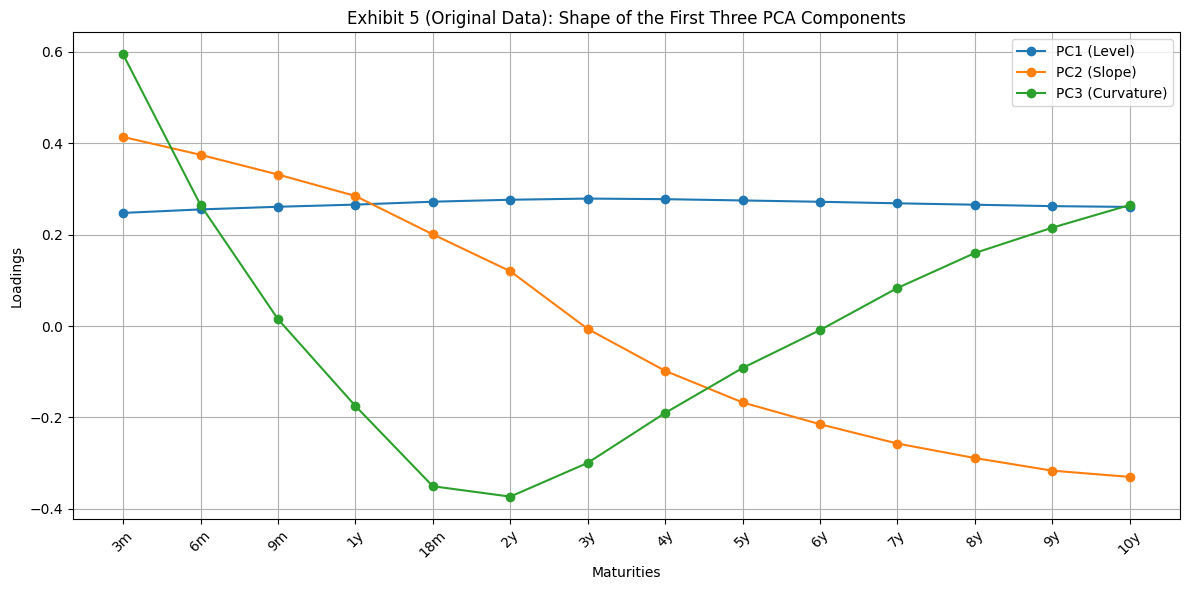

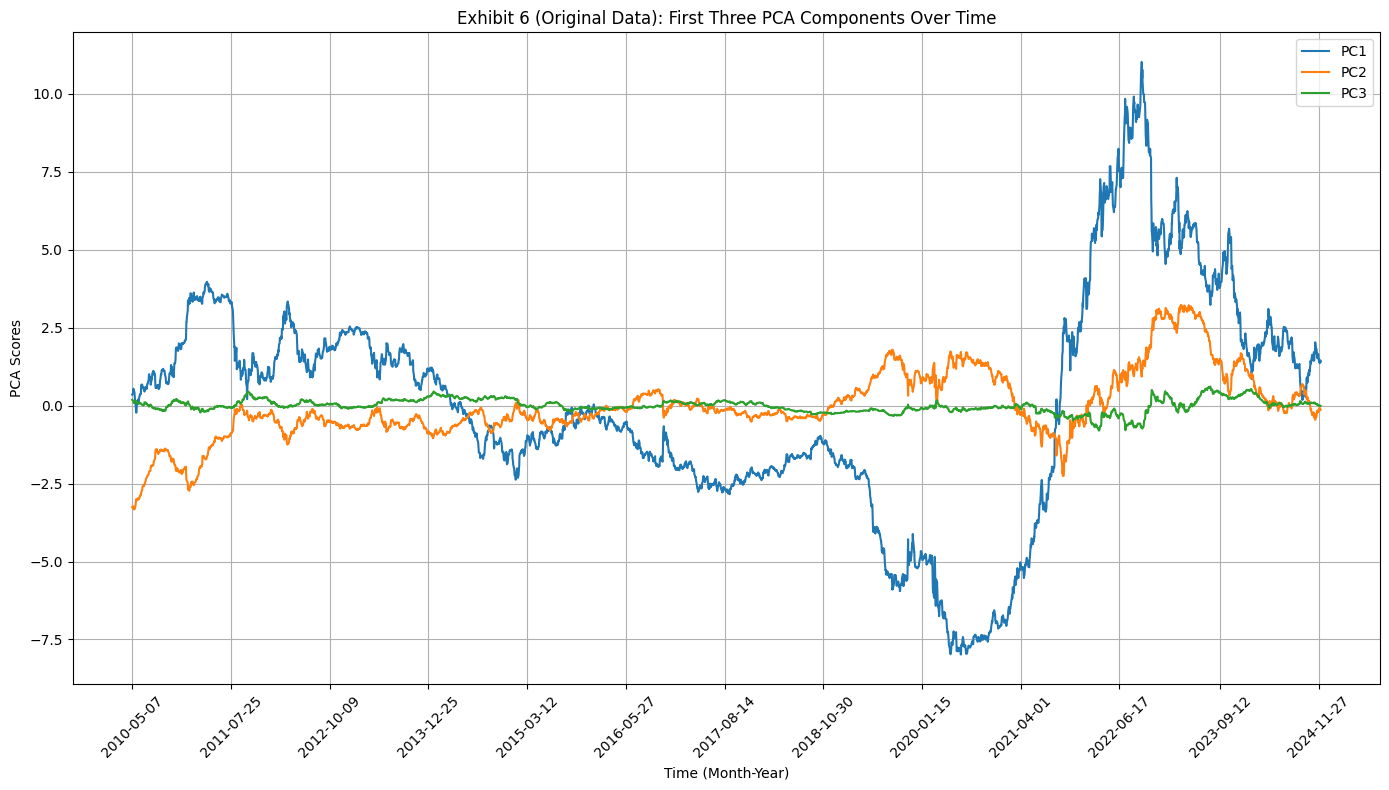

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
data_points = 3800
#columns = ['18m', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y']
columns =  ['3m','6m','9m','1y','18m','2y','3y','4y','5y','6y','7y','8y','9y','10y']
df_cam['Date'] = df_cam.index
# Use the original data (not daily changes) for PCA
# Select the last 252 rows of the original data for analysis
selected_data = df_cam[columns].iloc[-data_points:]

# Standardize the original data (mean=0, std=1)
scaler = StandardScaler()  # Initialize the scaler
standardized_original_data = scaler.fit_transform(selected_data)

# Perform PCA on the standardized original data
pca_original = PCA(n_components=3)
pca_components_original = pca_original.fit_transform(standardized_original_data)

# Extract loadings for Exhibit 5
loadings_original = pd.DataFrame(
    pca_original.components_.T,
    columns=["PC1 (Level)", "PC2 (Slope)", "PC3 (Curvature)"],
    index=columns
)

# Plot Exhibit 5: Shape of the three components across maturities (original data)
plt.figure(figsize=(12, 6))
for component in loadings_original.columns:
    plt.plot(loadings_original.index, loadings_original[component], label=component, marker='o')

plt.title("Exhibit 5 (Original Data): Shape of the First Three PCA Components")
plt.xlabel("Maturities")
plt.ylabel("Loadings")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create PCA scores DataFrame for the original data
pca_original_df = pd.DataFrame(
    pca_components_original,
    columns=["PC1", "PC2", "PC3"]
)
pca_original_df['Date'] = df_cam['Date'].iloc[-data_points:].reset_index(drop=True)

# Plot Exhibit 6: First three components over time (original data)
plt.figure(figsize=(14, 8))
for component in ["PC1", "PC2", "PC3"]:
    plt.plot(
        pca_original_df["Date"], pca_original_df[component], label=component
    )

plt.title("Exhibit 6 (Original Data): First Three PCA Components Over Time")
plt.xlabel("Time (Month-Year)")
plt.ylabel("PCA Scores")
plt.legend()
plt.grid()
plt.xticks(
    pca_original_df["Date"].iloc[::len(pca_original_df) // 12],  # Show one label per month
    rotation=45,
    fontsize=10,
)
plt.tight_layout()
plt.show()



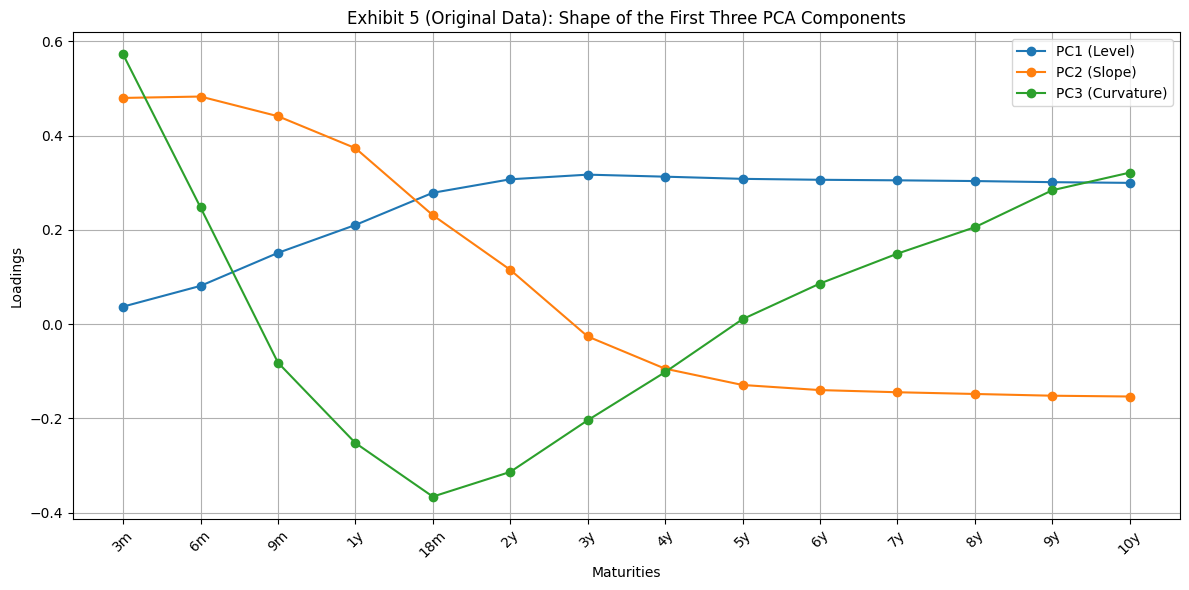

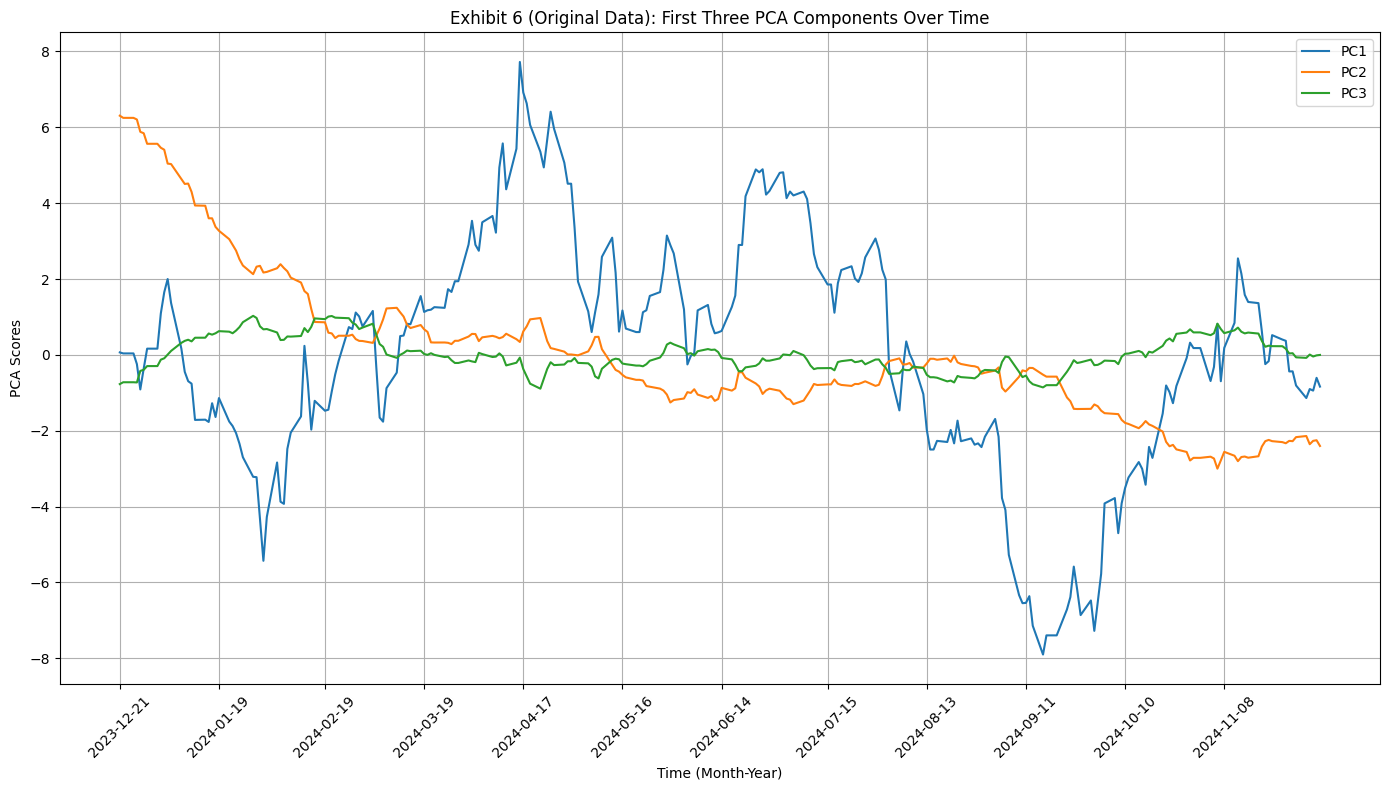

In [15]:
#PCA using aboslute swap values
data_points = 252
#selected_columns = ['18m', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y']
selected_columns =  ['3m','6m','9m','1y','18m','2y','3y','4y','5y','6y','7y','8y','9y','10y']
# Use the original data (not daily changes) for PCA
# Select the last 252 rows of the original data for analysis
selected_data = df_cam[selected_columns].iloc[-data_points:]
df_cam['Date'] = df_cam.index
# Standardize the original data (mean=0, std=1)
scaler = StandardScaler()  # Initialize the scaler
standardized_original_data = scaler.fit_transform(selected_data)

# Perform PCA on the standardized original data
pca_original = PCA(n_components=3)
pca_components_original = pca_original.fit_transform(standardized_original_data)

# Extract loadings for Exhibit 5
loadings_original = pd.DataFrame(
    pca_original.components_.T,
    columns=["PC1 (Level)", "PC2 (Slope)", "PC3 (Curvature)"],
    index=selected_columns
)

# Plot Exhibit 5: Shape of the three components across maturities (original data)
plt.figure(figsize=(12, 6))
for component in loadings_original.columns:
    plt.plot(loadings_original.index, loadings_original[component], label=component, marker='o')

plt.title("Exhibit 5 (Original Data): Shape of the First Three PCA Components")
plt.xlabel("Maturities")
plt.ylabel("Loadings")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create PCA scores DataFrame for the original data
pca_original_df = pd.DataFrame(
    pca_components_original,
    columns=["PC1", "PC2", "PC3"]
)
pca_original_df["Date"] = df_cam["Date"].iloc[-data_points:].reset_index(drop=True)

# Plot Exhibit 6: First three components over time (original data)
plt.figure(figsize=(14, 8))
for component in ["PC1", "PC2", "PC3"]:
    plt.plot(
        pca_original_df["Date"], pca_original_df[component], label=component
    )

plt.title("Exhibit 6 (Original Data): First Three PCA Components Over Time")
plt.xlabel("Time (Month-Year)")
plt.ylabel("PCA Scores")
plt.legend()
plt.grid()
plt.xticks(
    pca_original_df["Date"].iloc[::len(pca_original_df) // 12],  # Show one label per month
    rotation=45,
    fontsize=10,
)
plt.tight_layout()
plt.show()


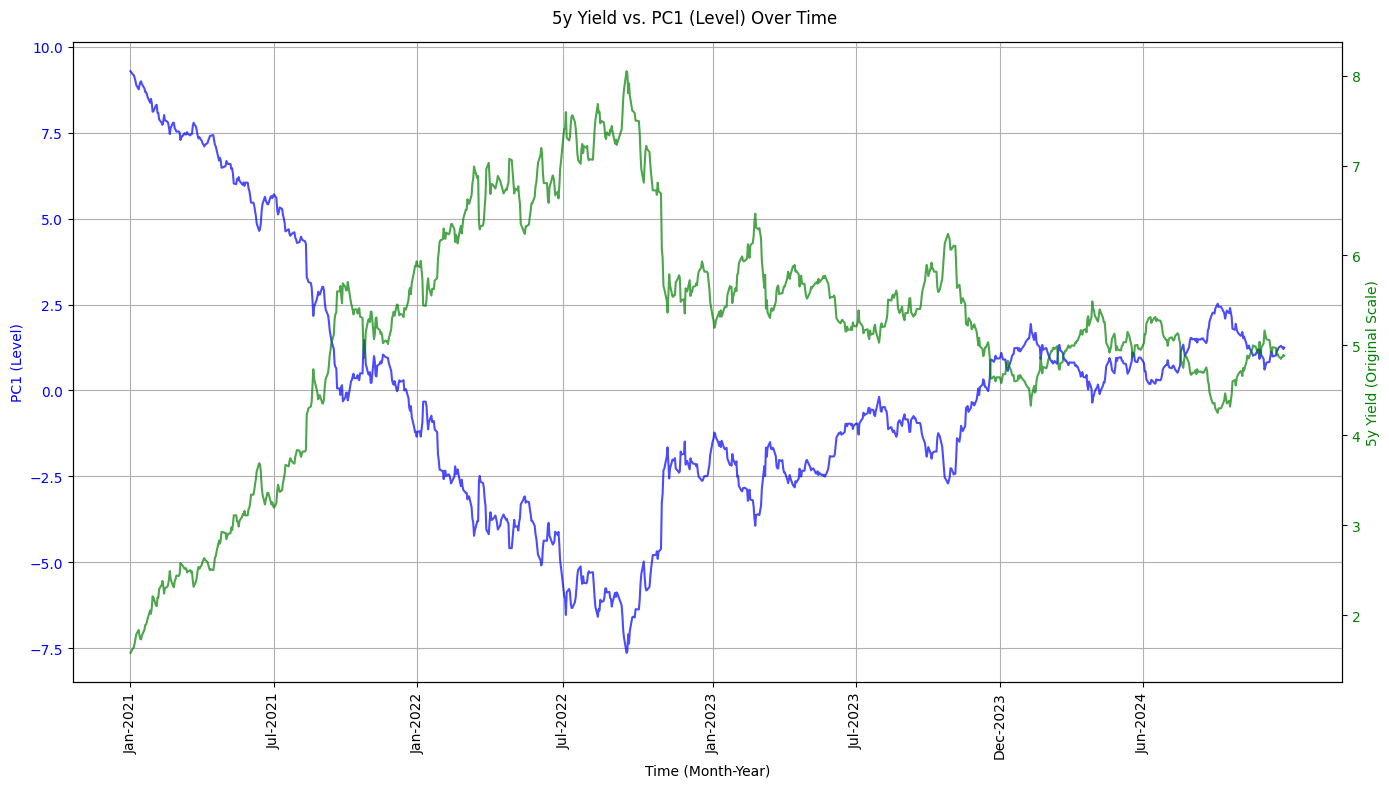

In [16]:
# PCA using absolute swap values plot specific tenor vs PC1
data_points = 1000
#selected_columns = ['18m', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y']
selected_columns =  ['3m','6m','9m','1y','18m','2y','3y','4y','5y','6y','7y','8y','9y','10y']
tenor = '5y'  # Specify the tenor dynamically

# Use the original data (not daily changes) for PCA
# Select the last 252 rows of the original data for analysis
selected_data = df_cam[selected_columns].iloc[-data_points:]
df_cam['Date'] = df_cam.index  # Ensure the 'Date' column exists

# Standardize the original data (mean=0, std=1)
scaler = StandardScaler()
standardized_original_data = scaler.fit_transform(selected_data)

# Perform PCA on the standardized original data
pca_original = PCA(n_components=3)
pca_components_original = pca_original.fit_transform(standardized_original_data)

# Extract loadings for Exhibit 5
loadings_original = pd.DataFrame(
    pca_original.components_.T,
    columns=["PC1 (Level)", "PC2 (Slope)", "PC3 (Curvature)"],
    index=selected_columns
)

# Create PCA scores DataFrame for the original data
pca_original_df = pd.DataFrame(
    pca_components_original,
    columns=["PC1", "PC2", "PC3"]
)
pca_original_df["Date"] = df_cam["Date"].iloc[-data_points:].reset_index(drop=True)

# Flip the sign of PC1 to align it positively with the selected tenor yield
pca_original_df["PC1"] = -pca_original_df["PC1"]

# Extract the selected tenor values for plotting
selected_tenor = selected_data[tenor].reset_index(drop=True)

# Create a dual-axis plot for the selected tenor yield and PC1 (Level) with dates and corrected signs
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot PC1 on the left y-axis
ax1.set_xlabel("Time (Month-Year)")
ax1.set_ylabel("PC1 (Level)", color="blue")
ax1.plot(pca_original_df["Date"], pca_original_df["PC1"], label="PC1 (Level)", color="blue", alpha=0.7)
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid()

# Plot the selected tenor yield on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel(f"{tenor} Yield (Original Scale)", color="green")  # Dynamically update the label for the tenor
ax2.plot(pca_original_df["Date"], selected_tenor, label=f"{tenor} Yield", color="green", alpha=0.7)
ax2.tick_params(axis="y", labelcolor="green")

# Add a title and format the x-axis to show quarterly date intervals
quarterly_ticks = pca_original_df["Date"].iloc[::int(round(data_points/8,0))]  # Approximate quarterly intervals
formatted_labels = [tick.strftime('%b-%Y') for tick in quarterly_ticks]
ax1.set_xticks(quarterly_ticks)
ax1.set_xticklabels(formatted_labels, rotation=90, fontsize=10)

# Final adjustments and display
fig.suptitle(f"{tenor} Yield vs. PC1 (Level) Over Time")  # Dynamically update the title for the tenor
plt.tight_layout()
plt.show()


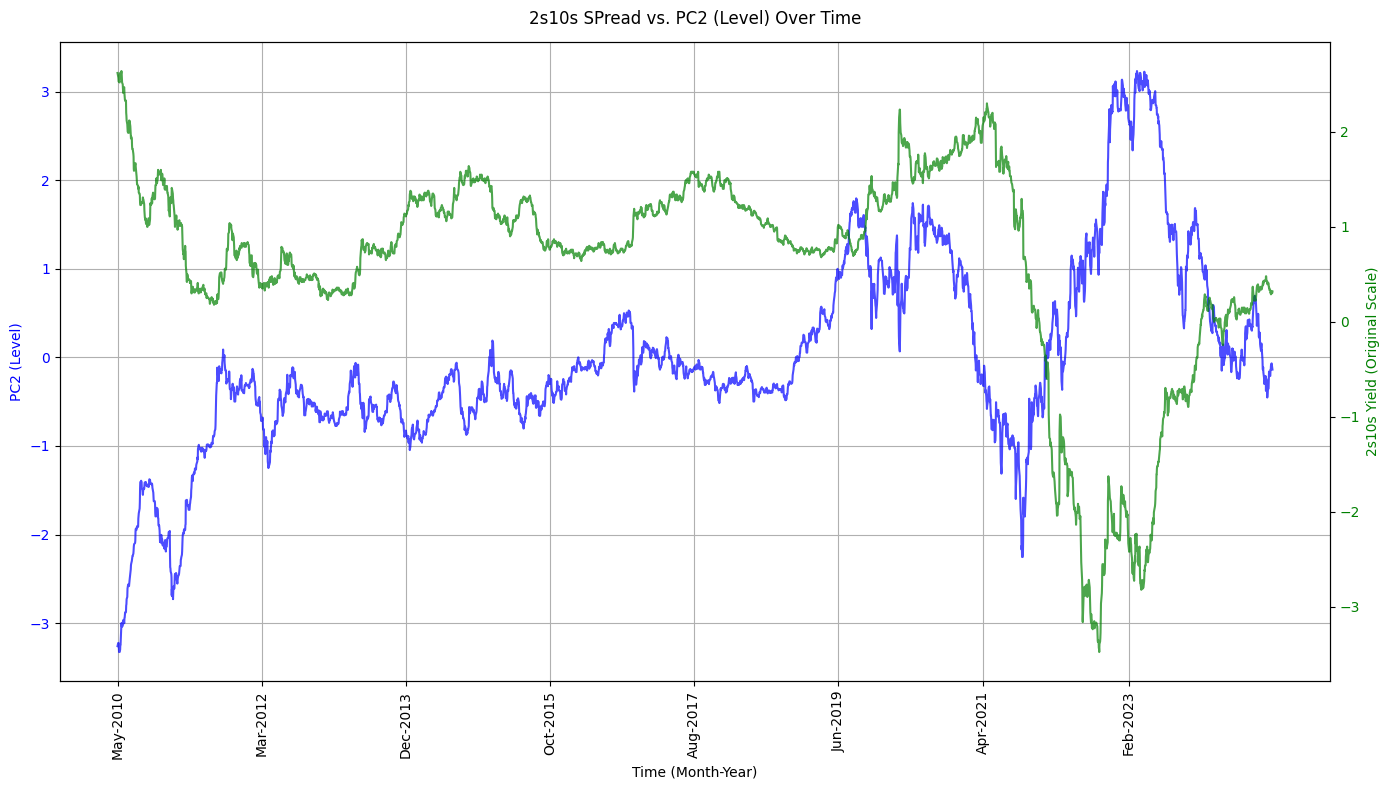

In [17]:
# PCA using absolute swap values plot specific tenor vs PC2
data_points = 3800
#selected_columns = ['18m', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y']
selected_columns =  ['3m','6m','9m','1y','18m','2y','3y','4y','5y','6y','7y','8y','9y','10y']
tenor = '2s10s'  # Specify the tenor dynamically

# Use the original data (not daily changes) for PCA
# Select the last 252 rows of the original data for analysis
selected_data = df_cam[selected_columns].iloc[-data_points:]
df_cam['Date'] = df_cam.index  # Ensure the 'Date' column exists

# Standardize the original data (mean=0, std=1)
scaler = StandardScaler()
standardized_original_data = scaler.fit_transform(selected_data)

# Perform PCA on the standardized original data
pca_original = PCA(n_components=3)
pca_components_original = pca_original.fit_transform(standardized_original_data)

# Extract loadings for Exhibit 5
loadings_original = pd.DataFrame(
    pca_original.components_.T,
    columns=["PC1 (Level)", "PC2 (Slope)", "PC3 (Curvature)"],
    index=selected_columns
)

# Create PCA scores DataFrame for the original data
pca_original_df = pd.DataFrame(
    pca_components_original,
    columns=["PC1", "PC2", "PC3"]
)
pca_original_df["Date"] = df_cam["Date"].iloc[-data_points:].reset_index(drop=True)

# Flip the sign of PC1 to align it positively with the selected tenor yield
pca_original_df["PC2"] = pca_original_df["PC2"]

# Extract the selected tenor values for plotting
selected_tenor =  df_cam[tenor].iloc[-data_points:].reset_index(drop=True)

# Create a dual-axis plot for the selected tenor yield and PC1 (Level) with dates and corrected signs
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot PC1 on the left y-axis
ax1.set_xlabel("Time (Month-Year)")
ax1.set_ylabel("PC2 (Level)", color="blue")
ax1.plot(pca_original_df["Date"], pca_original_df["PC2"], label="PC2 (Level)", color="blue", alpha=0.7)
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid()

# Plot the selected tenor yield on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel(f"{tenor} Yield (Original Scale)", color="green")  # Dynamically update the label for the tenor
ax2.plot(pca_original_df["Date"], selected_tenor, label=f"{tenor} Yield", color="green", alpha=0.7)
ax2.tick_params(axis="y", labelcolor="green")

# Add a title and format the x-axis to show quarterly date intervals
quarterly_ticks = pca_original_df["Date"].iloc[::int(round(data_points/8,0))]  # Approximate quarterly intervals
formatted_labels = [tick.strftime('%b-%Y') for tick in quarterly_ticks]
ax1.set_xticks(quarterly_ticks)
ax1.set_xticklabels(formatted_labels, rotation=90, fontsize=10)

# Final adjustments and display
fig.suptitle(f"{tenor} SPread vs. PC2 (Level) Over Time")  # Dynamically update the title for the tenor
plt.tight_layout()
plt.show()

In [16]:
df_cam['2s10s'].tail(1)

Date
2024-12-06    0.32
Name: 2s10s, dtype: float64

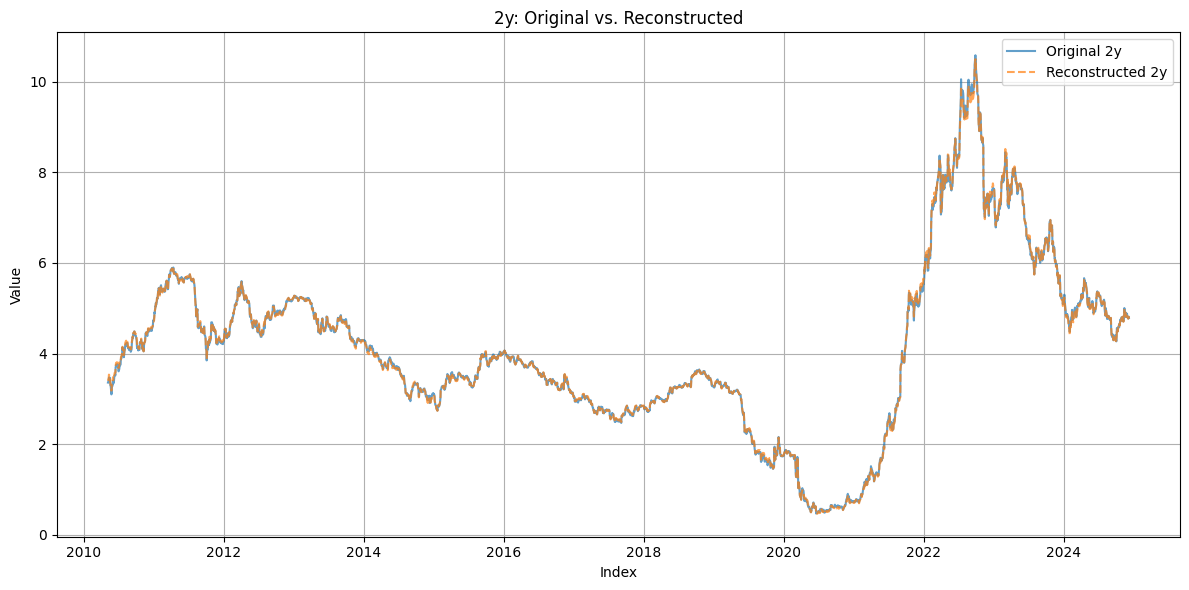

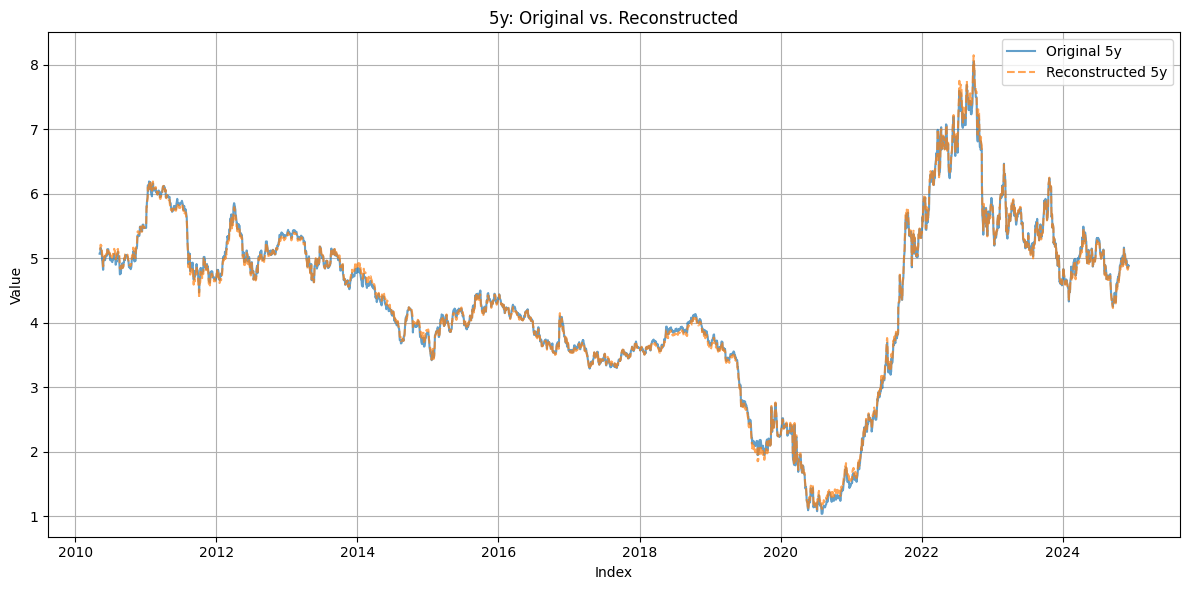

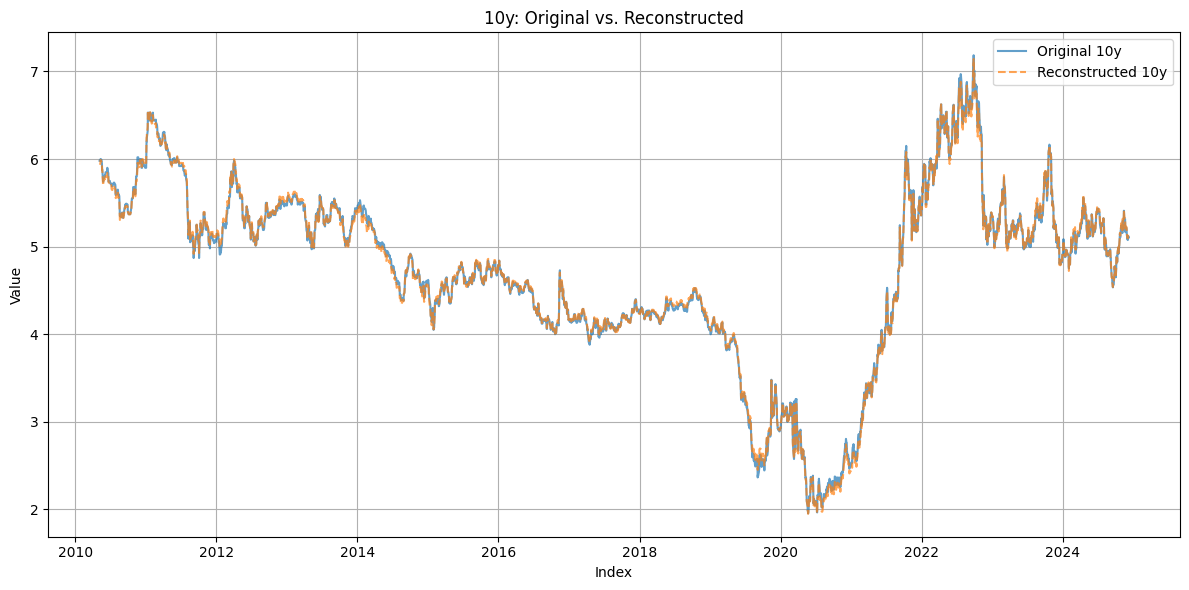

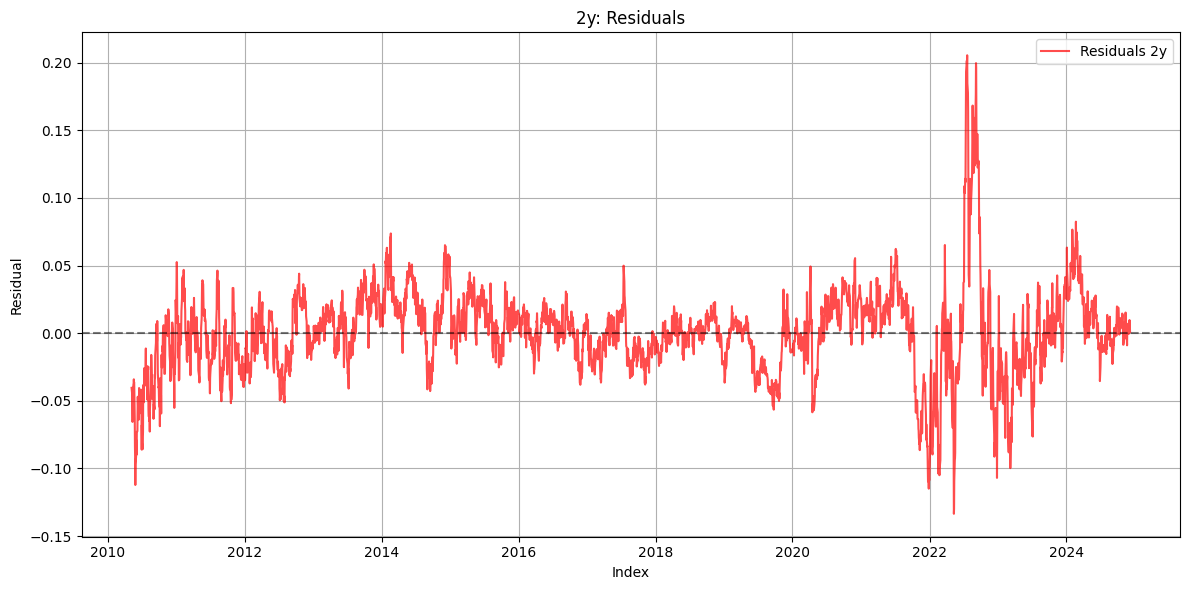

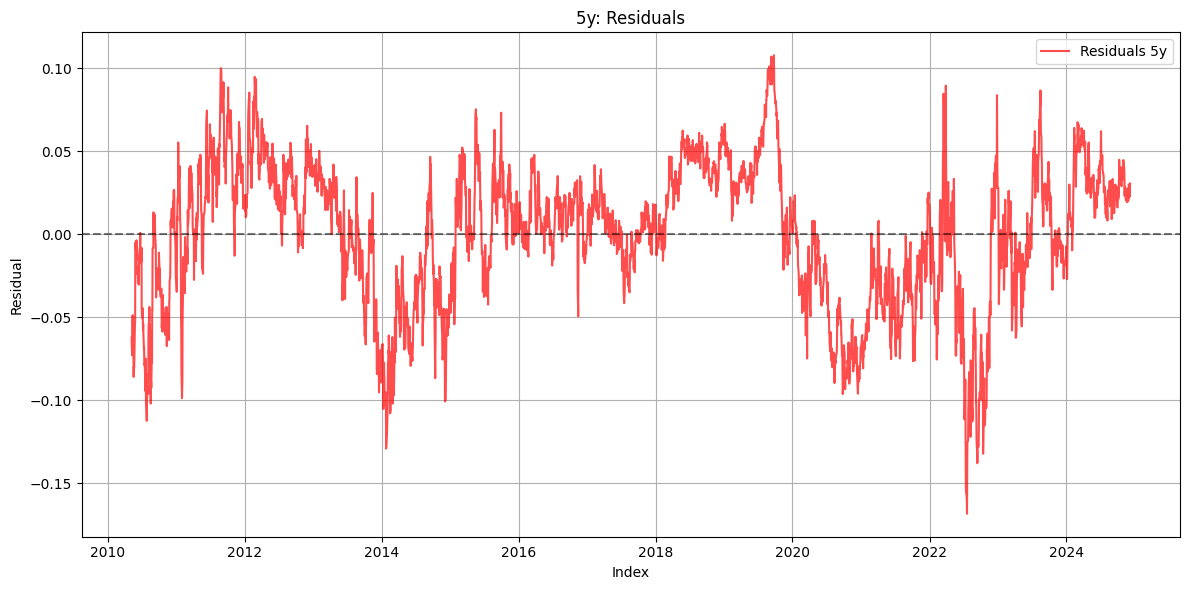

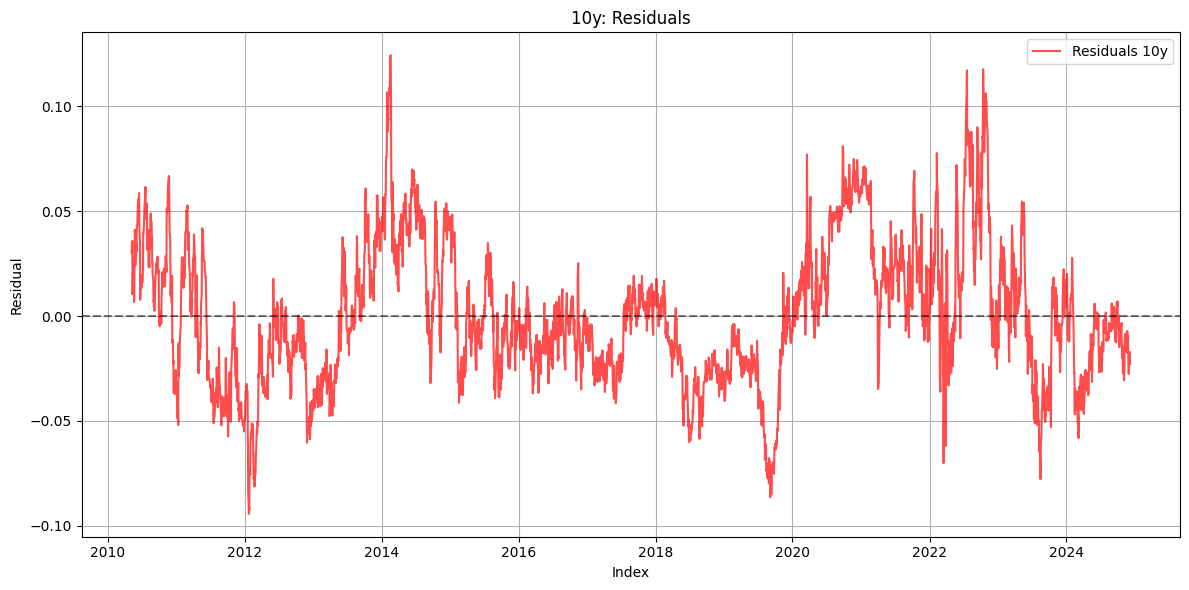

In [18]:
# Calculate pc1,pc2 and pc3 and recontruct speficic tenors
data_points = 3800
#selected_columns = ['3m','3m3m','6m3m','9m3m','1y6m','18m6m','1y1y','2y1y','3y1y','4y1y','2y2y','3y2y','5y2y','7y3y','5y5y']
#selected_columns = ['18m', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y']
selected_columns =  ['3m','6m','9m','1y','18m','2y','3y','4y','5y','6y','7y','8y','9y','10y']
# Use the original data (not daily changes) for PCA
# Select the last 252 rows of the original data for analysis
selected_data = df_cam[selected_columns].iloc[-data_points:]
df_cam['Date'] = df_cam.index
# Standardize the original data (mean=0, std=1)
scaler = StandardScaler()
standardized_original_data = scaler.fit_transform(selected_data)

# Perform PCA on the standardized original data
pca_original = PCA(n_components=3)
pca_components_original = pca_original.fit_transform(standardized_original_data)

# Extract loadings for Exhibit 5
loadings_original = pd.DataFrame(
    pca_original.components_.T,
    columns=["PC1 (Level)", "PC2 (Slope)", "PC3 (Curvature)"],
    index=selected_columns
)

# Step 1: Reconstruct the dataset using PC1, PC2, and PC3
reconstructed_standardized_data = pca_components_original @ pca_original.components_
reconstructed_data = scaler.inverse_transform(reconstructed_standardized_data)

# Convert to DataFrame for comparison
reconstructed_df = pd.DataFrame(reconstructed_data, columns=selected_columns, index=selected_data.index)

# Calculate residuals
residuals = selected_data - reconstructed_df

# Step 2: Plot original vs reconstructed dataset for selected columns
columns_to_plot = ['2y', '5y', '10y']  # Select columns to visualize

for column in columns_to_plot:
    plt.figure(figsize=(12, 6))
    plt.plot(selected_data.index, selected_data[column], label=f"Original {column}", alpha=0.7)
    plt.plot(selected_data.index, reconstructed_df[column], label=f"Reconstructed {column}", alpha=0.7, linestyle="--")
    plt.title(f"{column}: Original vs. Reconstructed")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Step 3: Plot residuals for the selected columns
for column in columns_to_plot:
    plt.figure(figsize=(12, 6))
    plt.plot(selected_data.index, residuals[column], label=f"Residuals {column}", color="red", alpha=0.7)
    plt.title(f"{column}: Residuals")
    plt.xlabel("Index")
    plt.ylabel("Residual")
    plt.axhline(0, color="black", linestyle="--", alpha=0.5)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

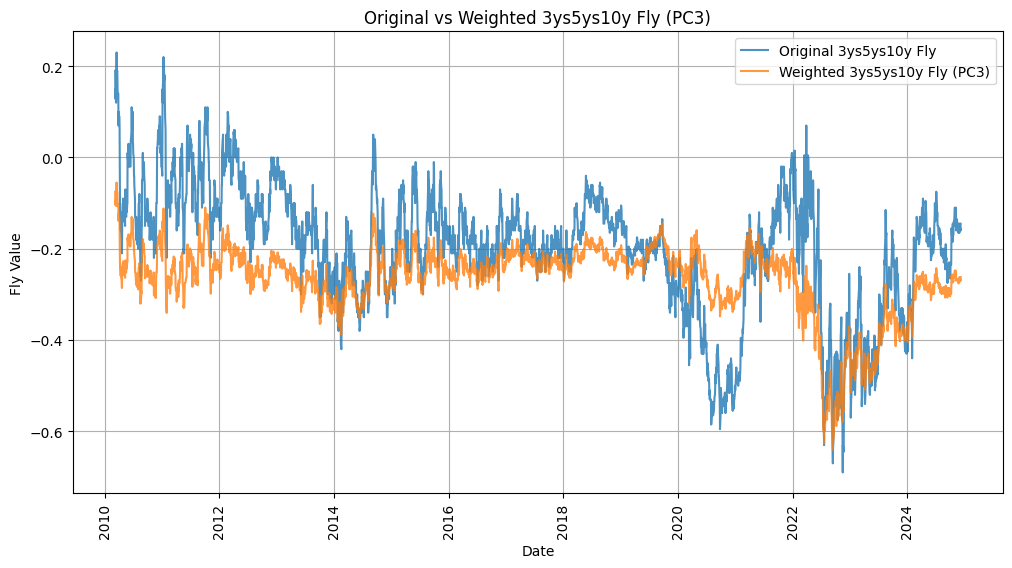

[-0.52561333  1.         -0.51298508] [-0.42363065  0.80597395 -0.41345261]


In [19]:
#Create flies with exposure to PC3. Use PC3 loading as weights

# Define the selected columns and number of data points for PCA
data_points = 3800
selected_columns = ['3y', '5y', '10y']

# Use the original data (not daily changes) for PCA
# Select the last 'data_points' rows of the original data for analysis
#'2021-12-30'
selected_data = df_cam.loc['2010-03-09':'2021-12-30',selected_columns] # Train using data up to end of 2021
all_data = df_cam.loc['2010-03-09':,selected_columns] 
#selected_data = df_cam[selected_columns].iloc[-data_points:]
df_cam['Date'] = df_cam.index

# Standardize the original data (mean=0, std=1)
scaler = StandardScaler()
standardized_original_data = scaler.fit_transform(selected_data.diff(5).dropna())

# Perform PCA on the standardized original data
pca_original = PCA(n_components=3)
pca_components_original = pca_original.fit_transform(standardized_original_data)

# Extract loadings dynamically for the selected columns
loadings_original = pd.DataFrame(
    pca_original.components_.T,
    columns=["PC1", "PC2", "PC3"],
    index=selected_columns
)

# Extract raw and scaled weights for PC3 dynamically
raw_weights_PC3 = pca_original.components_[2][:len(selected_columns)]
scaled_weights = (raw_weights_PC3 / raw_weights_PC3[1])

# Create the original fly and the PCA-weighted fly dynamically
fly_name = f"{selected_columns[0]}s{selected_columns[1]}s{selected_columns[2]}"
all_data[fly_name] = (
    2 * all_data[selected_columns[1]] -
    all_data[selected_columns[0]] -
    all_data[selected_columns[2]]
)
all_data[f"{fly_name} PCA"] = (
    all_data[selected_columns[1]] +
    all_data[selected_columns[0]] * scaled_weights[0] +
    all_data[selected_columns[2]] * scaled_weights[2]
)

# Plot using the datetime index on the x-axis
plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data[fly_name], label=f"Original {fly_name} Fly", alpha=0.8)
plt.plot(all_data.index, all_data[f"{fly_name} PCA"], label=f"Weighted {fly_name} Fly (PC3)", alpha=0.8)
plt.title(f"Original vs Weighted {fly_name} Fly (PC3)")
plt.xlabel('Date')
plt.ylabel('Fly Value')
plt.legend()
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.grid()
plt.show()

print(scaled_weights,raw_weights_PC3)

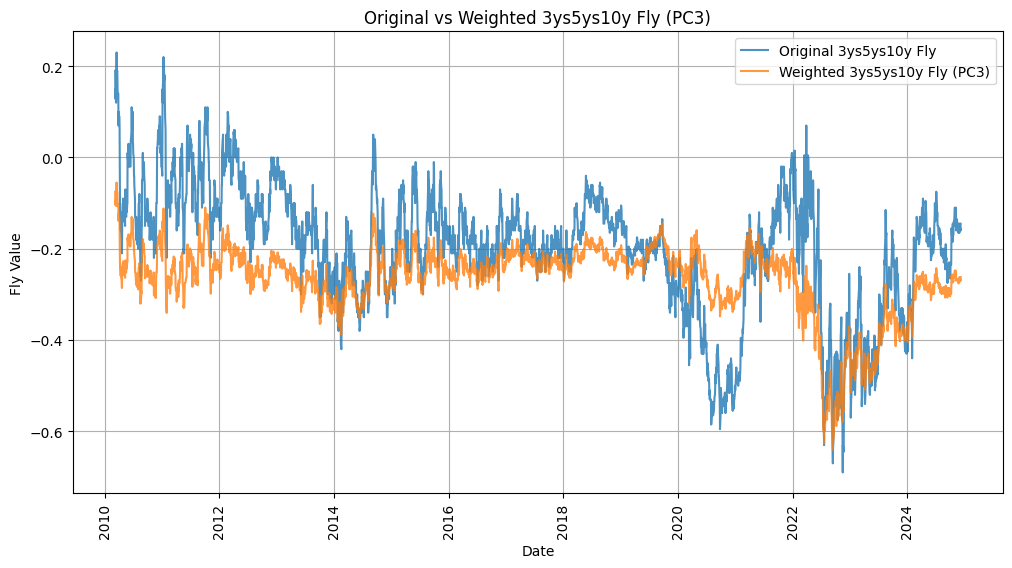

In [20]:
#Calculate weights of 3y and 10y

selected_columns[2]
A = np.array([ 
    [loadings_original['PC1'][selected_columns[0]],loadings_original['PC1'][selected_columns[2]]], 
    [loadings_original['PC2'][selected_columns[0]],loadings_original['PC2'][selected_columns[2]]]
])

b = -np.array([loadings_original['PC1'][selected_columns[1]],loadings_original['PC2'][selected_columns[1]]])

weights = np.linalg.solve(A,b) # save 3y and 10y weights in array

# Create the original fly and the PCA-weighted fly dynamically
fly_name = f"{selected_columns[0]}s{selected_columns[1]}s{selected_columns[2]}"
all_data[fly_name] = (
    2 * all_data[selected_columns[1]] -
    all_data[selected_columns[0]] -
    all_data[selected_columns[2]]
)
selected_data[f"{fly_name} PCA"] = (
    all_data[selected_columns[1]] +
    all_data[selected_columns[0]] * weights[0] +
    all_data[selected_columns[2]] * weights[1]
)

# Plot using the datetime index on the x-axis
plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data[fly_name], label=f"Original {fly_name} Fly", alpha=0.8)
plt.plot(all_data.index, all_data[f"{fly_name} PCA"], label=f"Weighted {fly_name} Fly (PC3)", alpha=0.8)
plt.title(f"Original vs Weighted {fly_name} Fly (PC3)")
plt.xlabel('Date')
plt.ylabel('Fly Value')
plt.legend()
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.grid()
plt.show()

C:\Users\Sebas\AppData\Local\Temp\ipykernel_61216\3452317348.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w_2 = (1-betas[1])
C:\Users\Sebas\AppData\Local\Temp\ipykernel_61216\3452317348.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w_5 = (2-betas[2])
C:\Users\Sebas\AppData\Local\Temp\ipykernel_61216\3452317348.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w_10 = (1+betas[1])
C:\Users\Sebas\AppData\Local\Temp\ip

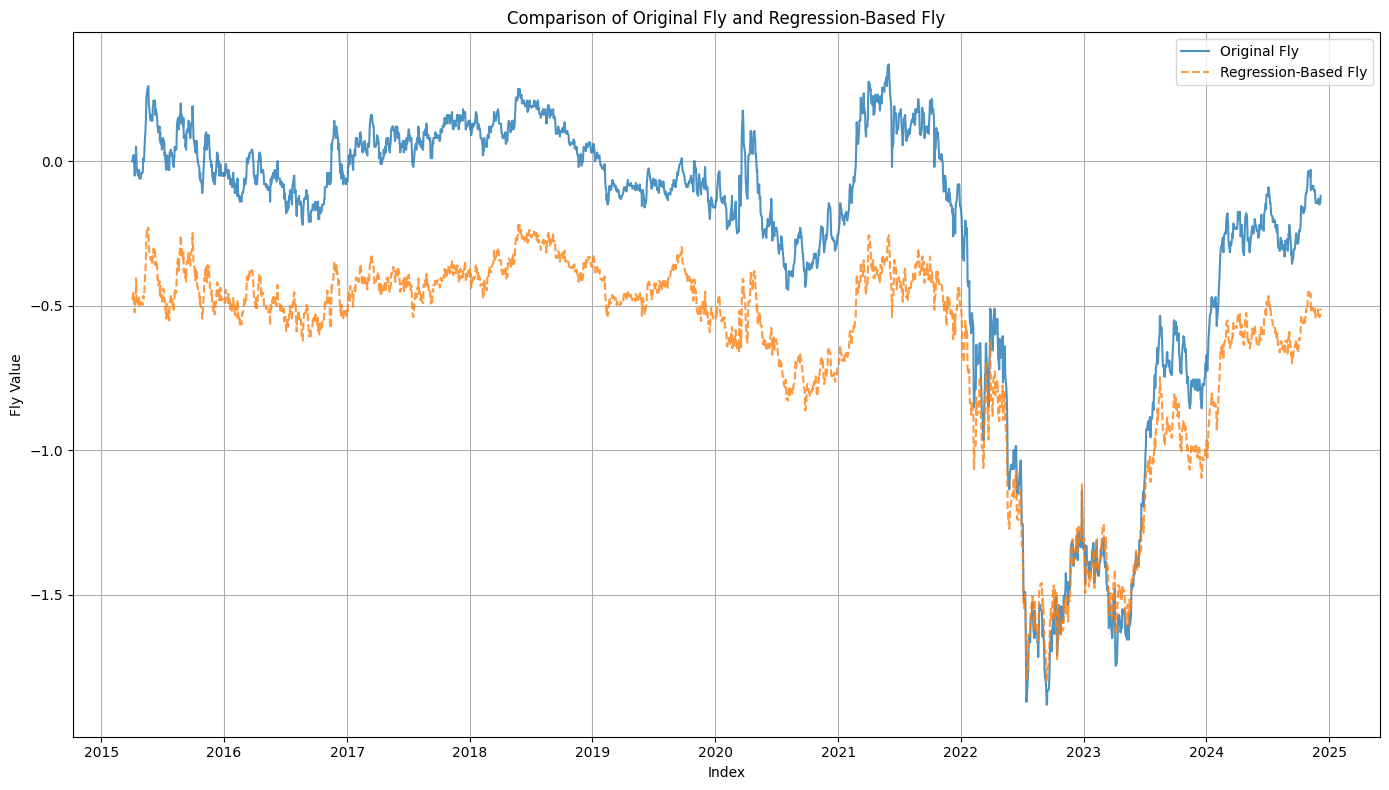

0.8358446578649145 2.0 1.2301764467422631


In [21]:
import statsmodels.api as sm
data_points=2520
# Extract relevant columns for regression
columns_for_regression = ['2s5s10s', '5y', '2s10s']
regression_data = df_cam[columns_for_regression].diff(1).tail(data_points).dropna()

# Define independent and dependent variables
X = regression_data[['2s10s', '5y']]  # Independent variables
y = regression_data['2s5s10s']  # Dependent variable

# Add a constant for the regression model
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Extract and display the beta coefficients
betas = model.params
#calculate weights for fly based regression
w_2 = (1-betas[1])
w_5 = (2-betas[2])
w_10 = (1+betas[1])
w_2 = (1-betas[1])/w_5*2
w_5 = (2-betas[2])/w_5*2
w_10 = (1+betas[1])/w_5*2
reg_fly = -w_2*df_cam['2y'].tail(data_points)+w_5*df_cam['5y'].tail(data_points)-w_10*df_cam['10y'].tail(data_points)
plt.figure(figsize=(14, 8))
plt.plot(regression_data.index,df_cam['2s5s10s'].tail(data_points), label='Original Fly', alpha=0.8)
plt.plot(regression_data.index, reg_fly, label='Regression-Based Fly', alpha=0.8, linestyle='--')
plt.title("Comparison of Original Fly and Regression-Based Fly")
plt.xlabel("Index")
plt.ylabel("Fly Value")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(w_2,w_5,w_10)

In [21]:
selected_data

3y     5y    10y  3ys5ys10y PCA
Date                                          
2010-03-09  3.660  4.870  5.890      -0.075227
2010-03-10  3.600  4.810  5.890      -0.103690
2010-03-11  3.580  4.810  5.890      -0.093178
2010-03-12  3.520  4.770  5.890      -0.101641
2010-03-15  3.520  4.750  5.860      -0.106251
...           ...    ...    ...            ...
2021-12-24  5.305  5.350  5.410      -0.213628
2021-12-27  5.295  5.340  5.375      -0.200417
2021-12-28  5.300  5.315  5.355      -0.217786
2021-12-29  5.410  5.415  5.445      -0.221772
2021-12-30  5.375  5.400  5.425      -0.208116

[3083 rows x 4 columns]

In [22]:
pca_full.explained_variance_


NameError: name 'pca_full' is not defined

In [ ]:
raw_weights_PC3


In [ ]:
loadings_original.loc[columns,'PC3 (Curvature)'].values

In [ ]:
columns

In [ ]:
columns  = ['3y','5y','10y']

In [ ]:
loadings_original

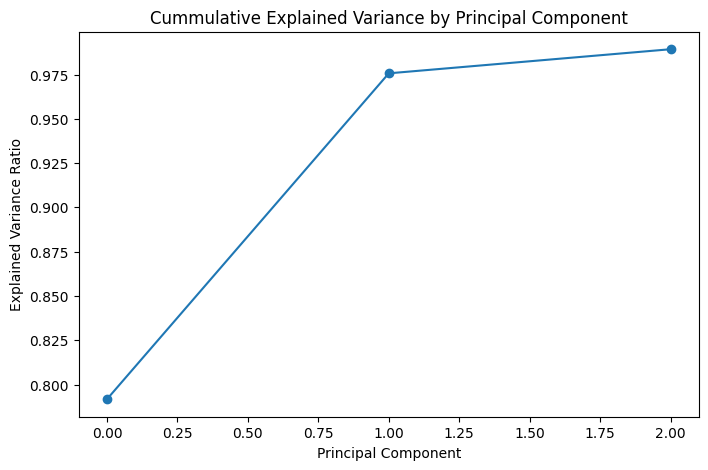

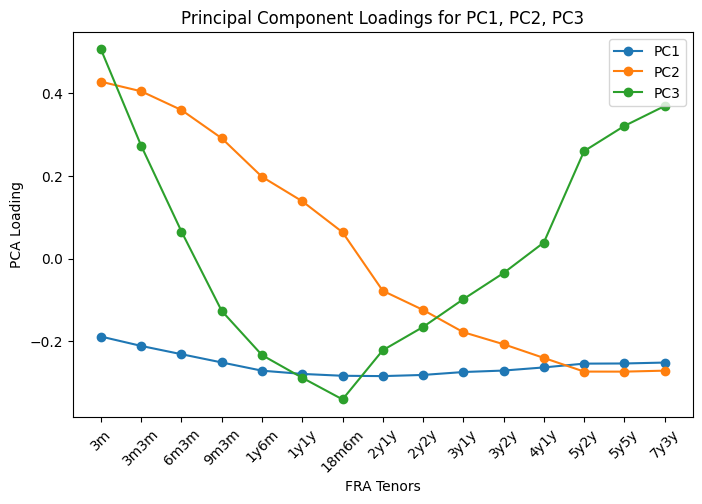

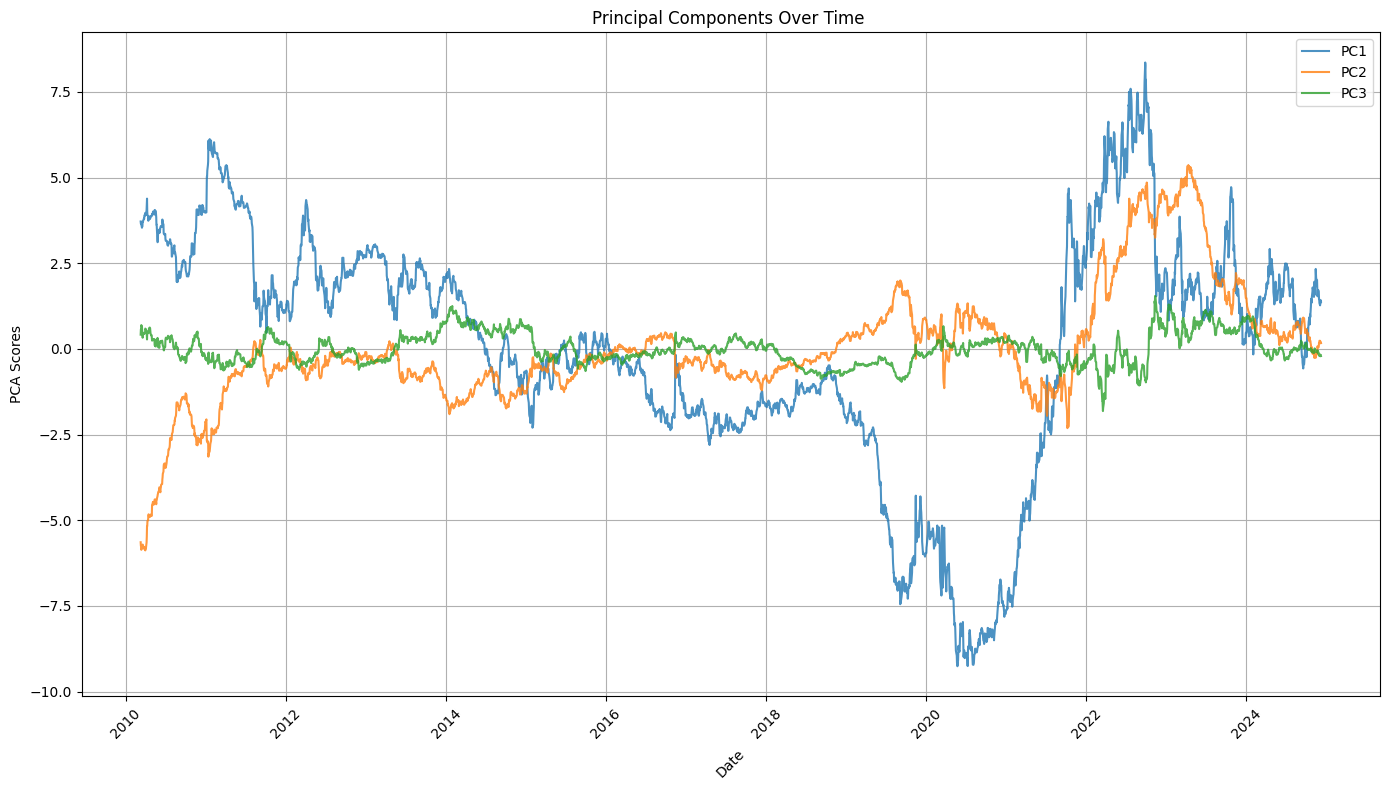

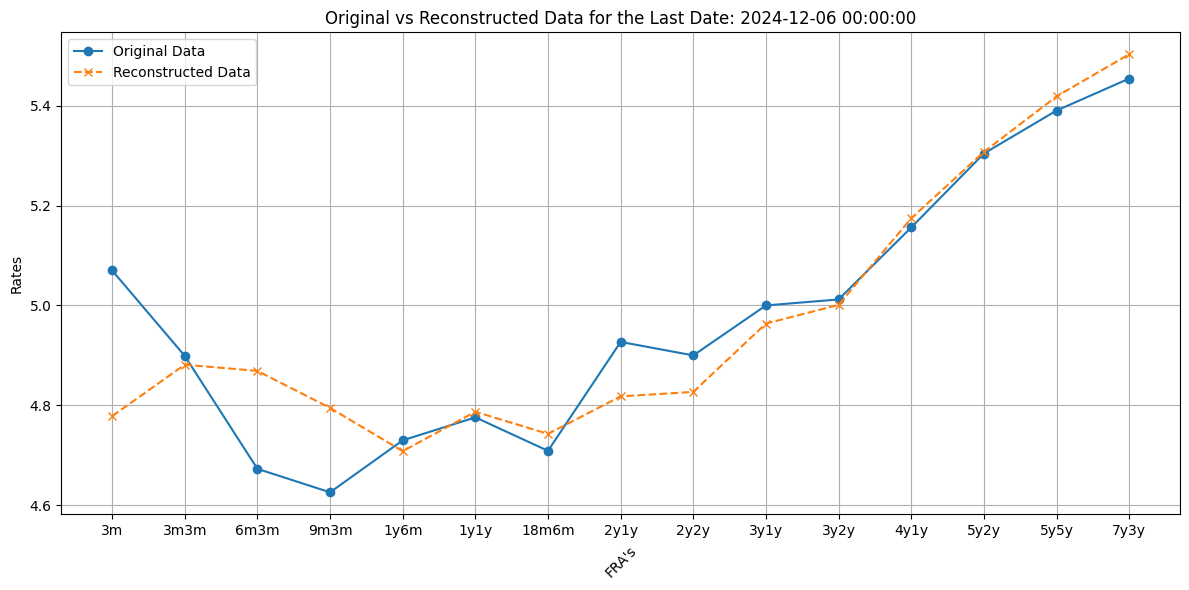

In [22]:
#Benchmark Spreads PCA analisis


columns = ['3m','3m3m','6m3m','9m3m','1y6m','1y1y','18m6m','2y1y','2y2y','3y1y','3y2y','4y1y','5y2y','5y5y','7y3y']

selected_data = df_cam.loc['2010-03-09':,columns].dropna()
#selected_data = df_cam.loc['2010-03-09':'2021-12-30',columns]
x_scaled = StandardScaler().fit_transform(selected_data)

pca = PCA(n_components=3)#n_components=14
pca = pca.fit(x_scaled)


# Extract loadings dynamically for the selected columns
loadings_original = pd.DataFrame(
    pca.components_[0:3].T,
    columns=["PC1 (Level)", "PC2 (Slope)", "PC3 (Curvature)"],
    index=columns
)

loadings_original['PC1 (Level)'] = loadings_original['PC1 (Level)']*-1

# Plot explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Cummulative Explained Variance by Principal Component")
plt.show()

# Plot the first three principal component loadings
plt.figure(figsize=(8, 5))
plt.plot(loadings_original, marker='o')
plt.xlabel("FRA Tenors")
plt.xticks(rotation=45)
plt.ylabel("PCA Loading")
plt.title("Principal Component Loadings for PC1, PC2, PC3")
plt.legend(['PC1', 'PC2', 'PC3'], loc='upper right')
plt.show()

# Transform the data using PCA and plot
x_pca_transformed = pca.transform(x_scaled)
transformed_df = pd.DataFrame(x_pca_transformed, columns=["PC1", "PC2", "PC3"], index=selected_data.index)
# Plot PCA scores with date as x-axis
plt.figure(figsize=(14, 8))
for component in ["PC1", "PC2", "PC3"]:
    plt.plot(selected_data.index, transformed_df[component], label=component, alpha=0.8)

plt.xlabel("Date")
plt.xlabel("Date", rotation=45) 
plt.ylabel("PCA Scores")
plt.title("Principal Components Over Time ")
plt.legend(['PC1', 'PC2', 'PC3'], loc='upper right')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# Reconstruct the dataset using the principal components
x_reconstructed = pca.inverse_transform(pca.transform(x_scaled))

# Reverse the scaling process to bring data back to its original scale
scaler = StandardScaler()
scaler.fit(selected_data)  # Fit scaler on the original data
x_reconstructed_original_scale = scaler.inverse_transform(x_reconstructed)

# Create a DataFrame for the reconstructed data in the original scale
df_reconstructed_data = pd.DataFrame(
    x_reconstructed_original_scale,
    columns=columns,
    index=selected_data.index
)


# Get the last date's original and reconstructed data
last_date_original = selected_data[columns].iloc[-1]
last_date_reconstructed = df_reconstructed_data[columns].iloc[-1]

# Plot the original and reconstructed data for the last date
plt.figure(figsize=(12, 6))
plt.plot(columns, last_date_original, label='Original Data', marker='o')
plt.plot(columns, last_date_reconstructed, label='Reconstructed Data', marker='x', linestyle='--')
plt.title(f"Original vs Reconstructed Data for the Last Date: {selected_data.index[-1]}")
plt.xlabel("FRA's")
plt.xlabel("FRA's", rotation=45) 
plt.ylabel("Rates")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Calculate residuals (original - reconstructed)
residuals = selected_data[columns] - df_reconstructed_data[columns]

# Calculate z-scores for the residuals
z_scores = (residuals - residuals.mean()) / residuals.std()

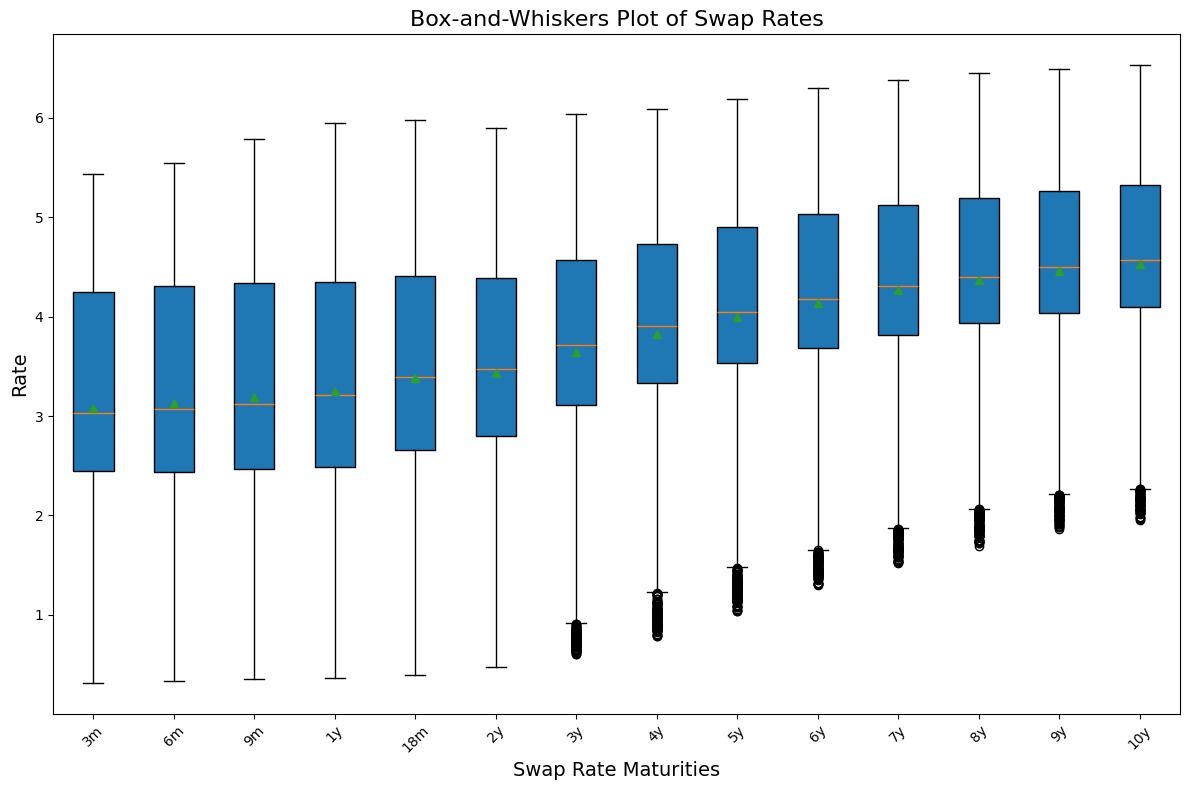

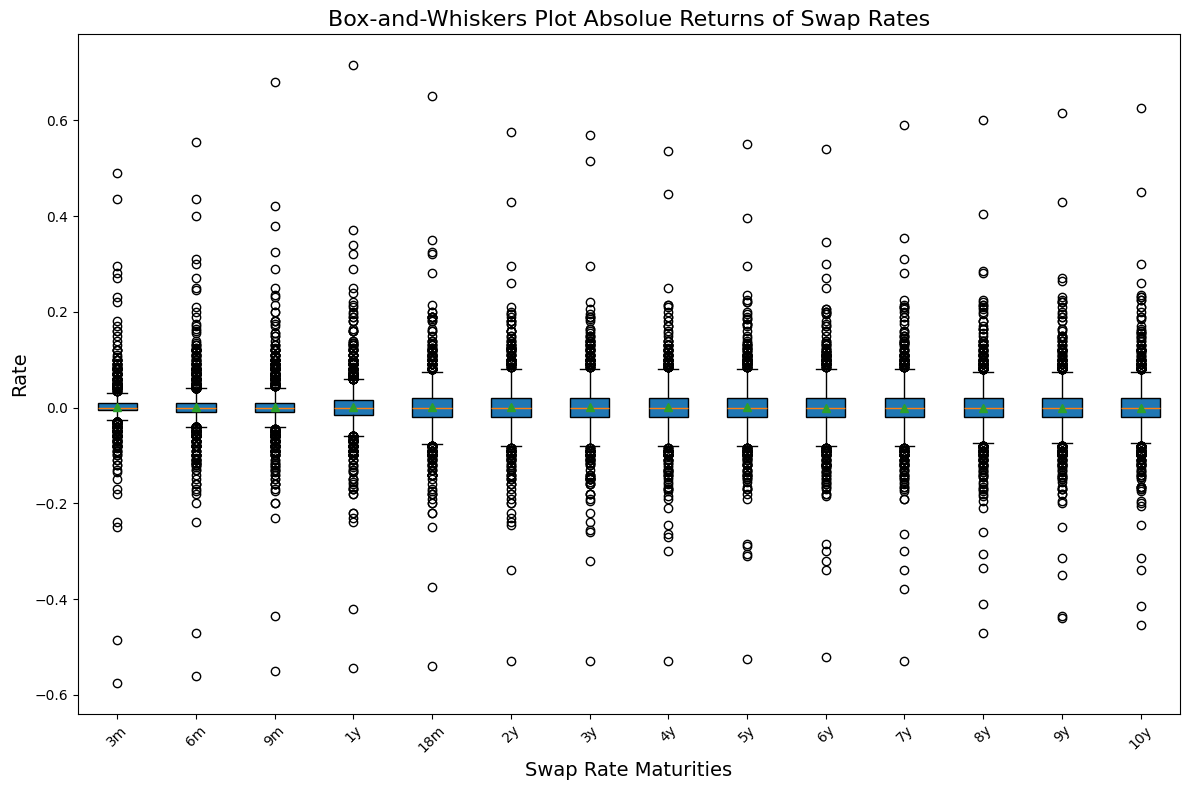

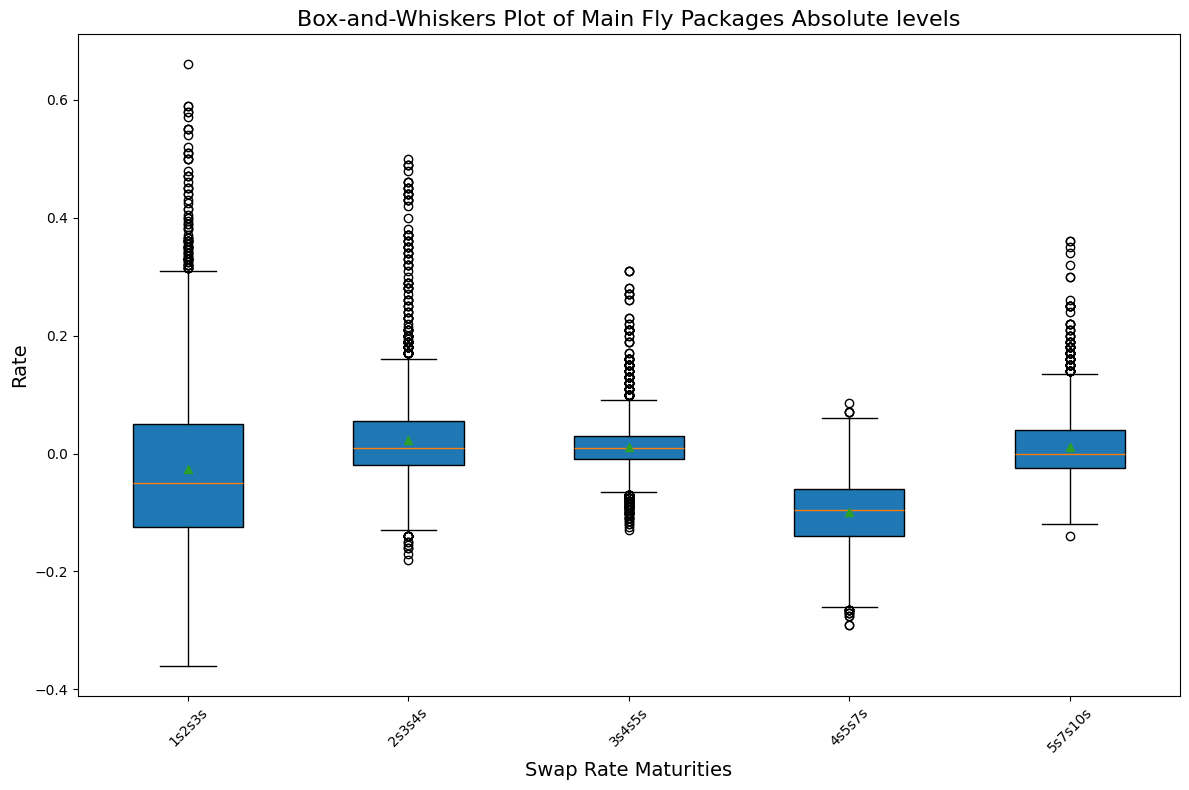

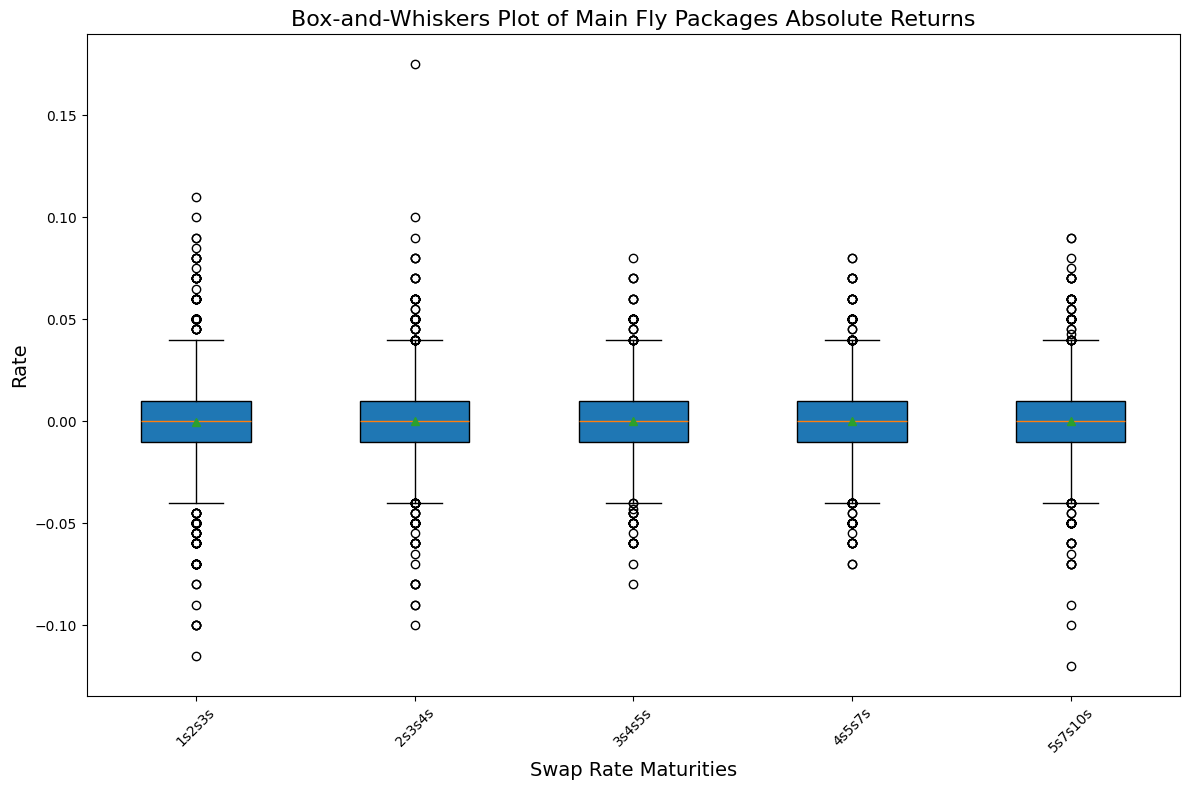

In [23]:
#PLot box and whiskers plot for absolute level of rates Chile CAM.
#columns = ['3m','3m3m','6m3m','9m3m','1y6m','18m6m','1y1y','2y1y','3y1y','4y1y','2y2y','3y2y','5y2y','7y3y','5y5y']
columns = ['3m','6m','9m','1y','18m','2y','3y','4y','5y','6y','7y','8y','9y','10y']
#columns = ['3m-3m3m', '3m3m-6m3m', '6m3m-9m3m', '9m3m-1y6m', '1y6m-18m6m', '18m6m-2y1y', '2y1y-3y1y', '2y1y-3y2y', '3y1y-4y1y', '4y1y-5y2y', '5y2y-7y3y', '3y2y-5y5y']
end_date = '2021-12-30'

selected_data = df_cam.loc['2010-03-09':end_date,columns]

# Create a box-and-whiskers plot
plt.figure(figsize=(12, 8))
plt.boxplot(selected_data.values, vert=True, patch_artist=True, showmeans=True)

# Customize the plot
plt.title("Box-and-Whiskers Plot of Swap Rates", fontsize=16)
plt.xlabel("Swap Rate Maturities", fontsize=14)
plt.ylabel("Rate", fontsize=14)
plt.xticks(ticks=range(1, len(columns) + 1), labels=columns, rotation=45, fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()
#Some conclusions:
# Short end has positive skew(right), longer end negative skew{left)}

#PLot box and whiskers plot for absolute changes of rates Chile CAM.
#columns = ['3m','3m3m','6m3m','9m3m','1y6m','18m6m','1y1y','2y1y','3y1y','4y1y','2y2y','3y2y','5y2y','7y3y','5y5y']
columns = ['3m','6m','9m','1y','18m','2y','3y','4y','5y','6y','7y','8y','9y','10y']
#columns = ['3m-3m3m', '3m3m-6m3m', '6m3m-9m3m', '9m3m-1y6m', '1y6m-18m6m', '18m6m-2y1y', '2y1y-3y1y', '2y1y-3y2y', '3y1y-4y1y', '4y1y-5y2y', '5y2y-7y3y', '3y2y-5y5y']
selected_data = df_cam.loc['2010-03-09':end_date,columns].diff(1).dropna()


# Filter for the last 3800 datapoints and the selected columns

# Create a box-and-whiskers plot
plt.figure(figsize=(12, 8))
plt.boxplot(selected_data.values, vert=True, patch_artist=True, showmeans=True)

# Customize the plot
plt.title("Box-and-Whiskers Plot Absolue Returns of Swap Rates", fontsize=16)
plt.xlabel("Swap Rate Maturities", fontsize=14)
plt.ylabel("Rate", fontsize=14)
plt.xticks(ticks=range(1, len(columns) + 1), labels=columns, rotation=45, fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()
#Some conclusions:
# Short end has positive skew(right), longer end negative skew{left)}



#PLot box and whiskers plot for fly packages absolute levels of rates Chile CAM.
#columns = ['3m','3m3m','6m3m','9m3m','1y6m','18m6m','1y1y','2y1y','3y1y','4y1y','2y2y','3y2y','5y2y','7y3y','5y5y']
columns = ['1s2s3s','2s3s4s','3s4s5s','4s5s7s','5s7s10s']
#columns = ['3m-3m3m', '3m3m-6m3m', '6m3m-9m3m', '9m3m-1y6m', '1y6m-18m6m', '18m6m-2y1y', '2y1y-3y1y', '2y1y-3y2y', '3y1y-4y1y', '4y1y-5y2y', '5y2y-7y3y', '3y2y-5y5y']
selected_data = df_cam.loc['2010-03-09':end_date,columns]

# Create a box-and-whiskers plot
plt.figure(figsize=(12, 8))
plt.boxplot(selected_data.values, vert=True, patch_artist=True, showmeans=True)

# Customize the plot
plt.title("Box-and-Whiskers Plot of Main Fly Packages Absolute levels", fontsize=16)
plt.xlabel("Swap Rate Maturities", fontsize=14)
plt.ylabel("Rate", fontsize=14)
plt.xticks(ticks=range(1, len(columns) + 1), labels=columns, rotation=45, fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()
#Some conclusions:
# Short end has positive skew(right), longer end negative skew{left)}

#PLot box and whiskers plot for fly packages absolute changes of rates Chile CAM.
#columns = ['3m','3m3m','6m3m','9m3m','1y6m','18m6m','1y1y','2y1y','3y1y','4y1y','2y2y','3y2y','5y2y','7y3y','5y5y']
columns = ['1s2s3s','2s3s4s','3s4s5s','4s5s7s','5s7s10s']
#columns = ['3m-3m3m', '3m3m-6m3m', '6m3m-9m3m', '9m3m-1y6m', '1y6m-18m6m', '18m6m-2y1y', '2y1y-3y1y', '2y1y-3y2y', '3y1y-4y1y', '4y1y-5y2y', '5y2y-7y3y', '3y2y-5y5y']
selected_data = df_cam.loc['2010-03-09':end_date,columns].diff(1).dropna()

# Filter for the last 3800 datapoints and the selected columns

# Create a box-and-whiskers plot
plt.figure(figsize=(12, 8))
plt.boxplot(selected_data.values, vert=True, patch_artist=True, showmeans=True)

# Customize the plot
plt.title("Box-and-Whiskers Plot of Main Fly Packages Absolute Returns", fontsize=16)
plt.xlabel("Swap Rate Maturities", fontsize=14)
plt.ylabel("Rate", fontsize=14)
plt.xticks(ticks=range(1, len(columns) + 1), labels=columns, rotation=45, fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()







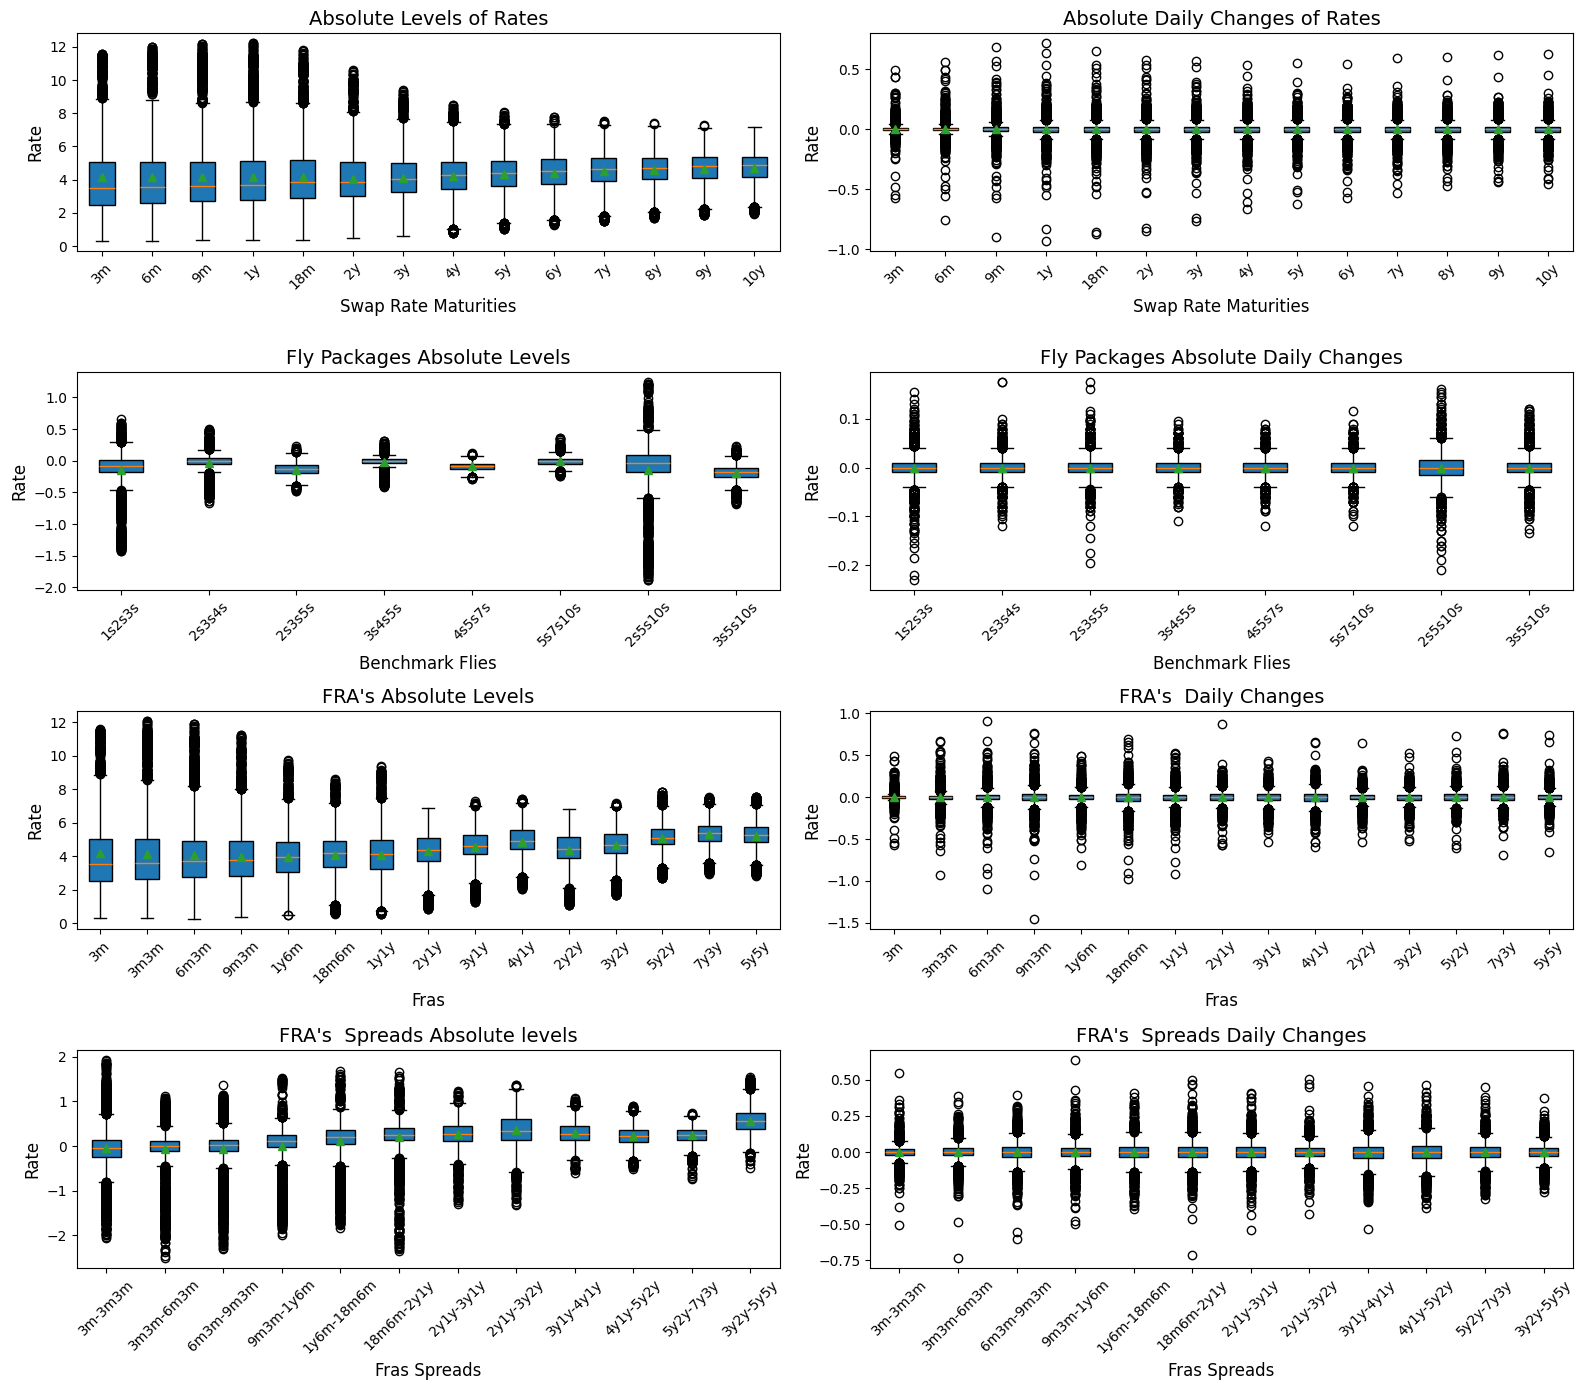

In [24]:



# Define the columns and end date
end_date = '2024-12-06'
#2019-12-30

# Define column groups
columns_levels = ['3m', '6m', '9m', '1y', '18m', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y']
columns_fly = ['1s2s3s', '2s3s4s', '2s3s5s','3s4s5s', '4s5s7s', '5s7s10s','2s5s10s','3s5s10s']
columns_fras =  ['3m','3m3m','6m3m','9m3m','1y6m','18m6m','1y1y','2y1y','3y1y','4y1y','2y2y','3y2y','5y2y','7y3y','5y5y']
columns_fra_spreads =  ['3m-3m3m', '3m3m-6m3m', '6m3m-9m3m', '9m3m-1y6m', '1y6m-18m6m', '18m6m-2y1y', '2y1y-3y1y', 
                        '2y1y-3y2y', '3y1y-4y1y', '4y1y-5y2y', '5y2y-7y3y', '3y2y-5y5y']
columns_fra_spreads2 = ['3m3m-3m','6m3m-3m3m','9m3m-6m3m','1y6m-9m3m','18m6m-1y6m','2y1y-18m6m','3y1y-2y1y','3y2y-2y1y','4y1y-3y1y', 
                      '5y2y-4y1y','7y3y-5y2y','5y5y-3y2y']
# Prepare datasets
selected_data_levels = df_cam.loc['2010-03-09':end_date, columns_levels]
selected_data_changes = selected_data_levels.diff(1).dropna()
selected_data_fly_levels = df_cam.loc['2010-03-09':end_date, columns_fly]
selected_data_fly_changes = selected_data_fly_levels.diff(1).dropna()
selected_data_fras = df_cam.loc['2010-03-09':end_date, columns_fras]
selected_data_fras_changes =  selected_data_fras.diff(1).dropna()
selected_data_fra_spreads = df_cam.loc['2010-03-09':end_date, columns_fra_spreads2]
selected_data_fra_spreads_changes = selected_data_fra_spreads.diff(1).dropna()

fig, axes = plt.subplots(4, 2, figsize=(16, 14))

# Plot 1: Absolute levels of rates
axes[0, 0].boxplot(selected_data_levels.values, vert=True, patch_artist=True, showmeans=True)
axes[0, 0].set_title("Absolute Levels of Rates", fontsize=14)
axes[0, 0].set_xlabel("Swap Rate Maturities", fontsize=12)
axes[0, 0].set_ylabel("Rate", fontsize=12)
axes[0, 0].set_xticks(range(1, len(columns_levels) + 1))
axes[0, 0].set_xticklabels(columns_levels, rotation=45, fontsize=10)

# Plot 2: Absolute changes of rates
axes[0, 1].boxplot(selected_data_changes.values, vert=True, patch_artist=True, showmeans=True)
axes[0, 1].set_title("Absolute Daily Changes of Rates", fontsize=14)
axes[0, 1].set_xlabel("Swap Rate Maturities", fontsize=12)
axes[0, 1].set_ylabel("Rate", fontsize=12)
axes[0, 1].set_xticks(range(1, len(columns_levels) + 1))
axes[0, 1].set_xticklabels(columns_levels, rotation=45, fontsize=10)

# Plot 3: Fly packages absolute levels
axes[1, 0].boxplot(selected_data_fly_levels.values, vert=True, patch_artist=True, showmeans=True)
axes[1, 0].set_title("Fly Packages Absolute Levels", fontsize=14)
axes[1, 0].set_xlabel("Benchmark Flies", fontsize=12)
axes[1, 0].set_ylabel("Rate", fontsize=12)
axes[1, 0].set_xticks(range(1, len(columns_fly) + 1))
axes[1, 0].set_xticklabels(columns_fly, rotation=45, fontsize=10)

# Plot 4: Fly packages absolute changes
axes[1, 1].boxplot(selected_data_fly_changes.values, vert=True, patch_artist=True, showmeans=True)
axes[1, 1].set_title("Fly Packages Absolute Daily Changes", fontsize=14)
axes[1, 1].set_xlabel("Benchmark Flies", fontsize=12)
axes[1, 1].set_ylabel("Rate", fontsize=12)
axes[1, 1].set_xticks(range(1, len(columns_fly) + 1))
axes[1, 1].set_xticklabels(columns_fly, rotation=45, fontsize=10)

# Plot 5: Fra's Levels
axes[2, 0].boxplot(selected_data_fras.values, vert=True, patch_artist=True, showmeans=True)
axes[2, 0].set_title("FRA's Absolute Levels", fontsize=14)
axes[2, 0].set_xlabel("Fras", fontsize=12)
axes[2, 0].set_ylabel("Rate", fontsize=12)
axes[2, 0].set_xticks(range(1, len(columns_fras) + 1))
axes[2, 0].set_xticklabels(columns_fras, rotation=45, fontsize=10)

# Plot 6: Fra CHanges
axes[2, 1].boxplot(selected_data_fras_changes.values, vert=True, patch_artist=True, showmeans=True)
axes[2, 1].set_title("FRA's  Daily Changes", fontsize=14)
axes[2, 1].set_xlabel("Fras", fontsize=12)
axes[2, 1].set_ylabel("Rate", fontsize=12)
axes[2, 1].set_xticks(range(1, len(columns_fras) + 1))
axes[2, 1].set_xticklabels(columns_fras, rotation=45, fontsize=10)

# Plot 7: Fra Speads levels
axes[3, 0].boxplot(selected_data_fra_spreads.values, vert=True, patch_artist=True, showmeans=True)
axes[3, 0].set_title("FRA's  Spreads Absolute levels", fontsize=14)
axes[3, 0].set_xlabel("Fras Spreads", fontsize=12)
axes[3, 0].set_ylabel("Rate", fontsize=12)
axes[3, 0].set_xticks(range(1, len(columns_fra_spreads) + 1))
axes[3, 0].set_xticklabels(columns_fra_spreads, rotation=45, fontsize=10)

# Plot 6: FRa spread changes
axes[3, 1].boxplot(selected_data_fra_spreads_changes.values, vert=True, patch_artist=True, showmeans=True)
axes[3, 1].set_title("FRA's  Spreads Daily Changes", fontsize=14)
axes[3, 1].set_xlabel("Fras Spreads", fontsize=12)
axes[3, 1].set_ylabel("Rate", fontsize=12)
axes[3, 1].set_xticks(range(1, len(columns_fra_spreads) + 1))
axes[3, 1].set_xticklabels(columns_fra_spreads, rotation=45, fontsize=10)

plt.tight_layout()
plt.show()



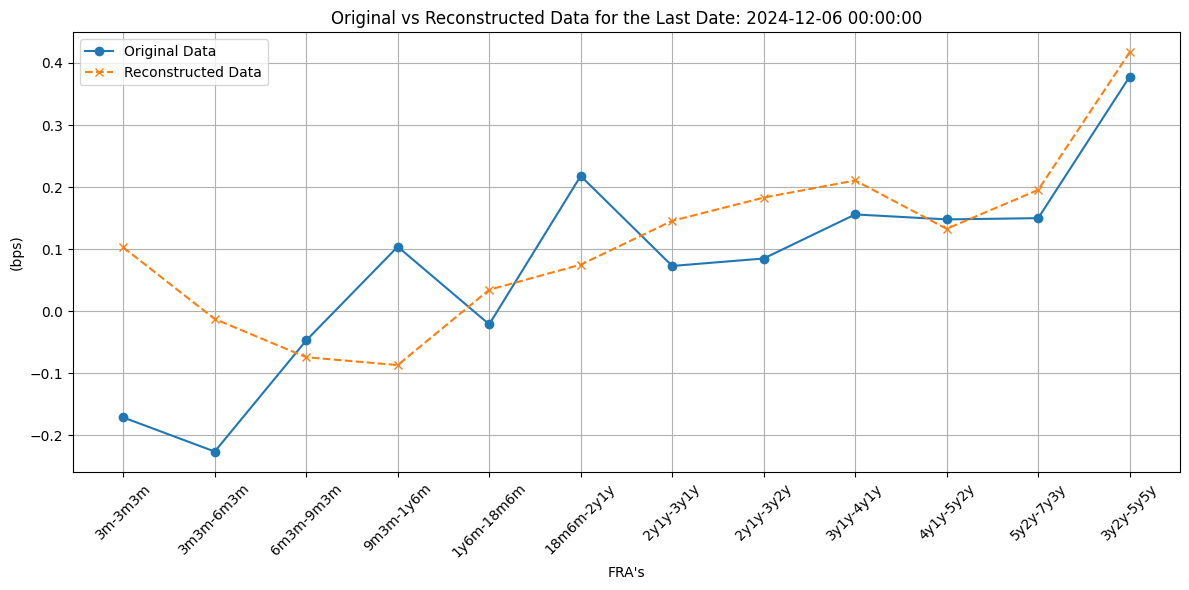

In [25]:
#Calculate 3 top PCA components of FRA curve. reconstruct dataset.
# Calculate FRA spreads and reconstructed FRA spreads for RV analysis.
# Creates 3 Dataframes: 1) df_fra_spreads 2) df_fra_spreads_reconstructed 3) residuals 4) z scores
# Saves dataframes to disk in CSV file

# Define parameters for PCA
data_points = 3800
columns = ['3m','3m3m','6m3m','9m3m','1y6m','18m6m','1y1y','2y1y','3y1y','4y1y','2y2y','3y2y','5y2y','7y3y','5y5y']
cols_fra_spreads=[['3m3m','6m3m','9m3m','1y6m','18m6m','2y1y','3y1y','4y1y','5y2y','7y3y'], 
                 ['3m','3m3m','6m3m','9m3m','1y6m','18m6m','2y1y','3y1y','4y1y','5y2y']]
# Select and scale the data
selected_data = df_cam.loc['2010-03-09':,columns] # Train using data up to end of 2021
#selected_data = df_cam[columns].tail(data_points)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(selected_data)

# Perform PCA
pca = PCA(n_components=3)
pca = pca.fit(x_scaled) #pca.components_.T will give you the loadings for each PC

# Reconstruct the dataset
x_reconstructed = pca.inverse_transform(pca.transform(x_scaled))
x_reconstructed_original_scale = scaler.inverse_transform(x_reconstructed)
df_reconstructed_original_scale = pd.DataFrame(x_reconstructed_original_scale,index=selected_data.index,columns=columns)

# Calculate residuals and z-scores for FRA's
df_residuals = selected_data - x_reconstructed_original_scale
df_z_scores = (df_residuals - df_residuals.mean()) / df_residuals.std()

#Generate FRA spreads original data
spread_col = [i+"-"+j for (i,j) in zip(cols_fra_spreads[1],cols_fra_spreads[0])]
df_fra_spreads = pd.DataFrame(selected_data[cols_fra_spreads[0]].values - selected_data[cols_fra_spreads[1]].values, 
                             index=selected_data.index,columns= spread_col)


#Generate FRA spreads reconstructed
df_fra_spreads_reconstructed =pd.DataFrame(df_reconstructed_original_scale[cols_fra_spreads[0]].values-df_reconstructed_original_scale[cols_fra_spreads[1]].values, 
                                            index=selected_data.index,columns= spread_col)

# add 3y2y-5y5y and 2y1y-3y2y Manually
df_fra_spreads['3y2y-5y5y'] = selected_data['5y5y']-selected_data['3y2y'] # add 3y2y-5y5y
df_fra_spreads_reconstructed['3y2y-5y5y'] = df_reconstructed_original_scale['5y5y']-df_reconstructed_original_scale['3y2y'] 
df_fra_spreads['2y1y-3y2y'] = selected_data['3y2y']-selected_data['2y1y'] # add 3y2y-5y5y
df_fra_spreads_reconstructed['2y1y-3y2y'] = df_reconstructed_original_scale['3y2y']-df_reconstructed_original_scale['2y1y'] 
spread_col.insert(spread_col.index("2y1y-3y1y")+1, '2y1y-3y2y')
spread_col.append('3y2y-5y5y')
#spread_col.append('2y1y-3y2y')

# Calculate residuals and z-scores for FRA's spreads
df_residuals_fra_spreads = df_fra_spreads - df_fra_spreads_reconstructed
df_z_scores_fra_spreads = (df_residuals_fra_spreads - df_residuals_fra_spreads.mean()) / df_residuals_fra_spreads.std()

#Save Data to CSV
df_reconstructed_data[columns].round(3).to_csv('df_reconstructed_data.csv', index=True) 
df_residuals[columns].round(6).to_csv('df_residuals.csv', index=True) 
df_z_scores[columns].round(6).to_csv('df_z_scores.csv', index=True) 
df_fra_spreads[spread_col].round(3).to_csv('df_fra_spreads.csv', index=True) 
df_fra_spreads_reconstructed[spread_col].round(3).to_csv('df_fra_spreads_reconstructed.csv', index=True) 
df_residuals_fra_spreads[spread_col].round(6).to_csv('df_residuals_fra_spreads.csv', index=True) 
df_z_scores_fra_spreads[spread_col].round(6).to_csv('df_z_scores_fra_spreads.csv', index=True) 


#clear form memodf_z_scoresry some data
#del x_reconstructed_original_scale,x_reconstructed
#gc.collect()
spread_col
# Plot the original and reconstructed data for the last date
plt.figure(figsize=(12, 6))
plt.plot(spread_col, df_fra_spreads[spread_col].iloc[-1], label='Original Data', marker='o')
plt.plot(spread_col, df_fra_spreads_reconstructed[spread_col].iloc[-1], label='Reconstructed Data', marker='x', linestyle='--')
plt.title(f"Original vs Reconstructed Data for the Last Date: {df_fra_spreads.index[-1]}")
plt.xlabel("FRA's")
plt.xticks(rotation=45)
plt.ylabel("(bps)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

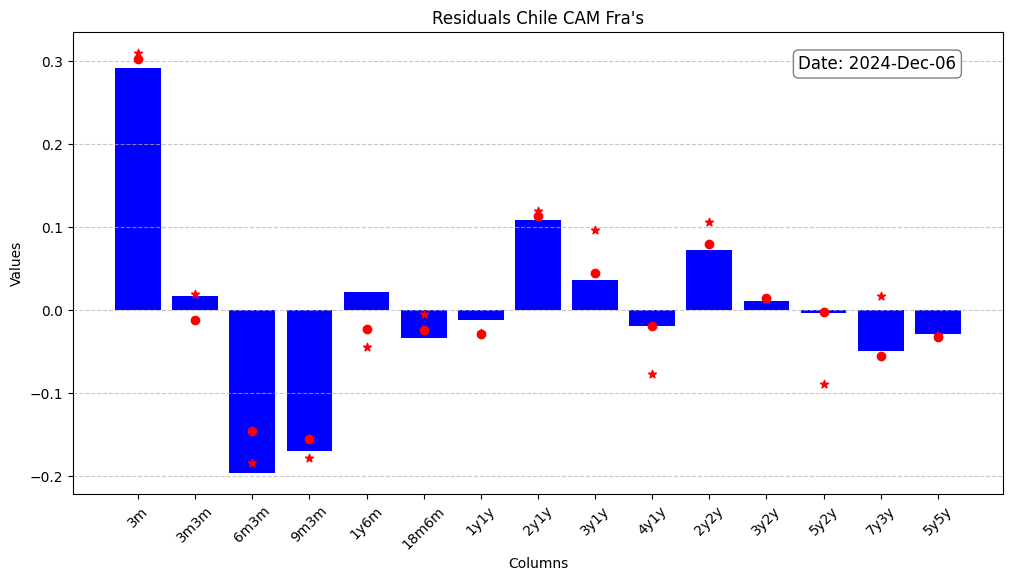

In [26]:
#Continueation of previous cell
# Plot a BAR chart of the residuals for each FRA. Add data points for value last week and 1 month ago.
# Extract the last row of the DataFrame
last_row = df_residuals.iloc[-1]
last_index = df_residuals.index[-1]
five_days_ago_row = df_residuals.iloc[-6]
one_month_ago_row = df_residuals.iloc[-21] if len(df_residuals) >= 30 else None

# Convert the index to 'yyyy-mmm-dd' format
formatted_index = pd.to_datetime(last_index).strftime('%Y-%b-%d')



# Plot a bar chart for the last row
plt.figure(figsize=(12, 6))
plt.bar(last_row.index, last_row.values, color='blue')
plt.title("Residuals Chile CAM Fra's")
plt.xlabel("Columns")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Overlay red dots for 5 days ago
plt.scatter(
    five_days_ago_row.index,
    five_days_ago_row.values,
    color='red',
    label="5 Days Ago",
    zorder=5
)

# Overlay red squares for one month ago (if available)
if one_month_ago_row is not None:
    plt.scatter(
        one_month_ago_row.index,
        one_month_ago_row.values,
        color='red',
        marker='*',
        label="1 Month Ago",
        zorder=5
    )


# Add the formatted index to the top right of the plot
plt.text(
    0.95, 0.95, f"Date: {formatted_index}",
    horizontalalignment='right',
    verticalalignment='top',
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray")
)

plt.show()

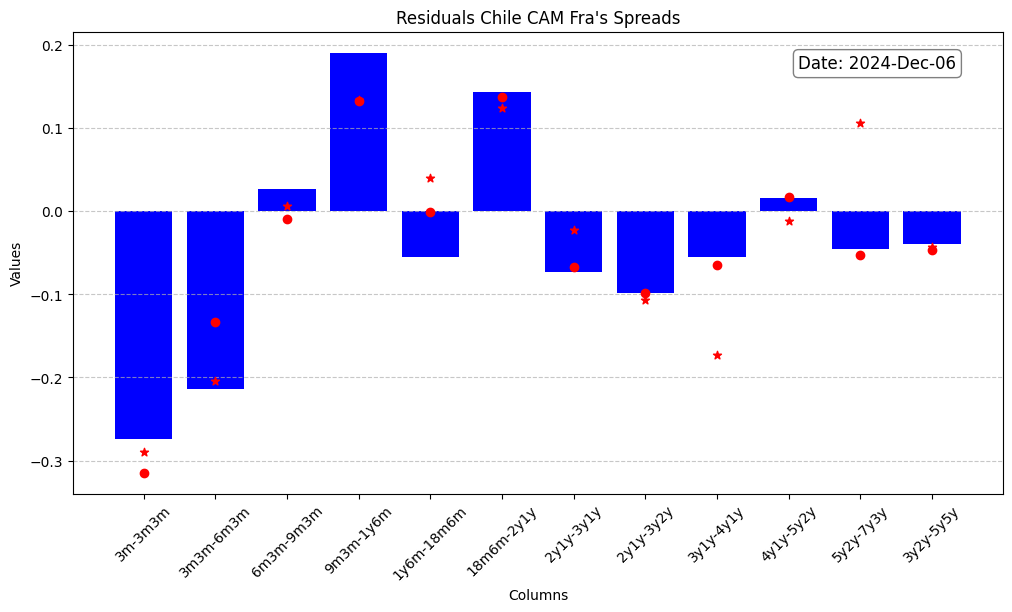

In [27]:
#Continuation of previous cell
# Plot a BAR chart of the residuals for each FRA spreads. Add data points for value last week and 1 month ago.
# Extract the last row of the DataFrame
last_row = df_residuals_fra_spreads[spread_col].iloc[-1]
last_index = df_residuals_fra_spreads[spread_col].index[-1]
five_days_ago_row = df_residuals_fra_spreads[spread_col].iloc[-6]
one_month_ago_row = df_residuals_fra_spreads[spread_col].iloc[-21] if len(df_residuals_fra_spreads) >= 30 else None

# Convert the index to 'yyyy-mmm-dd' format
formatted_index = pd.to_datetime(last_index).strftime('%Y-%b-%d')



# Plot a bar chart for the last row
plt.figure(figsize=(12, 6))
plt.bar(last_row.index, last_row.values, color='blue')
plt.title("Residuals Chile CAM Fra's Spreads")
plt.xlabel("Columns")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Overlay red dots for 5 days ago
plt.scatter(
    five_days_ago_row.index,
    five_days_ago_row.values,
    color='red',
    label="5 Days Ago",
    zorder=5
)

# Overlay red Star for one month ago (if available)
if one_month_ago_row is not None:
    plt.scatter(
        one_month_ago_row.index,
        one_month_ago_row.values,
        color='red',
        marker='*',
        label="1 Month Ago",
        zorder=5
    )


# Add the formatted index to the top right of the plot
plt.text(
    0.95, 0.95, f"Date: {formatted_index}",
    horizontalalignment='right',
    verticalalignment='top',
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray")
)

plt.show()

0.013067233634038663 0.33191783521436863 0.05812717641562653 53.04467647646365


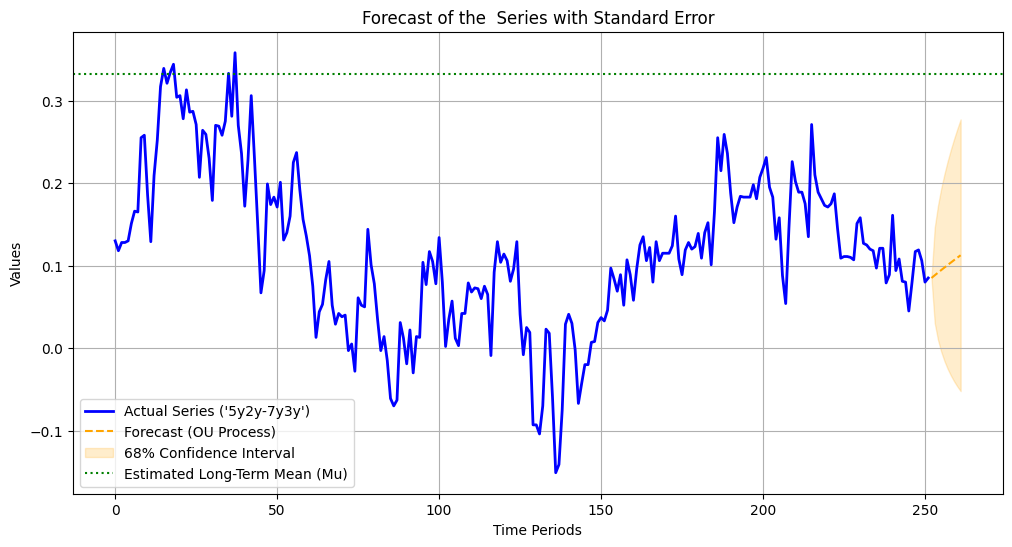

In [28]:
#Calculate Half life of Fra spread based on Ornstein-Uhlenbeck Process

from scipy.optimize import minimize

# Function to estimate OU parameters (theta, mu, sigma) using Maximum Likelihood Estimation (MLE)
def estimate_ou_params(series):
    dt = 1  # Assume time intervals are uniform and equal to 1
    
    # Define the negative log-likelihood function for the OU process
    def negative_log_likelihood(params):
        theta, mu, sigma = params
        if sigma <= 0 or theta <= 0:  # Ensure positive volatility and mean reversion speed
            return np.inf
        residuals = series[1:] - (series[:-1] + theta * (mu - series[:-1]) * dt)
        log_likelihood = -0.5 * len(residuals) * np.log(2 * np.pi * sigma**2) - np.sum(residuals**2) / (2 * sigma**2)
        return -log_likelihood  # Return negative log-likelihood
    
    # Initial guess for theta, mu, sigma
    initial_guess = [0.1, series.mean(), series.std()]
    bounds = [(1e-6, None), (None, None), (1e-6, None)]  # Ensure positive theta and sigma
    
    # Optimize the parameters
    result = minimize(negative_log_likelihood, initial_guess, bounds=bounds, method='L-BFGS-B')
    
    if result.success:
        return result.x  # Return estimated theta, mu, sigma
    else:
        raise ValueError("Optimization failed for OU parameter estimation.")

# Estimate OU parameters for the  series
spread = '2y1y-3y2y'
series = df_fra_spreads[spread].dropna().values  # Ensure the series is in numpy array format
theta, mu, sigma = estimate_ou_params(series)

# Calculate the half-life based on the estimated theta
half_life_ou = np.log(2) / theta

print(theta, mu, sigma, half_life_ou)


# Forecast the series using the Ornstein-Uhlenbeck process
def forecast_ou_process(theta, mu, sigma, X0, forecast_horizon, dt):
    forecast = np.zeros(forecast_horizon)
    std_error = np.zeros(forecast_horizon)
    forecast[0] = X0  # Start from the last observed value
    for t in range(1, forecast_horizon):
        forecast[t] = forecast[t-1] + theta * (mu - forecast[t-1]) * dt
        std_error[t] = sigma * np.sqrt((1 - np.exp(-2 * theta * t * dt)) / (2 * theta))
    return forecast, std_error

# Forecast for the next 252 periods
dt = 1
forecast_horizon = 10
X0_last = series[-1]  # Start from the last observed value of the actual series
forecast, std_error = forecast_ou_process(theta, mu, sigma, X0_last, forecast_horizon, dt)

# Time indices for plotting
time_indices = np.arange(len(series[-252:]), len(series[-252:]) + forecast_horizon)

# Plot the forecast and standard error
plt.figure(figsize=(12, 6))
plt.plot(series[-252:], label="Actual Series ('5y2y-7y3y')", color="blue", linewidth=2)
plt.plot(time_indices, forecast, label="Forecast (OU Process)", color="orange", linestyle="--")
plt.fill_between(
    time_indices,
    forecast - 1 * std_error,
    forecast + 1 * std_error,
    color="orange",
    alpha=0.2,
    label="68% Confidence Interval"
)
plt.axhline(mu, color="green", linestyle=":", label="Estimated Long-Term Mean (Mu)")
plt.title("Forecast of the  Series with Standard Error")
plt.xlabel("Time Periods")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()


In [ ]:
#Hedge exposure with PCA
# calculate dv01 per PC   Multiply dv01  by each PC; You will get the risk per PC. Sum Risks to get total risk per PC
# Choose tenor to hedge Pc1. Dv1 of hedge should be total PC1 dv01  pc1 loading. 
#For PC2 you need 2 trades to match total pc2 risk
#For PC3 you need 3 trades. to match total pc3 risk

In [ ]:
df_z_scores_fra_spreads['4y1y-5y2y'].plot()

In [ ]:
 df_cam.loc['2010-03-09':,selected_columns] 

In [ ]:
df_z_scores_fra_spreads['4y1y-5y2y'].loc[df_z_scores_fra_spreads['4y1y-5y2y'] >= 1.5].tail(20)


In [29]:
#Create Hedge ratios using PCA
data_points = 3800

columns = ['3m','3m3m','6m3m','9m3m','1y6m','18m6m','1y1y','2y1y','3y1y','4y1y','2y2y','3y2y','5y2y','7y3y','5y5y']
selected_data = df_fra_spreads.tail(data_points)
five_day_diff = selected_data.diff(periods=5).dropna()


# Step 2: Apply PCA
pca = PCA()
pca.fit(five_day_diff)

# Extract eigenvalues and eigenvectors
eigenvalues = pca.explained_variance_
eigenvectors = pd.DataFrame(pca.components_, columns=five_day_diff.columns)

# Step 3: Compute PCA hedge ratios using only the first principal component
hedge_ratios_one_component = pd.DataFrame(index=five_day_diff.columns, columns=five_day_diff.columns)

# Function to compute hedge ratio using the first component only
def compute_hedge_ratio_one_component(x, y, eigenvalues, eigenvectors):
    u1_x = eigenvectors.iloc[0][x]
    u1_y = eigenvectors.iloc[0][y]
    return u1_x / u1_y if u1_y != 0 else None

# Compute hedge ratios for each pair using the first component
for x in five_day_diff.columns:
    for y in five_day_diff.columns:
        hedge_ratios_one_component.loc[x, y] = compute_hedge_ratio_one_component(x, y, eigenvalues, eigenvectors)



hedge_ratios # Row is variable being hedged, column is variable used to hedge

NameError: name 'hedge_ratios' is not defined

In [30]:
# Compute regression-based hedge ratios
regression_hedge_ratios = pd.DataFrame(index=five_day_diff.columns, columns=five_day_diff.columns)

for x in five_day_diff.columns:
    for y in five_day_diff.columns:
        if x != y:  # Avoid self-hedging
            model = LinearRegression()
            model.fit(five_day_diff[[y]], five_day_diff[x])  # Regress x on y
            regression_hedge_ratios.loc[x, y] = model.coef_[0]
        else:
            regression_hedge_ratios.loc[x, y] = 1.0  # Self-hedging ratio is 1

regression_hedge_ratios

3m-3m3m 3m3m-6m3m 6m3m-9m3m 9m3m-1y6m 1y6m-18m6m 18m6m-2y1y  \
3m-3m3m          1.0  0.031758  0.068242  -0.16157   0.051786  -0.223676   
3m3m-6m3m   0.036115       1.0 -0.226628 -0.110186   0.058767  -0.133227   
6m3m-9m3m   0.098871 -0.288728       1.0 -0.428781  -0.036185  -0.055457   
9m3m-1y6m  -0.258688 -0.155131 -0.473841       1.0  -0.240123   0.083226   
1y6m-18m6m  0.078005  0.077838  -0.03762 -0.225902        1.0   -0.49485   
18m6m-2y1y -0.398099 -0.208507 -0.068125  0.092515  -0.584712        1.0   
2y1y-3y1y  -0.199843  -0.05429 -0.073466  0.013967  -0.020018  -0.100153   
3y1y-4y1y   0.007767 -0.040045  0.038962  0.003606  -0.011397   0.029963   
4y1y-5y2y  -0.129006 -0.142595 -0.099645  0.089536  -0.044055   0.010585   
5y2y-7y3y  -0.114539 -0.071427 -0.011491 -0.035991    0.02113   0.064796   
3y2y-5y5y  -0.176928  -0.19447 -0.081881  0.070405   -0.03195   0.059498   
2y1y-3y2y   -0.20935 -0.083321 -0.058868  0.016179  -0.031753  -0.082496   

           2y1y-3y1y 3y1y-4y1y 4y1y-5y2y 5y2y-7y3y 3y2y-5y5y 2y1y-3y2y  
3m-3m3m    -0.150661  0.005542 -0.077625 -0.096697 -0.164627 -0.176496  
3m3m-6m3m  -0.046546 -0.032496 -0.097576 -0.068575  -0.20578 -0.079884  
6m3m-9m3m  -0.080245  0.040281 -0.086871 -0.014055 -0.110384 -0.071905  
9m3m-1y6m    0.01686   0.00412   0.08626 -0.048648  0.104888  0.021839  
1y6m-18m6m -0.022732 -0.012249 -0.039929   0.02687  -0.04478 -0.040323  
18m6m-2y1y -0.134385  0.038054  0.011336  0.097359  0.098533 -0.123785  
2y1y-3y1y        1.0 -0.327401  -0.05621  0.004507 -0.293553  0.921291  
3y1y-4y1y  -0.345907       1.0  -0.46637  0.023567 -0.031295  0.182756  
4y1y-5y2y  -0.070426 -0.553057       1.0 -0.384693  0.915771 -0.378205  
5y2y-7y3y   0.004025  0.019919 -0.274189       1.0  0.209489  0.019234  
3y2y-5y5y  -0.237844    -0.024  0.592211   0.19007       1.0 -0.263249  
2y1y-3y2y   0.823847  0.154684 -0.269935   0.01926 -0.290543       1.0

In [ ]:
list(df_cam.columns)

In [ ]:
df_cam.loc['2010-03-09':,['1s2s3s','2s3s4s','3s4s5s','4s5s7s','5s7s10s']]

In [ ]:
df_cam['7y'].describe()


In [ ]:
#df_cam['4s5s7s'].describe()
df_cam.loc['2010-03-09':,'4s5s7s'].describe()

In [ ]:
all_data[fly_name].describe()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
data_points = 3800
X_factors = ['3ms1s']
y_factor = ['18s2s3s']
#make series stationary
X = df_cam[X_factors].diff(1).tail(data_points).dropna()
y = df_cam[y_factor].diff(1).tail(data_points).dropna()


X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
pred = model.predict(X)

 
print(model.summary())
print('Parameters: ',model.params)
print(model.conf_int())
print("X last:", df_cam[X_factors].tail(1))

In [ ]:
pca.explained_variance_ratio_.cumsum()

In [ ]:
df_cam['6m6m']

In [31]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

import numpy as np

def calculate_half_life(ts):
    ts_diff = np.diff(ts)
    ts_lag = ts[:-1]
    
    # Linear regression: ΔX_t = θ(μ - X_t) + noise
    A = np.vstack([ts_lag, np.ones(len(ts_lag))]).T
    theta, intercept = np.linalg.lstsq(A, ts_diff, rcond=None)[0]
    
    # Calculate half-life
    half_life = -np.log(2) / theta
    return half_life




def augmented_dickey_fuller(df):
    """
    Carry out the Augmented Dickey-Fuller test for Google data.

    Returns
    -------
    ADF
    """
    
    # The test returns several values:
    # adf_result[0] = test statistic
    # adf_result[1] = p-value
    # adf_result[2] = number of lags used
    # adf_result[3] = number of observations used
    # adf_result[4] = critical values for the test statistic
    # adf_result[5] = maximum information criterion if autolag is used (optional)
    # Output the results of the Augmented Dickey-Fuller test 
    # with a lag order value of 1
    adf = adfuller(df)
    return adf


def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts

    Parameters
    ----------
    ts : `numpy.array`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the poly fit output
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# Output the Hurst Exponent for each of the above series
# and the price of Google (the Adjusted Close price) for 
# the ADF test given above in the article
print("Hurst PC1:   %s" % hurst(x_pca_transformed[:, 0]))
print("Hurst PC2:   %s" % hurst(x_pca_transformed[:, 1]))
print("Hurst PC3:   %s" % hurst(x_pca_transformed[:, 2]))


print("ADF PC1:",augmented_dickey_fuller(x_pca_transformed[:, 0]))
print("ADF PC2:",augmented_dickey_fuller(x_pca_transformed[:, 1]))
print("ADF PC3:",augmented_dickey_fuller(x_pca_transformed[:, 2]))

# Compute half-life of mean reversion
print(f"Half Life PC1: {calculate_half_life(x_pca_transformed[:, 0])}")
print(f"Half Life PC2: {calculate_half_life(x_pca_transformed[:, 1])}")
print(f"Half Life PC3: {calculate_half_life(x_pca_transformed[:, 2])}")


Hurst PC1:   0.5180294486747702
Hurst PC2:   0.5444220156207993
Hurst PC3:   0.39032993177250813
ADF PC1: (np.float64(-2.0610601405149866), np.float64(0.2604579041121199), 26, 3816, {'1%': np.float64(-3.4320648072069777), '5%': np.float64(-2.8622977076227554), '10%': np.float64(-2.5671733375553227)}, np.float64(-2984.4084652493466))
ADF PC2: (np.float64(-3.49600708920451), np.float64(0.008090234573170684), 2, 3840, {'1%': np.float64(-3.4320540824846515), '5%': np.float64(-2.8622929701353006), '10%': np.float64(-2.567170815497504)}, np.float64(-8422.919262250958))
ADF PC3: (np.float64(-4.501745240560638), np.float64(0.00019521698477341004), 21, 3821, {'1%': np.float64(-3.4320625617721574), '5%': np.float64(-2.862296715736547), '10%': np.float64(-2.567172809512658)}, np.float64(-10897.361995744413))
Half Life PC1: 525.7616526771059
Half Life PC2: 253.61079833323578
Half Life PC3: 79.43045401680634


In [ ]:
print(adfuller(x_pca_transformed[:, 0]))

In [ ]:
pca.explained_variance_ratio_

In [ ]:
df_cam.loc['2010-03-09':,['2y1y','5y5y']].dropna().plot()

In [ ]:
loadings_original['PC1 (Level)']*-1

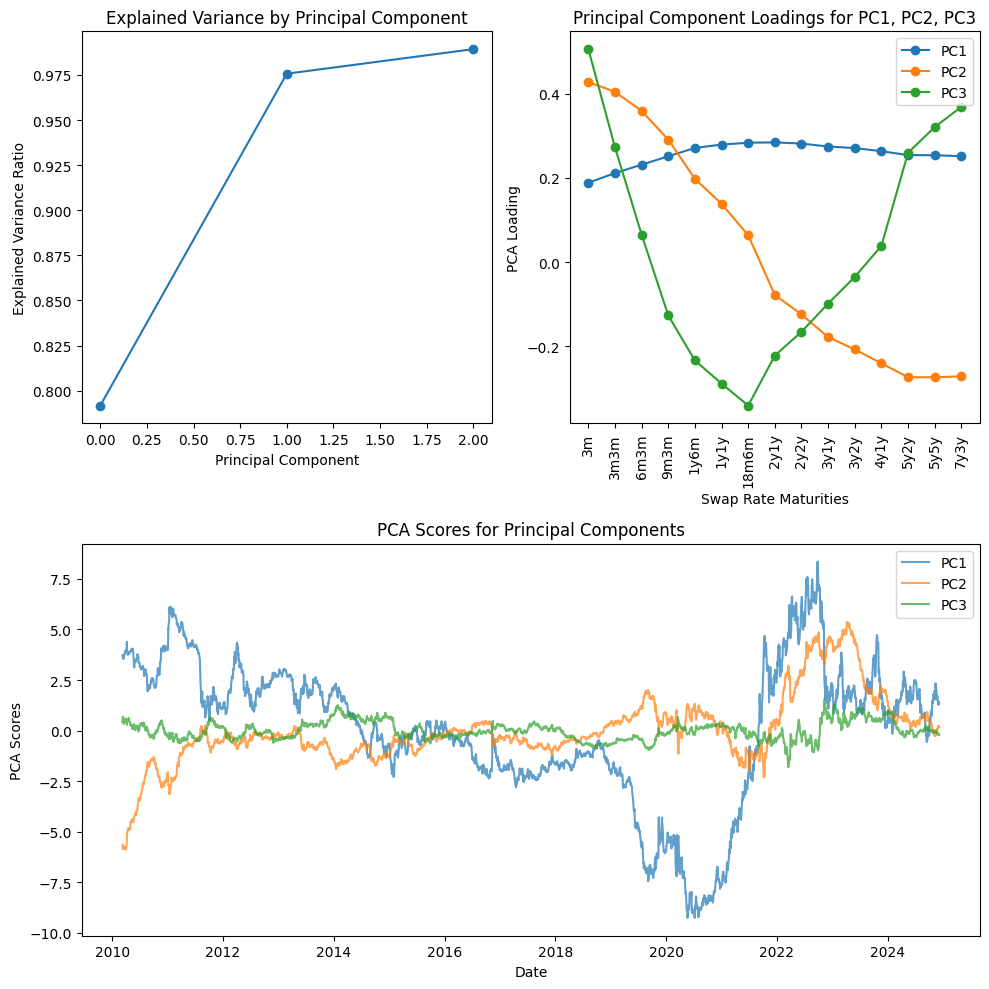

In [32]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

columns = ['3m','3m3m','6m3m','9m3m','1y6m','1y1y','18m6m','2y1y','2y2y','3y1y','3y2y','4y1y','5y2y','5y5y','7y3y']

selected_data = df_cam.loc['2010-03-09':,columns].dropna()
#selected_data = df_cam.loc['2010-03-09':'2021-12-30',columns]
x_scaled = StandardScaler().fit_transform(selected_data)

pca = PCA(n_components=3)#n_components=14
pca = pca.fit(x_scaled)


# Extract loadings dynamically for the selected columns
loadings_original = pd.DataFrame(
    pca.components_[0:3].T,
    columns=["PC1 (Level)", "PC2 (Slope)", "PC3 (Curvature)"],
    index=columns
)

loadings_original['PC1 (Level)'] = loadings_original['PC1 (Level)']*-1 #arbitrary switch in sign to match

# Create a figure and GridSpec
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2, height_ratios=[1, 1])  # 2 rows, 2 columns

# First plot (top-left)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(pca.explained_variance_ratio_.cumsum(), marker='o')
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance Ratio")
ax1.set_title("Explained Variance by Principal Component")

# Second plot (top-right)
ax2 = fig.add_subplot(gs[0, 1])
for i, pc in enumerate(pca.components_[:3], start=1):
    ax2.plot(columns, pc, marker='o', label=f'PC{i}')
ax2.set_xlabel("Swap Rate Maturities")
ax2.set_ylabel("PCA Loading")
ax2.set_title("Principal Component Loadings for PC1, PC2, PC3")
ax2.legend(loc='upper right')
ax2.tick_params(axis='x', rotation=90)

# Transform the data using PCA and plot
x_pca_transformed =pca.transform(x_scaled)

# Third plot (bottom, spanning both columns)
ax3 = fig.add_subplot(gs[1, :])  # This spans both columns in the second row
for i in range(3):
    ax3.plot(df_cam.loc['2010-03-09':, 'Date'], x_pca_transformed[:, i], alpha=0.7, label=f'PC{i+1}')
ax3.set_xlabel("Date")
ax3.set_ylabel("PCA Scores")
ax3.set_title("PCA Scores for Principal Components")
ax3.legend(loc='upper right')


# Adjust layout and show
plt.tight_layout()
plt.show()


   Maturities     delta
0          3m -0.144286
1          6m -0.115000
2          9m -0.087793
3          1y -0.069176
4         18m -0.063250
5          2y -0.070000
6          3y -0.090503
7          4y -0.117919
8          5y -0.140000
9          6y -0.155763
10         7y -0.169503
11         8y -0.180002
12         9y -0.187675
13        10y -0.191831


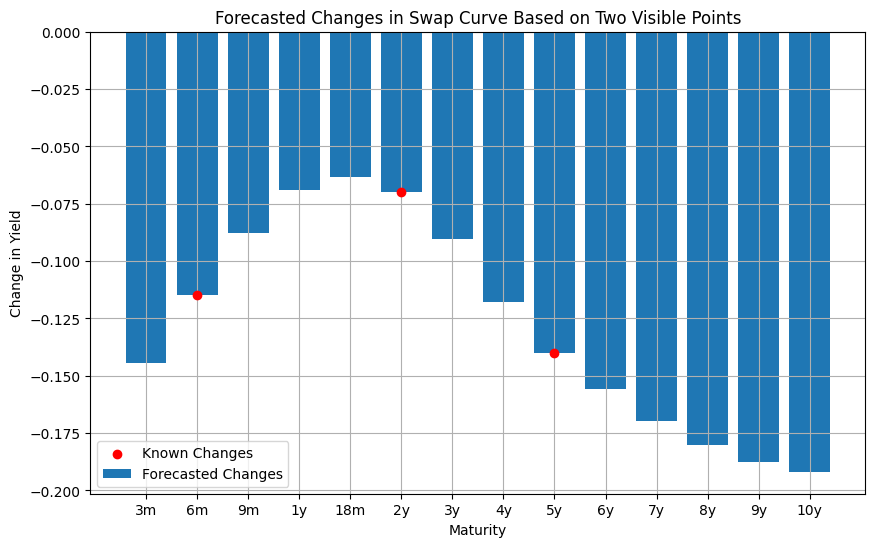

   Maturities Last Known Curve  Forecasted Change Forecasted Curve
0          3m              5.2          -0.144286         5.055714
1          6m             5.13          -0.115000            5.015
2          9m            5.025          -0.087793         4.937207
3          1y             4.97          -0.069176         4.900824
4         18m             4.96          -0.063250          4.89675
5          2y            4.855          -0.070000            4.785
6          3y             4.91          -0.090503         4.819497
7          4y            4.975          -0.117919         4.857081
8          5y            5.025          -0.140000            4.885
9          6y             5.07          -0.155763         4.914237
10         7y            5.135          -0.169503         4.965497
11         8y             5.18          -0.180002         4.999998
12         9y            5.235          -0.187675         5.047325
13        10y            5.285          -0.191831         5.09

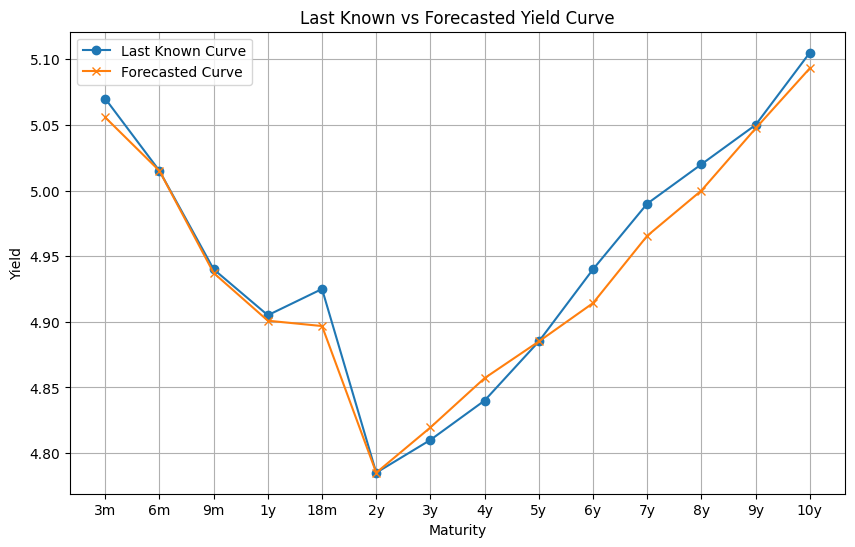

In [33]:
#Make a forecast for 20 periods ahead based on 3 curve points. PCA done on changes


#columns = ['3m3m','6m3m','9m3m','1y6m','18m6m','1y1y','2y1y','3y1y','4y1y','2y2y','3y2y','5y2y','7y3y','5y5y']
columns =   ['3m', '6m', '9m', '1y', '18m', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y']
#columns =  ['2y','3y','4y','5y','6y','7y','8y','9y','10y']
#columns = ['3m3m','6m6m','1y1y','2y1y','3y1y','4y1y','5y1y','6y1y','7y1y','8y1y','9y1y']
#df_cam.loc['2010-03-09':,'Date']
start_date,end_date = ['2010-03-09','2024-11-11']
x_scaled = StandardScaler().fit_transform(df_cam.loc[start_date:end_date,columns].diff(20).dropna())

pca = PCA(n_components=3)#n_components=14
pca = pca.fit(x_scaled)

df_cam['Date'] = df_cam.index

# Extract loadings for Exhibit 5
loadings_original = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2)", "PC3"],
    index=columns)

x_pca_transformed =pca.transform(x_scaled)

# Example: Calculate curve changes based on two visible points
known_points = ['6m', '2y','5y']  # Define visible points
known_indices = [columns.index(m) for m in known_points]
delta_y_known = np.array([-.115, -.07,-.14])  # Example changes for 2y and 5y maturities

# Extract loadings for known points
loadings_known = loadings_original.iloc[known_indices].values  # Shape: (3, 3)

# Solve for PC scores using pseudo-inverse
scores = np.linalg.pinv(loadings_known) @ delta_y_known

# Reconstruct the changes for the entire curve
delta_y_full = np.dot(loadings_original, scores)

# Convert to DataFrame for visualization
forecasted_changes_df = pd.DataFrame({
    'Maturities': columns,
    'delta': delta_y_full
})

# Print the forecasted changes
print(forecasted_changes_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(columns, delta_y_full, label='Forecasted Changes')
plt.scatter(known_points, delta_y_known, color='red', label='Known Changes', zorder=5)
plt.xlabel('Maturity')
plt.ylabel('Change in Yield')
plt.title('Forecasted Changes in Swap Curve Based on Two Visible Points')
plt.legend()
plt.grid(True)
plt.show()

# Get the last known curve values
last_known_curve = df_cam.loc[end_date, columns].values

# Add the forecasted changes to the last known curve
forecasted_curve = last_known_curve + delta_y_full

# Convert to DataFrame for visualization
forecasted_curve_df = pd.DataFrame({
    'Maturities': columns,
    'Last Known Curve': last_known_curve,
    'Forecasted Change': delta_y_full,
    'Forecasted Curve': forecasted_curve
})

# Print the forecasted curve with changes
print(forecasted_curve_df)

# Plot the original and forecasted curves
plt.figure(figsize=(10, 6))
plt.plot(columns, df_cam[columns].loc['2024-12-06'].values, marker='o', label='Last Known Curve')
plt.plot(columns, forecasted_curve, marker='x', label='Forecasted Curve')
plt.xlabel('Maturity')
plt.ylabel('Yield')
plt.title('Last Known vs Forecasted Yield Curve')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:

np.round(((forecasted_curve-df_cam[columns].loc['2024-12-06'].values)*100).astype(float).astype(float), 2)

In [ ]:
df_cam[['6m','2y','5y']].loc['2024-12-06']

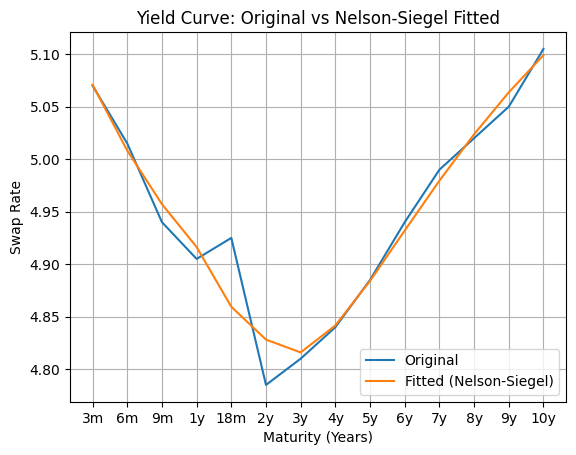

In [34]:
#Nelson Siegel Estimation with Ridge Regression
from sklearn.linear_model import Ridge
from scipy.optimize import minimize

start_date,end_date = ['2010-03-09','2024-12-06']
columns=['3m','6m','9m','1y','18m','2y','3y','4y','5y','6y','7y','8y','9y','10y']
# Assuming df_cam is your dataframe with swap rate data
maturities = np.array([0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Convert maturity labels to years
swap_rates = df_cam.loc[start_date:end_date,columns].dropna().values  # Convert dataframe to numpy array

# Nelson-Siegel basis functions
def nelson_siegel(t, beta0, beta1, beta2, tau):
    """ Nelson-Siegel formula for yield curve. """
    term1 = beta0
    term2 = beta1 * (1 - np.exp(-t / tau)) / (t / tau)
    term3 = beta2 * ((1 - np.exp(-t / tau)) / (t / tau) - np.exp(-t / tau))
    return term1 + term2 + term3

# Objective function to fit the Nelson-Siegel parameters
def ns_objective(params, x, y):
    beta0, beta1, beta2, tau = params
    y_pred = nelson_siegel(x, beta0, beta1, beta2, tau)
    return np.sum((y - y_pred) ** 2)

# Ridge regression for Nelson-Siegel estimation
ridge_alpha = 1  # Regularization strength
ridge = Ridge(alpha=ridge_alpha)

# Store results
ns_params = []

# Fit the Nelson-Siegel model for each time step
for i in range(swap_rates.shape[0]):
    y = swap_rates[i, :]  # Rates at a specific time step
    # Initial guesses for the parameters
    initial_guess = [5, 1.5, 1, 1.0]  # beta0, beta1, beta2, tau

    # Use scipy.optimize to minimize the objective function
    bounds = [(None, None), (None, None), (None, None), (0.01, None)]  # tau > 0
    result = minimize(ns_objective, initial_guess, args=(maturities, y), bounds=bounds)

    # Save the fitted parameters
    if result.success:
        ns_params.append(result.x)
    else:
        ns_params.append([np.nan, np.nan, np.nan, np.nan])

# Convert to DataFrame
ns_params_df = pd.DataFrame(ns_params, columns=['Beta0', 'Beta1', 'Beta2', 'Tau'])

# Example: Plotting the original vs fitted yield curve for the first row
fitted_curve = nelson_siegel(maturities, *ns_params[-1])
plt.plot(columns, swap_rates[-1], label='Original')
plt.plot(columns, fitted_curve, label='Fitted (Nelson-Siegel)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Swap Rate')
plt.title('Yield Curve: Original vs Nelson-Siegel Fitted')
plt.legend()
plt.grid(True)
plt.show()

          Beta0      Beta1      Beta2        Tau
0     -9.269458   9.127380  34.864328   7.630241
1    -18.774337  18.631115  48.627813   9.297757
2    -20.691847  20.544195  51.308979   9.569974
3    -32.434654  32.294752  67.132851  11.230669
4    -34.051337  33.905137  69.162171  11.380305
...         ...        ...        ...        ...
3838   5.506899  -0.290343  -1.920229   2.052848
3839   5.569591  -0.410805  -1.864449   2.143234
3840   5.503793  -0.318416  -1.802433   2.040270
3841   5.532123  -0.328932  -1.781189   2.076424
3842   5.490619  -0.343262  -1.685676   1.998881

[3843 rows x 4 columns]


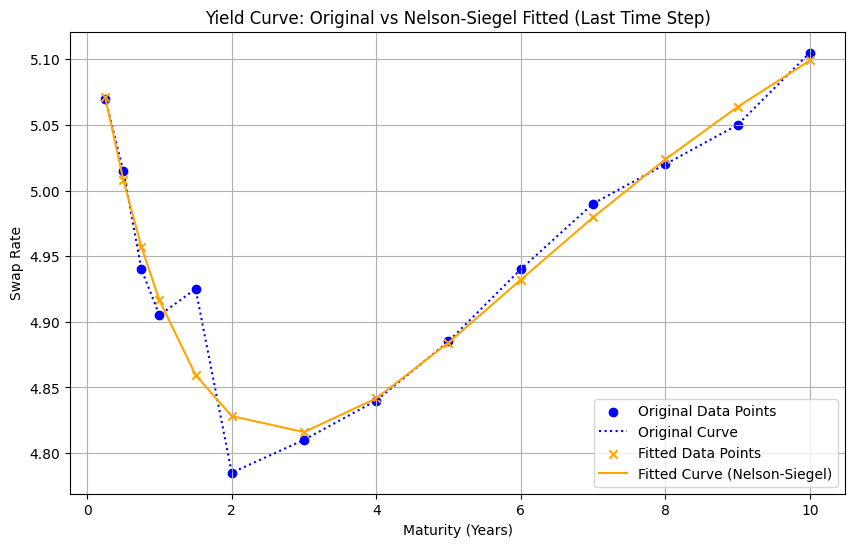

In [36]:
#Nelson Siegel




# Assuming df_cam is your dataframe with swap rate data
maturities = np.array([0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Convert maturity labels to years
swap_rates = df_cam.loc[start_date:end_date,columns].dropna().values  # Convert dataframe to numpy array

# Nelson-Siegel basis functions
def nelson_siegel(t, beta0, beta1, beta2, tau):
    """ Nelson-Siegel formula for yield curve. """
    term1 = beta0
    term2 = beta1 * (1 - np.exp(-t / tau)) / (t / tau)
    term3 = beta2 * ((1 - np.exp(-t / tau)) / (t / tau) - np.exp(-t / tau))
    return term1 + term2 + term3

# Objective function to fit the Nelson-Siegel parameters
def ns_objective(params, x, y):
    beta0, beta1, beta2, tau = params
    y_pred = nelson_siegel(x, beta0, beta1, beta2, tau)
    return np.sum((y - y_pred) ** 2)

# Store results
ns_params = []

# Fit the Nelson-Siegel model for each time step
for i in range(swap_rates.shape[0]):
    y = swap_rates[i, :]  # Rates at a specific time step
    # Initial guesses for the parameters
    initial_guess = [5, 1.5, 1, 1.0]  # beta0, beta1, beta2, tau

    # Use scipy.optimize to minimize the objective function
    bounds = [(None, None), (None, None), (None, None), (0.01, None)]  # tau > 0
    result = minimize(ns_objective, initial_guess, args=(maturities, y), bounds=bounds)

    # Save the fitted parameters
    if result.success:
        ns_params.append(result.x)
    else:
        ns_params.append([np.nan, np.nan, np.nan, np.nan])

# Convert to DataFrame
ns_params_df = pd.DataFrame(ns_params, columns=['Beta0', 'Beta1', 'Beta2', 'Tau'])

# Display summary of fitted parameters
print(ns_params_df)

# Example: Plotting the original vs fitted yield curve for the last row
fitted_curve = nelson_siegel(maturities, *ns_params[-1])
original_curve = swap_rates[-1]

plt.figure(figsize=(10, 6))
plt.scatter(maturities, original_curve, color='blue', label='Original Data Points', marker='o')
plt.plot(maturities, original_curve, color='blue', linestyle='dotted', label='Original Curve')
plt.scatter(maturities, fitted_curve, color='orange', label='Fitted Data Points', marker='x')
plt.plot(maturities, fitted_curve, color='orange', linestyle='solid', label='Fitted Curve (Nelson-Siegel)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Swap Rate')
plt.title('Yield Curve: Original vs Nelson-Siegel Fitted (Last Time Step)')
plt.legend()
plt.grid(True)
plt.show()



In [37]:
columns = ['3m', '6m', '9m', '1y', '18m', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y', 
           '3ms6ms', '3ms9ms', '3ms1s', '6ms9ms', '6ms1s', '9ms1s', '1s18s', '18s2s', '1s2s', 
           '2s3s', '3s4s', '4s5s', '5s6s', '6s7s', '7s8s', '8s9s', '9s10s', '2s5s', '5s7s', 
           '3s5s', '7s10s', '5s10s', '2s10s', '1y1y', '2y1y', '3y1y', '4y1y', '5y1y', '6y1y', 
           '7y1y', '8y1y', '9y1y', '1y2y', '2y2y', '3y2y', '4y2y', '5y2y', '6y2y', '7y2y', '8y2y', 
           '1y3y', '2y3y', '3y3y', '4y3y', '5y3y', '6y3y', '7y3y', '3m3m', '6m3m', '9m3m', '6m6m', 
           '1y6m', '18m6m', '5y5y', '3m3m-3m', '6m3m-3m3m', '9m3m-6m3m', '1y6m-9m3m', '18m6m-1y6m', 
           '2y1y-18m6m', '3y1y-2y1y', '4y1y-3y1y', '5y2y-4y1y', '7y3y-5y2y', '2s5s10s', '2s5s7s', 
           '3s5s7s', '5s7s10s', '1s2s3s', '1s18s2s', '3s4s5s', '2s4s', '3s10s', '6ms2s', '9ms2s', 
           '3ms1y', '1s3s', '1s4s', '1s5s', '2s7s', '3s7s', '5s8s', '6s8s', '4s10s', '2s3s5s', '3s5s10s', 
           '2s3s4s', '18s2s3s', '3m6m9m', '6m9m18s', '9m1s18s', '6m9m1s', '3m6m1s', '4s5s7s', '9m1s5s', 
           '5s6s8s', '8s9s10s', '4s5s10s', '9m1s2s', '5y5y-3y2y', '5y5y-2y1y', '1y6m-6m3m', '6y2y-4y1y', 
           '5y5y-2y2y', '5y5y-1y1y', '6y2y-5y1y', '4y1y-1y1y', '5y5y-4y1y', '9y1y-8y1y', '3y2y-1y1y', 
           '3y2y-2y1y', '5y2y-3y2y', '7y3y-3y1y', '5y5y-3y1y', '5y2y-2y1y', '1y1y-9m3m']

start_date,end_date = ['2010-03-09','2019-12-30']

df_cam_rolling_cov = df_cam.loc[start_date:end_date,columns].diff(5).dropna().cov()
df_cam_rolling_var = df_cam.loc[start_date:end_date,columns].diff(5).dropna().var()
df_cam_betas = df_cam_rolling_cov/df_cam_rolling_var

Text(0.5, 1.0, 'Swap Spread Betas Heatmap')

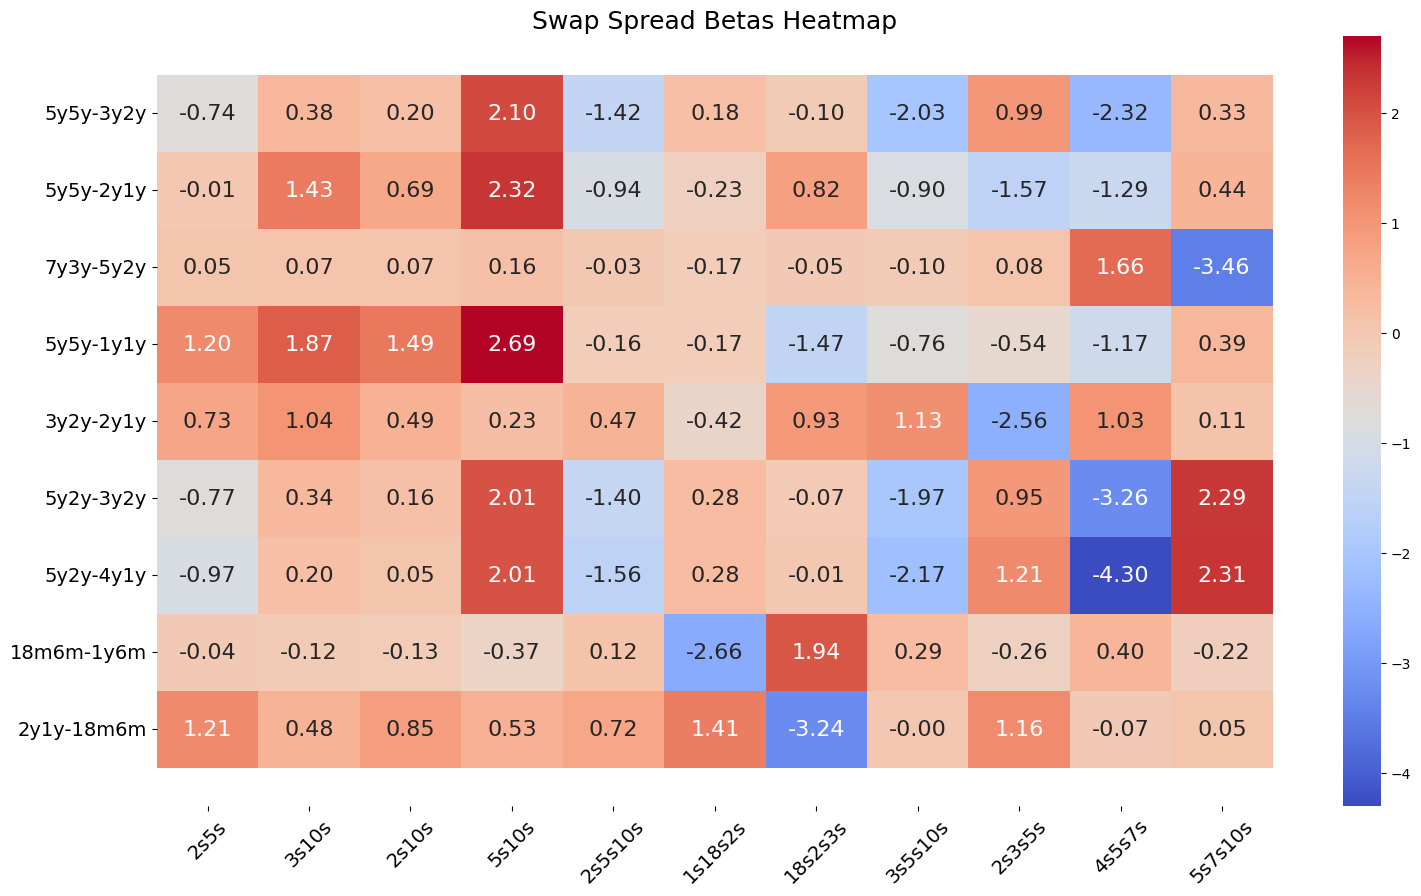

In [38]:
rows1 = ['5y5y-3y2y', '5y5y-2y1y','7y3y-5y2y', '5y5y-1y1y',
          '3y2y-2y1y', '5y2y-3y2y','5y2y-4y1y','18m6m-1y6m','2y1y-18m6m']

cols1 = ['2s5s','3s10s','2s10s','5s10s','2s5s10s','1s18s2s','18s2s3s','3s5s10s','2s3s5s','4s5s7s','5s7s10s']

df_cam_betas['5y5y-4y1y']
df_cam_betas['5y5y-4y1y'].sort_values(ascending=False).head(8)
df_cam_betas.loc[rows1,cols1]

fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(df_cam_betas.loc[rows1, cols1], ax=ax, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 16})  # Increased font size
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45)  # Rotate x labels for better readability
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
bottom, top = ax.get_ylim() #adjustment to top and bottom cells dont cut off
ax.set_ylim(bottom + 0.5, top - 0.5) #adjustment to top and bottom cells dont cut off
ax.set_title('Swap Spread Betas Heatmap', fontsize=18)




Text(0.5, 1.0, 'Swap Spreads Correlation Heatmap')

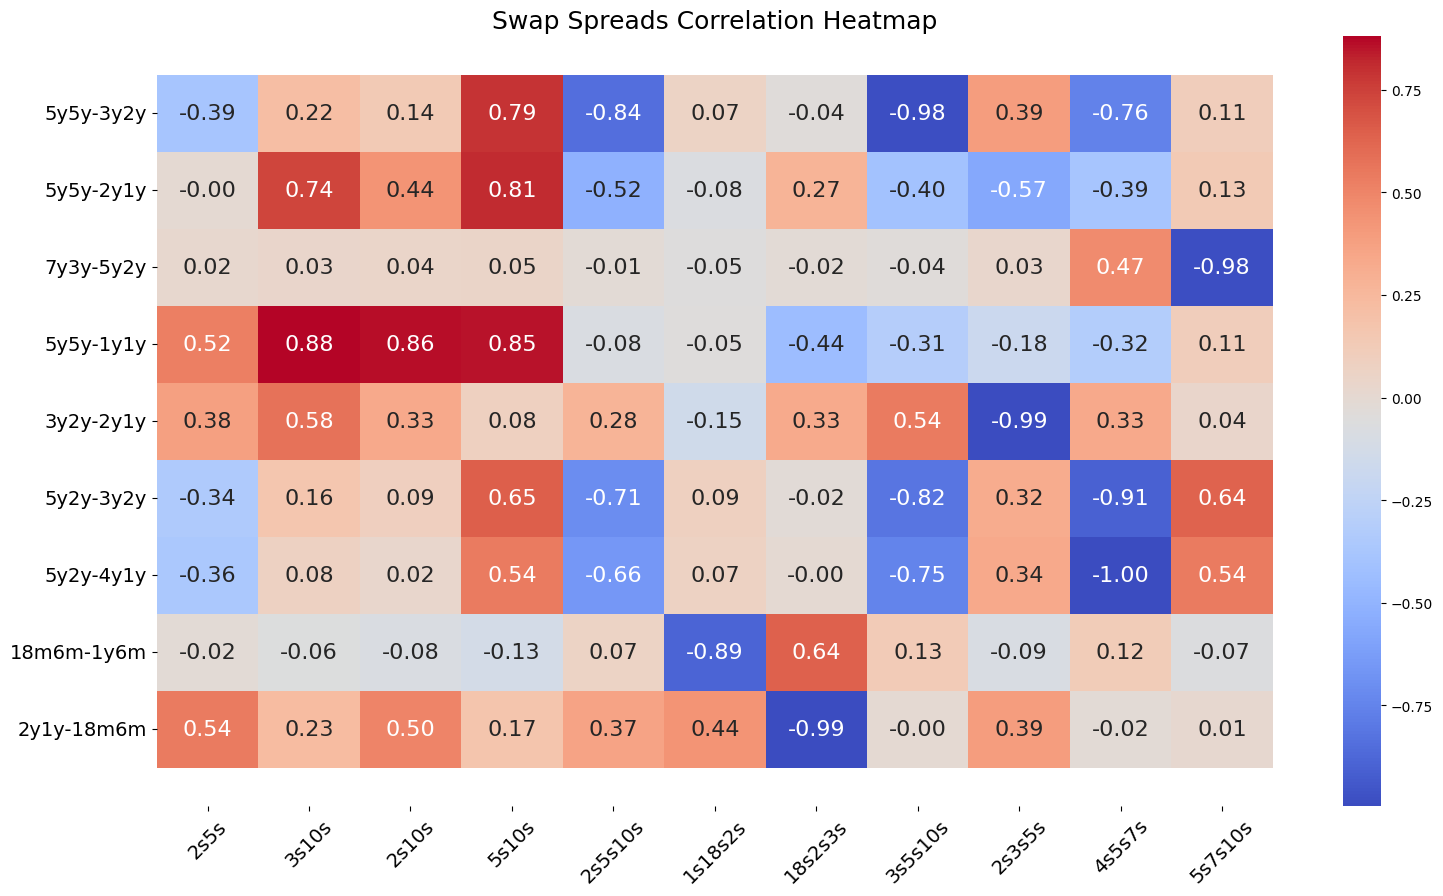

In [39]:
#Generate Correlation Heat Map
df_correlations =  df_cam.loc[start_date:end_date,columns].diff(5).corr(method='pearson')
fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(df_correlations.loc[rows1,cols1], ax=ax, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 16}) #spearman
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45)  # Rotate x labels for better readability
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
bottom, top = ax.get_ylim() #adjustment to top and bottom cells dont cut off
ax.set_ylim(bottom + 0.5, top - 0.5) #adjustment to top and bottom cells dont cut off
ax.set_title('Swap Spreads Correlation Heatmap', fontsize=18)

In [40]:
#GEnerate ZSCORES

def get_zscores(df,columns,datapoints):
    df_zscores = pd.DataFrame(data=stats.zscore(df[columns].tail(datapoints)),columns=columns,index=df.tail(datapoints).index)
    return  df_zscores

#columns = ['18m6m','2y1y','3y1y','4y1y','5y2y','7y3y','5y5y','6y2y','2y2y','3y1y-2y1y',
          # '4y1y-3y1y','5y2y-4y1y','7y3y-5y2y','6y2y-5y1y','5y5y-4y1y','5y2y-3y2y','5y5y-3y2y','5y5y-1y1y', 
          #'6m3m-3m3m','9m3m-6m3m','1y6m-9m3m','18m6m-1y6m','2s5s10s','3s5s10s','1s18s2s','18s2s3s','2s3s4s', 
         # '3s4s5s','4s5s7s','5s7s10s','1s2s3s']

columns = ['3m', '6m', '9m', '1y', '18m', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y', 
           '3ms6ms', '3ms9ms', '3ms1s', '6ms9ms', '6ms1s', '9ms1s', '1s18s', '18s2s', '1s2s', 
           '2s3s', '3s4s', '4s5s', '5s6s', '6s7s', '7s8s', '8s9s', '9s10s', '2s5s', '5s7s', 
           '3s5s', '7s10s', '5s10s', '2s10s', '1y1y', '2y1y', '3y1y', '4y1y', '5y1y', '6y1y', 
           '7y1y', '8y1y', '9y1y', '1y2y', '2y2y', '3y2y', '4y2y', '5y2y', '6y2y', '7y2y', '8y2y', 
           '1y3y', '2y3y', '3y3y', '4y3y', '5y3y', '6y3y', '7y3y', '3m3m', '6m3m', '9m3m', '6m6m', 
           '1y6m', '18m6m', '5y5y', '3m3m-3m', '6m3m-3m3m', '9m3m-6m3m', '1y6m-9m3m', '18m6m-1y6m', 
           '2y1y-18m6m', '3y1y-2y1y', '4y1y-3y1y', '5y2y-4y1y', '7y3y-5y2y', '2s5s10s', '2s5s7s', 
           '3s5s7s', '5s7s10s', '1s2s3s', '1s18s2s', '3s4s5s', '2s4s', '3s10s', '6ms2s', '9ms2s', 
           '3ms1y', '1s3s', '1s4s', '1s5s', '2s7s', '3s7s', '5s8s', '6s8s', '4s10s', '2s3s5s', '3s5s10s', 
           '2s3s4s', '18s2s3s', '3m6m9m', '6m9m18s', '9m1s18s', '6m9m1s', '3m6m1s', '4s5s7s', '9m1s5s', 
           '5s6s8s', '8s9s10s', '4s5s10s', '9m1s2s', '5y5y-3y2y', '5y5y-2y1y', '1y6m-6m3m', '6y2y-4y1y', 
           '5y5y-2y2y', '5y5y-1y1y', '6y2y-5y1y', '4y1y-1y1y', '5y5y-4y1y', '9y1y-8y1y', '3y2y-1y1y', 
           '3y2y-2y1y', '5y2y-3y2y', '7y3y-3y1y', '5y5y-3y1y', '5y2y-2y1y', '1y1y-9m3m']


#calculate zscores and print as column
data_points = 60

df_zscores=get_zscores(df_cam,columns,data_points)
print(df_zscores.sort_values(ascending=True,axis=1,by='2024-12-06').tail(1).transpose())

print((df_zscores[(df_zscores[columns]<-2) | (df_zscores[columns]>2) ].tail(1)).transpose().dropna())


Date       2024-12-06
3m          -2.867768
7s8s        -1.824876
7y3y-5y2y   -1.819995
7s10s       -1.658497
3y2y-1y1y   -1.631312
...               ...
3ms6ms       1.272671
5s6s8s       1.294235
3m3m-3m      1.316375
5s7s10s      1.775117
1s18s2s      1.845395

[130 rows x 1 columns]
Date  2024-12-06
3m     -2.867768


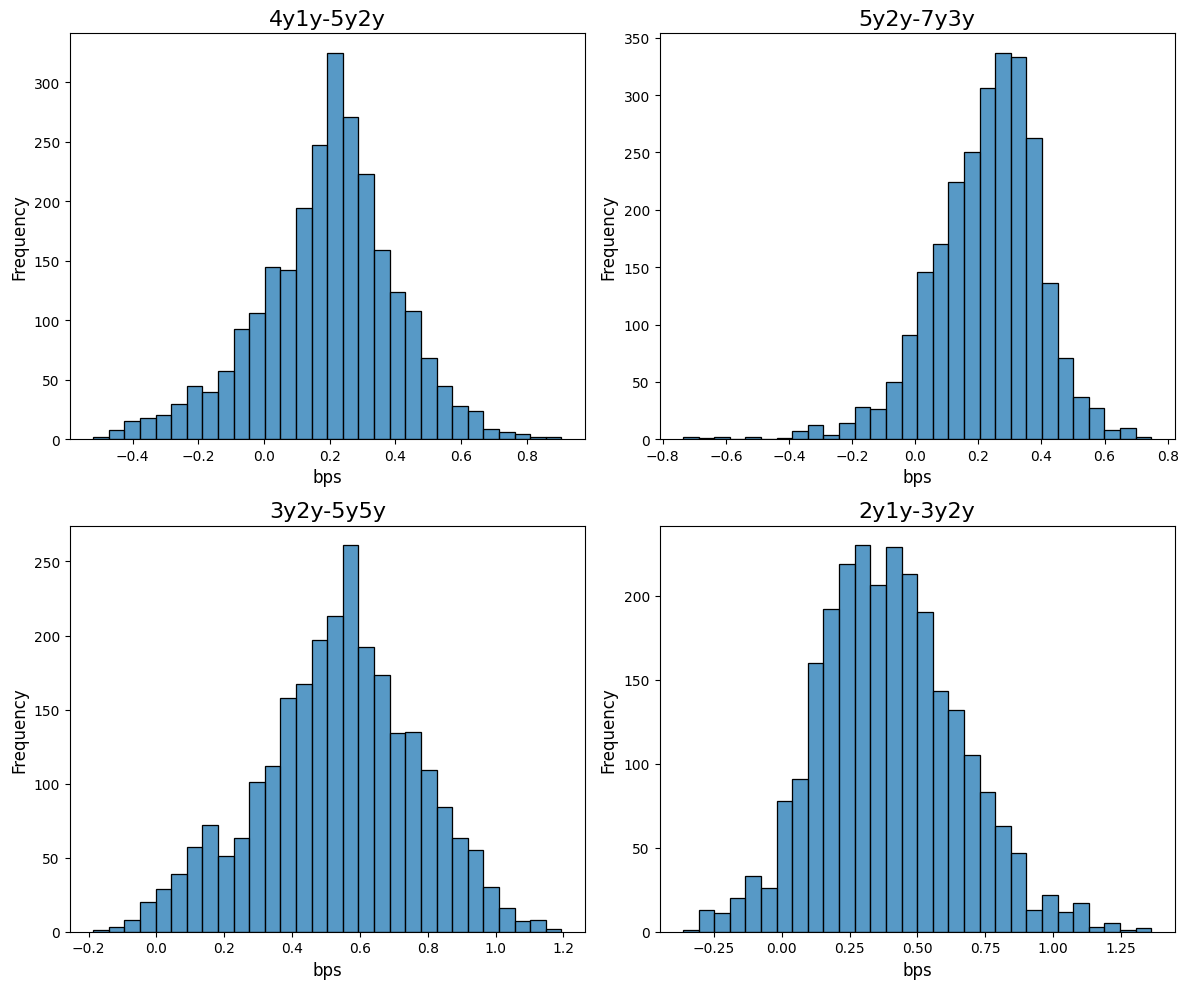

Date
2024-12-06    0.085
Name: 3y2y-2y1y, dtype: float64
Mean:  0.19186914062500002 5y2y-4y1y
Mean:  0.224959375 7y3y-5y2y
Mean:  0.5338968749999999 5y5y-3y2y
Mean:  0.39526796875 3y2y-2y1y


In [41]:
###Graph histograms of major FRA spreads

factors = ['5y2y-4y1y', '7y3y-5y2y', '5y5y-3y2y', '3y2y-2y1y']
factors2 = ['4y1y-5y2y', '5y2y-7y3y', '3y2y-5y5y', '2y1y-3y2y']
start_date,end_date = ['2010-03-09','2019-12-30']
fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 
axes = axes.flatten()
for i, factor in enumerate(factors):
    sns.histplot(df_cam.loc[start_date:end_date, factor].dropna().values, ax=axes[i], bins=30)
    axes[i].set_title(factors2[i], fontsize=16) 
    axes[i].set_xlabel("bps",fontsize=12)
    axes[i].set_ylabel("Frequency",fontsize=12)
plt.tight_layout()
plt.show()
print(df_cam[factor].tail(1))
for i in factors:
    print("Mean: ",df_cam.loc[start_date:end_date,i].mean(),i)
#print("Last observations#:",datapoints)

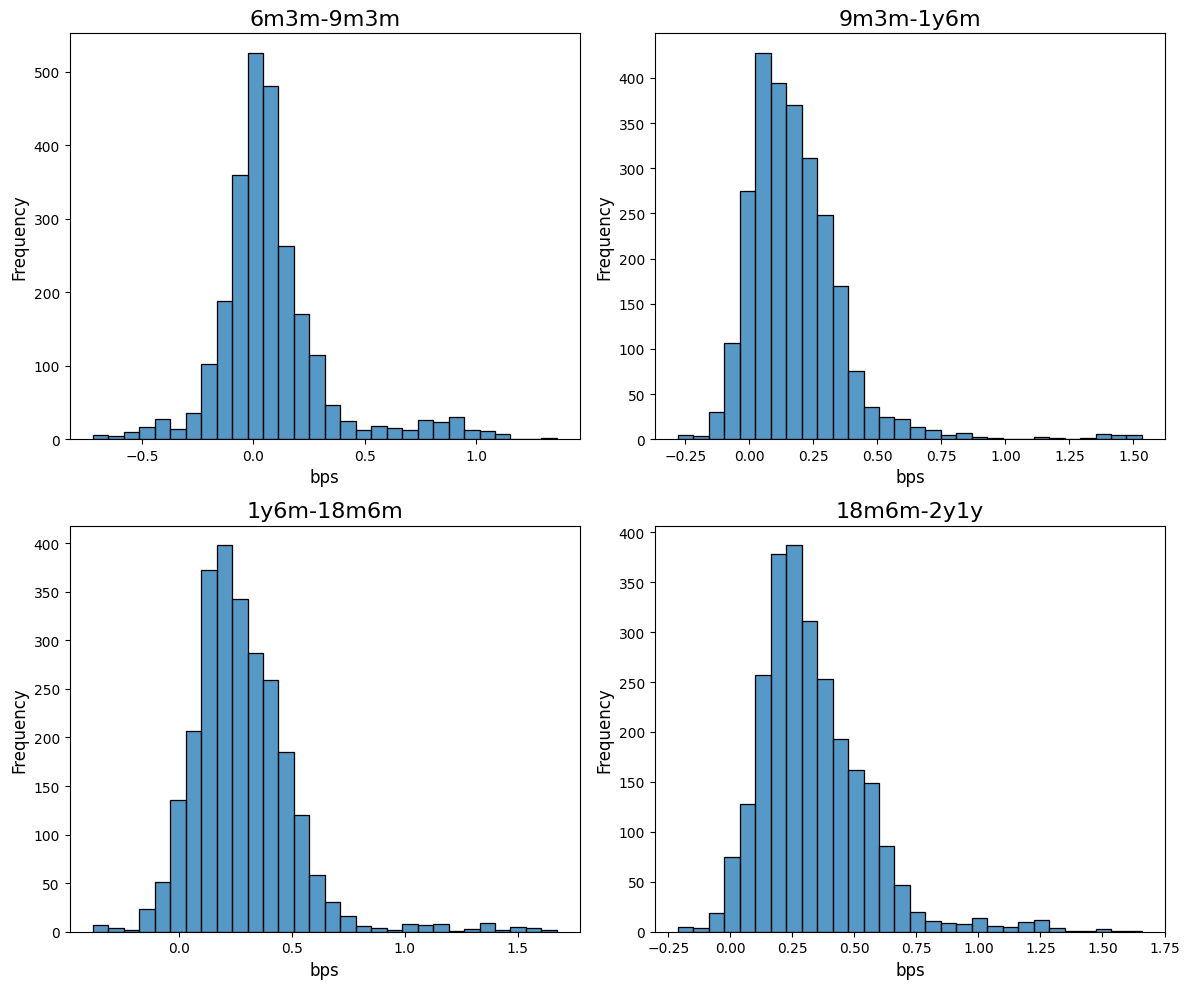

Mean:  0.07782851562500001 9m3m-6m3m
Mean:  0.17770976562500002 1y6m-9m3m
Mean:  0.28082031250000006 18m6m-1y6m
Mean:  0.334644140625 2y1y-18m6m


In [42]:
###Graph histograms of major FRA spreads short end

factors = ['9m3m-6m3m', '1y6m-9m3m', '18m6m-1y6m', '2y1y-18m6m']
factors2 = ['6m3m-9m3m', '9m3m-1y6m', '1y6m-18m6m', '18m6m-2y1y']
start_date,end_date = ['2010-03-09','2019-12-30']
fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 
axes = axes.flatten()
for i, factor in enumerate(factors):
    sns.histplot(df_cam.loc[start_date:end_date, factor].dropna().values, ax=axes[i], bins=30)
    axes[i].set_title(factors2[i], fontsize=16) 
    axes[i].set_xlabel("bps",fontsize=12)
    axes[i].set_ylabel("Frequency",fontsize=12)
plt.tight_layout()
plt.show()
for i in factors:
    print("Mean: ",df_cam.loc[start_date:end_date,i].mean(),i)
#print("Last observations#:",datapoints)

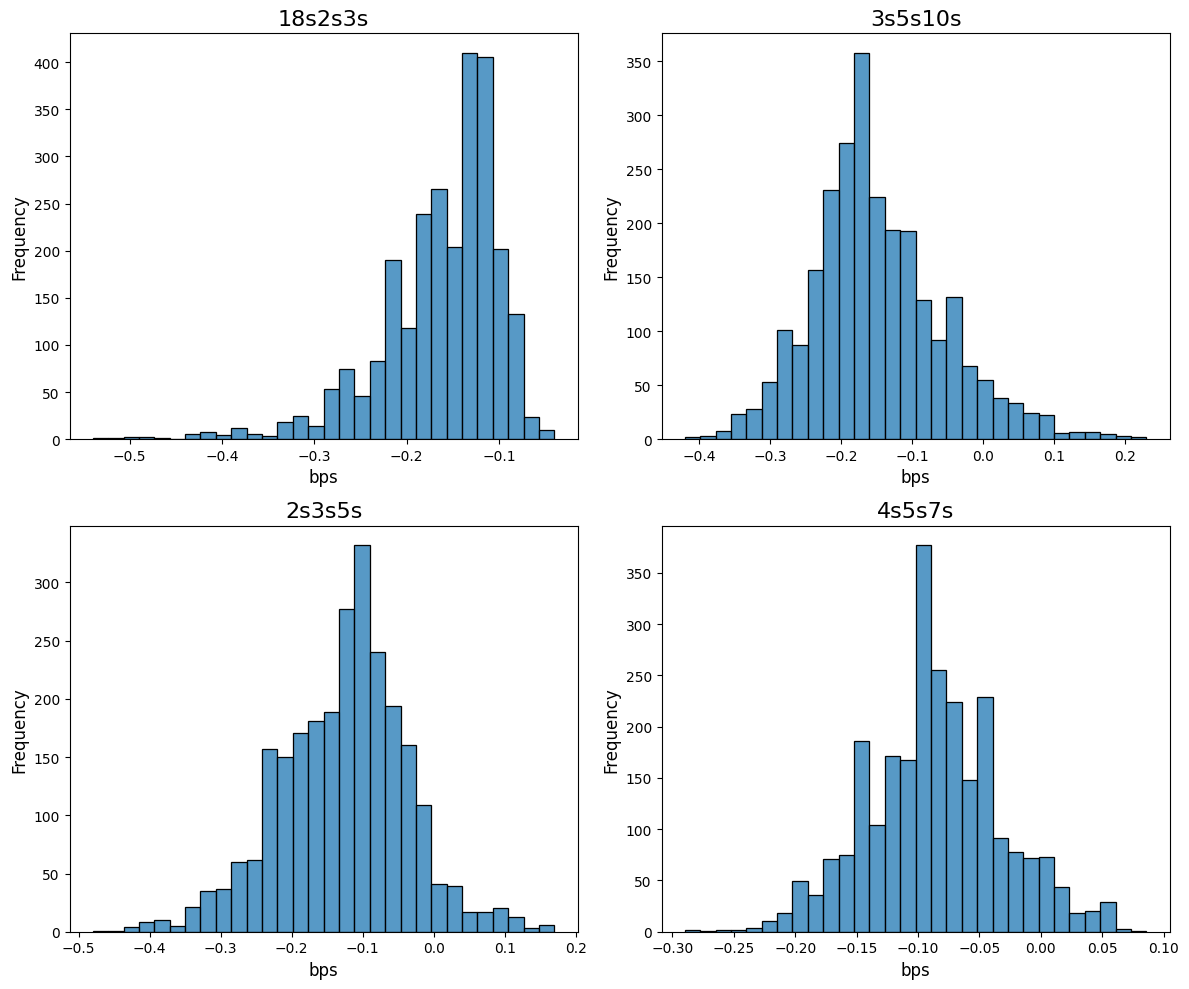

Mean:  -0.164584375 18s2s3s
Mean:  -0.14770820312500002 3s5s10s
Mean:  -0.126621484375 2s3s5s
Mean:  -0.08584101562499999 4s5s7s


In [44]:

#Histogram of Benchmark Flies.

factors = ['18s2s3s', '3s5s10s', '2s3s5s', '4s5s7s']
factors2 = ['18s2s3s', '3s5s10s', '2s3s5s', '4s5s7s']
start_date,end_date = ['2010-03-09','2019-12-30']
fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 
axes = axes.flatten()
for i, factor in enumerate(factors):
    sns.histplot(df_cam.loc[start_date:end_date, factor].dropna().values, ax=axes[i], bins=30)
    axes[i].set_title(factors2[i], fontsize=16) 
    axes[i].set_xlabel("bps",fontsize=12)
    axes[i].set_ylabel("Frequency",fontsize=12)
plt.tight_layout()
plt.show()
for i in factors:
    print("Mean: ",df_cam.loc[start_date:end_date,i].mean(),i)
#print("Last observations#:",datapoints)

In [ ]:
plt.hist(df_cam.loc[df_cam['5y2y-4y1y'] >.75, ['2s5s']])
plt.show()

In [ ]:
df_cam.loc[start_date:end_date, '4s5s7s'>.5]

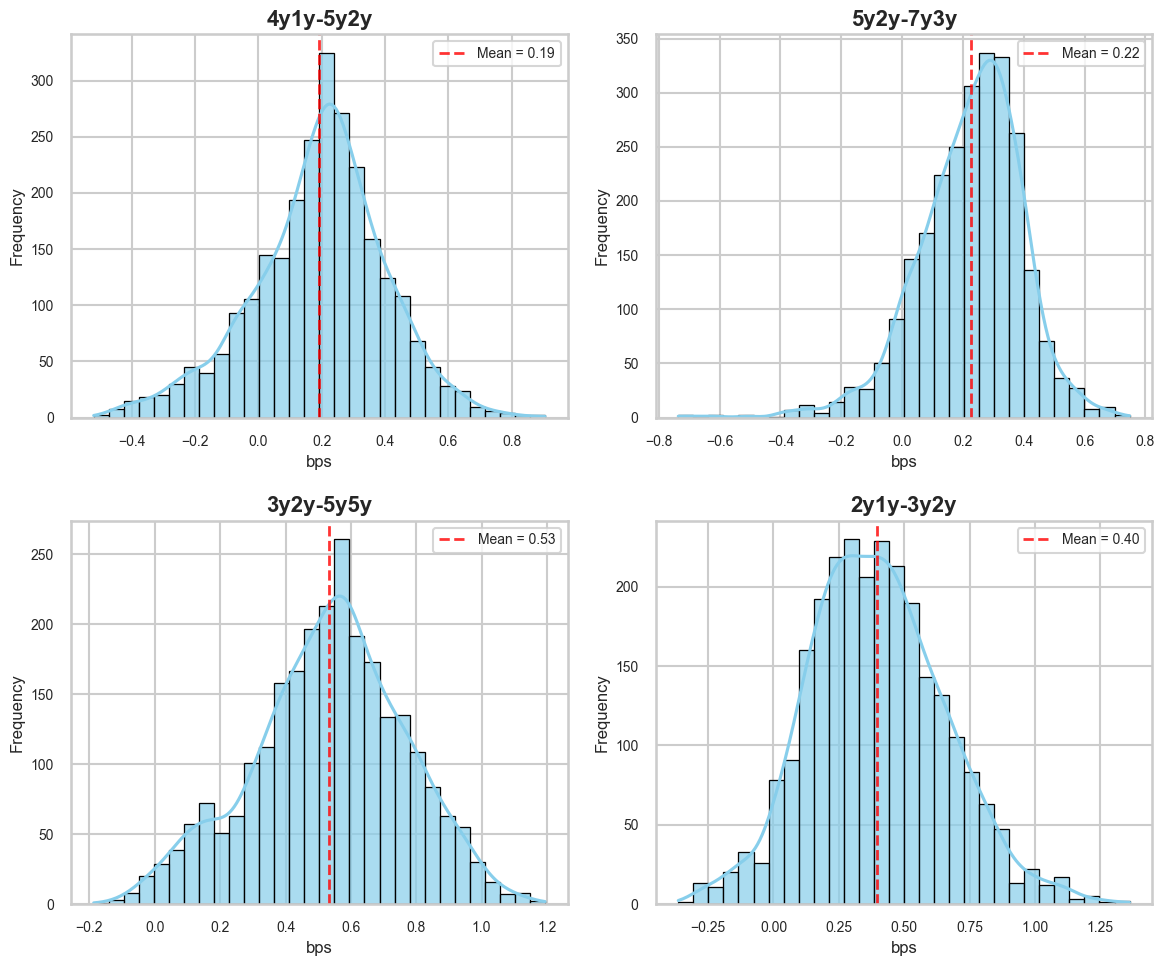

Mean of 5y2y-4y1y: 0.19186914062500002
Mean of 7y3y-5y2y: 0.224959375
Mean of 5y5y-3y2y: 0.5338968749999999
Mean of 3y2y-2y1y: 0.39526796875


In [45]:
# FRA spread histgrams with median
factors = ['5y2y-4y1y', '7y3y-5y2y', '5y5y-3y2y', '3y2y-2y1y']
factors2 = ['4y1y-5y2y', '5y2y-7y3y', '3y2y-5y5y', '2y1y-3y2y']
#factors = ['9m3m-6m3m', '1y6m-9m3m', '18m6m-1y6m', '2y1y-18m6m']
#factors2 = ['6m3m-9m3m', '9m3m-1y6m', '1y6m-18m6m', '18m6m-2y1y']
# Define date range
start_date, end_date = ['2010-03-09', '2019-12-30']

# Optional: Enhance overall plot aesthetics
sns.set_style("whitegrid")     # Background grid style
sns.set_context("talk")        # Larger fonts; use "notebook" or "paper" if you prefer smaller

# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, factor in enumerate(factors):
    data_series = df_cam.loc[start_date:end_date, factor].dropna()
    
    # Plot histogram with optional KDE overlay
    sns.histplot(
        data_series,
        bins=30,
        ax=axes[i],
        kde=True,               # Enable KDE overlay
        color="skyblue",        # Histogram bar color
        edgecolor="black",      # Bar edge color
        alpha=0.7               # Transparency
    )
    
    # Calculate mean for annotation
    mean_val = data_series.mean()
    
    # Draw a vertical line for the mean
    axes[i].axvline(
        mean_val,
        color="red",
        linestyle="--",
        linewidth=2,
        alpha=0.8,
        label=f"Mean = {mean_val:.2f}"
    )
    
    # Axes titles and labels
    axes[i].set_title(factors2[i], fontsize=16, fontweight='bold')
    axes[i].set_xlabel("bps", fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)
    
    # Customize ticks
    axes[i].tick_params(axis='both', which='major', labelsize=10)
    
    # Show legend for the mean line
    axes[i].legend(fontsize=10, loc="upper right")

plt.tight_layout()
plt.show()

# Print the mean of each factor
for factor in factors:
    factor_mean = df_cam.loc[start_date:end_date, factor].mean()
    print(f"Mean of {factor}: {factor_mean}")

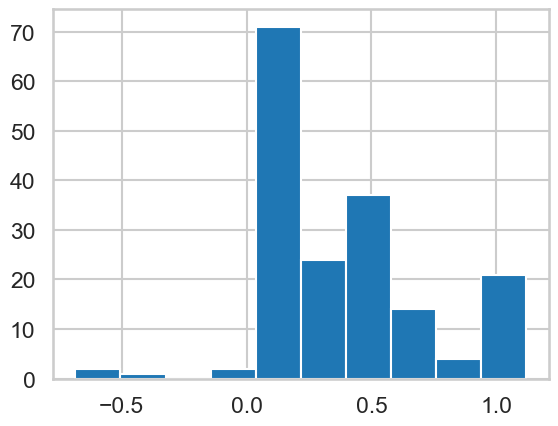

In [63]:
start_date,end_date = ['2010-03-09','2024-12-06']
filtered_data = df_cam.loc[start_date:end_date]
plt.hist(filtered_data.loc[filtered_data['3s5s10s'] >0, ['5s10s']])
plt.show()
filtered_data=[]

In [175]:
# Test FRA spreads for co integration
columns = ['3m','3m3m','6m3m','9m3m','1y6m','18m6m','1y1y','2y1y','3y1y','4y1y','2y2y','3y2y','5y2y','7y3y','5y5y']
df_fras_200_SMA = df_cam[columns].rolling(window=200).mean().dropna()
df_fras_normalized = (df_cam[columns].loc[df_fras_200_SMA.index,:]/df_fras_200_SMA.dropna())

In [176]:
import itertools
# Define the selected spreads for pairwise testing
selected_spreads = ['2y1y', '3y2y', '4y1y', '5y2y', '7y3y', '2y2y', '5y5y']

# Generate all possible pairs from the selected spreads
selected_pairs = list(itertools.combinations(selected_spreads, 2))

# Engle-Granger Cointegration Test for selected pairs
# Receives  dataframe as df with swap data
# Receives columns of series as pairs to be used 
def test_selected_cointegration(df, pairs):
    results = {}
    for col1, col2 in pairs:
        if col1 in df.columns and col2 in df.columns:
            score, p_value, _ = coint(df[col1], df[col2])
            results[(col1, col2)] = {'Cointegration Score': score, 'P-Value': p_value}
    return pd.DataFrame(results).T

# Run the cointegration test for selected pairs
selected_cointegration_results = test_selected_cointegration(df_fras_normalized, selected_pairs)

# Print Results
print(selected_cointegration_results)

# Hurst Exponent Calculation
#H Value	Interpretation
#H < 0.5	Mean-reverting (Pairs likely to revert to a long-term equilibrium)
#H ≈ 0.5	Random Walk (No strong trend or mean reversion)
#H > 0.5	Trending (Pairs likely to continue moving in the same direction)
def hurst_exponent(ts):
    lags = range( 2,100)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    hurst = np.polyfit(np.log(lags), np.log(tau), 1)[0]
    return hurst

# Compute Hurst Exponent for selected pairs
hurst_results = {}
for col1, col2 in selected_pairs:
    spread = df_fras_normalized[col1] - df_fras_normalized[col2]
    hurst_results[(col1, col2)] = hurst_exponent(spread.dropna().values)

hurst_df = pd.DataFrame.from_dict(hurst_results, orient='index', columns=['Hurst Exponent'])

print(hurst_df)



           Cointegration Score       P-Value
2y1y 3y2y            -6.621214  6.634520e-08
     4y1y            -6.169496  6.933566e-07
     5y2y            -4.638922  7.174045e-04
     7y3y            -4.400083  1.778873e-03
     2y2y            -6.470881  1.466235e-07
     5y5y            -4.285519  2.696753e-03
3y2y 4y1y            -5.576661  1.254094e-05
     5y2y            -5.492055  1.859161e-05
     7y3y            -5.638505  9.374084e-06
     2y2y            -8.573206  1.069592e-12
     5y5y            -5.652714  8.764413e-06
4y1y 5y2y            -7.806252  9.227643e-11
     7y3y            -6.480037  1.397559e-07
     2y2y            -7.190776  2.994745e-09
     5y5y            -6.674248  5.002172e-08
5y2y 7y3y            -7.274299  1.880729e-09
     2y2y            -5.456453  2.190721e-05
     5y5y            -7.448627  7.068358e-10
7y3y 2y2y            -5.579814  1.235701e-05
     5y5y            -7.618610  2.697368e-10
2y2y 5y5y            -4.497026  1.238525e-03
          

In [177]:
import statsmodels.api as sm
from scipy.stats import t
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
    
# Half-life Calculation
def half_life(spread):
    spread = spread.dropna()
    spread_lag = spread.shift(1).dropna()
    delta_spread = (spread - spread_lag).dropna()
    
    # Align both series to have the same index
    common_index = spread_lag.index.intersection(delta_spread.index)
    spread_lag, delta_spread = spread_lag.loc[common_index], delta_spread.loc[common_index]
    
    if len(delta_spread) < 2:
        return np.nan  # Not enough data for regression
    try:
        beta = sm.OLS(delta_spread.values, sm.add_constant(spread_lag.values)).fit().params[1]
        return -np.log(2) / beta if abs(beta) > 1e-6 else np.nan  # Avoid division by zero
    except Exception:
        return np.nan  # Return NaN in case of any regression failure

# Compute Half-Life for selected pairs
half_life_results = {}
for col1, col2 in selected_pairs:
    spread = df_fras_normalized[col1] - df_fras_normalized[col2] #here We calculate spread
    half_life_results[(col1, col2)] = half_life(spread)

half_life_df = pd.DataFrame.from_dict(half_life_results, orient='index', columns=['Half-Life'])

# Display results
print(half_life_df)



               Half-Life
(2y1y, 3y2y)   47.958950
(2y1y, 4y1y)   53.809762
(2y1y, 5y2y)  103.054860
(2y1y, 7y3y)  114.636563
(2y1y, 2y2y)   21.240918
(2y1y, 5y5y)  128.569370
(3y2y, 4y1y)   12.362168
(3y2y, 5y2y)   29.858183
(3y2y, 7y3y)   51.432356
(3y2y, 2y2y)   54.286597
(3y2y, 5y5y)   53.434904
(4y1y, 5y2y)   10.463125
(4y1y, 7y3y)   23.145273
(4y1y, 2y2y)   36.035211
(4y1y, 5y5y)   19.471228
(5y2y, 7y3y)    9.924993
(5y2y, 2y2y)   94.352885
(5y2y, 5y5y)   10.153741
(7y3y, 2y2y)  111.067760
(7y3y, 5y5y)    9.615670
(2y2y, 5y5y)  132.901904


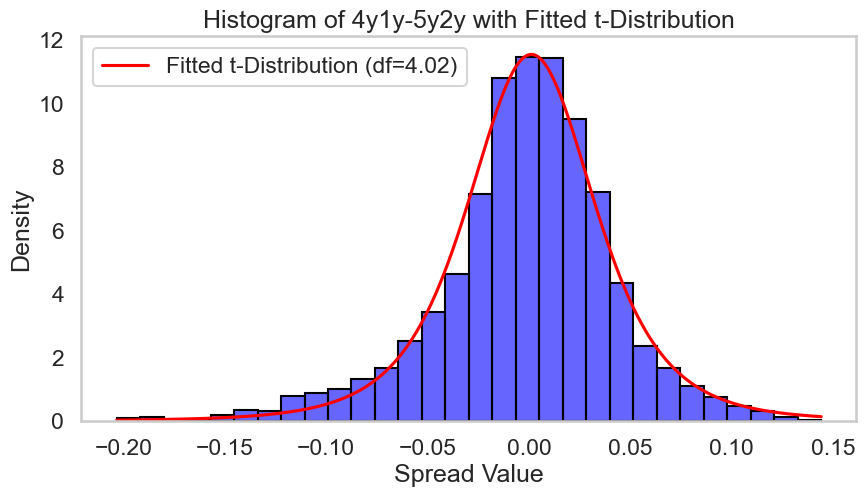

In [156]:
# Generate t fitted distribution for normalied sprread and plot histogram
df_fra_spreads_normalized = pd.DataFrame(index=df_fras_normalized.index)
spread_pairs = list(itertools.combinations(selected_spreads, 2))
for col1, col2 in spread_pairs:
    if col1[0:1] > col2[0:1]:
        df_fra_spreads_normalized[f"{col2}-{col1}"] = df_fras_normalized[col1] - df_fras_normalized[col2]
    else:
        df_fra_spreads_normalized[f"{col1}-{col2}"] = df_fras_normalized[col2] - df_fras_normalized[col1]
        
# Drop NaN values resulting from the rolling mean calculation
df_fra_spreads_normalized.dropna(inplace=True)

# Fit t-distributions to each spread
t_params = {}
for spread in df_fra_spreads_normalized.columns:
    t_params[spread] = t.fit(df_fra_spreads_normalized[spread].dropna())

# Select a spread to plot
spread_name = "4y1y-5y2y"  # Change this to any available spread
spread_data = df_fra_spreads_normalized[spread_name].dropna()

# Retrieve the fitted t-distribution parameters
df_t, loc_t, scale_t = t_params[spread_name]

# Generate fitted values
x = np.linspace(min(spread_data), max(spread_data), 1000)
y = t.pdf(x, df_t, loc=loc_t, scale=scale_t)

# Plot histogram and fitted t-distribution
plt.figure(figsize=(10, 5))
sns.histplot(spread_data, bins=30, kde=False, stat="density", color='blue', alpha=0.6, edgecolor='black')
plt.plot(x, y, 'r-', label=f'Fitted t-Distribution (df={df_t:.2f})')
plt.xlabel("Spread Value")
plt.ylabel("Density")
plt.title(f"Histogram of {spread_name} with Fitted t-Distribution")
plt.legend()
plt.grid()
plt.show()



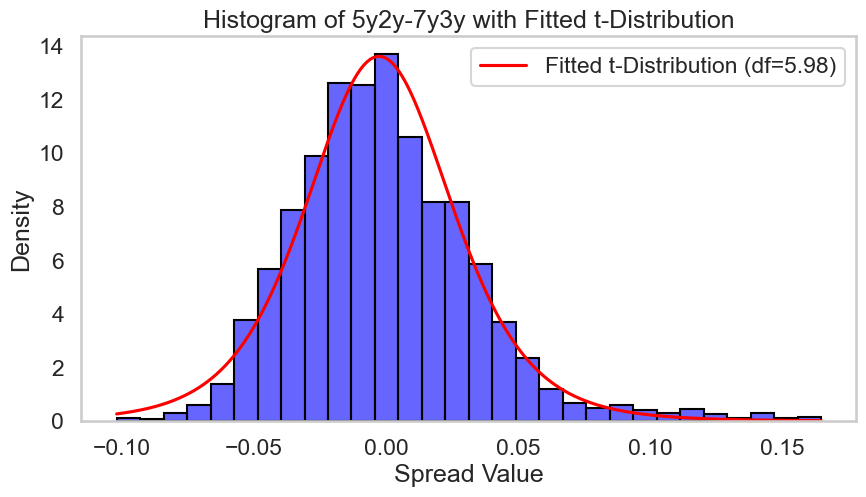

In [135]:
# Select a spread to plot
spread_name = "5y2y-7y3y"  # Change this to any available spread
spread_data = df_fra_spreads_normalized[spread_name].dropna()

# Retrieve the fitted t-distribution parameters
df_t, loc_t, scale_t = t_params[spread_name]

# Generate fitted values
x = np.linspace(min(spread_data), max(spread_data), 1000)
y = t.pdf(x, df_t, loc=loc_t, scale=scale_t)

# Plot histogram and fitted t-distribution
plt.figure(figsize=(10, 5))
sns.histplot(spread_data, bins=30, kde=False, stat="density", color='blue', alpha=0.6, edgecolor='black')
plt.plot(x, y, 'r-', label=f'Fitted t-Distribution (df={df_t:.2f})')
plt.xlabel("Spread Value")
plt.ylabel("Density")
plt.title(f"Histogram of {spread_name} with Fitted t-Distribution")
plt.legend()
plt.grid()
plt.show()

2y1y-3y2y  2y1y-4y1y  2y1y-5y2y  2y1y-7y3y  2y1y-2y2y  2y1y-5y5y  \
Date                                                                           
2010-12-13   0.000034   0.029209  -0.034853  -0.067641  -0.013901  -0.053311   
2010-12-14  -0.003848   0.010345  -0.039240  -0.071816  -0.008599  -0.057614   
2010-12-15  -0.010661  -0.006843  -0.067605  -0.087094  -0.007233  -0.078474   
2010-12-16  -0.014184  -0.009404  -0.063957  -0.089180  -0.009369  -0.078108   
2010-12-17  -0.011457  -0.015238  -0.068205  -0.101608  -0.004313  -0.087002   
...               ...        ...        ...        ...        ...        ...   
2024-12-02   0.005423   0.012455   0.011540  -0.002149  -0.000668   0.003701   
2024-12-03   0.005785   0.011138   0.017722  -0.001710   0.000390   0.006450   
2024-12-04   0.003227   0.005687   0.008899  -0.004255   0.000421   0.001239   
2024-12-05  -0.002072  -0.002207   0.005477  -0.008422  -0.000969  -0.002670   
2024-12-06  -0.000952   0.004618   0.006825  -0.017116  -0.003181  -0.006921   

            3y2y-4y1y  3y2y-5y2y  3y2y-7y3y  2y2y-3y2y  ...  4y1y-5y2y  \
Date                                                    ...              
2010-12-13   0.029175  -0.034887  -0.067675   0.013935  ...  -0.064062   
2010-12-14   0.014192  -0.035392  -0.067968   0.004752  ...  -0.049584   
2010-12-15   0.003818  -0.056945  -0.076433  -0.003428  ...  -0.060763   
2010-12-16   0.004780  -0.049773  -0.074995  -0.004816  ...  -0.054553   
2010-12-17  -0.003780  -0.056748  -0.090151  -0.007144  ...  -0.052967   
...               ...        ...        ...        ...  ...        ...   
2024-12-02   0.007032   0.006118  -0.007572   0.006091  ...  -0.000915   
2024-12-03   0.005353   0.011937  -0.007495   0.005395  ...   0.006584   
2024-12-04   0.002460   0.005672  -0.007482   0.002806  ...   0.003212   
2024-12-05  -0.000136   0.007549  -0.006351  -0.001103  ...   0.007684   
2024-12-06   0.005571   0.007777  -0.016163   0.002229  ...   0.002207   

            4y1y-7y3y  2y2y-4y1y  4y1y-5y5y  5y2y-7y3y  2y2y-5y2y  5y2y-5y5y  \
Date                                                                           
2010-12-13  -0.096850   0.043110  -0.082519  -0.032788  -0.020952  -0.018457   
2010-12-14  -0.082160   0.018944  -0.067959  -0.032576  -0.030640  -0.018375   
2010-12-15  -0.080251   0.000390  -0.071631  -0.019488  -0.060373  -0.010868   
2010-12-16  -0.079775  -0.000036  -0.068704  -0.025222  -0.054589  -0.014151   
2010-12-17  -0.086371  -0.010924  -0.071764  -0.033403  -0.063892  -0.018797   
...               ...        ...        ...        ...        ...        ...   
2024-12-02  -0.014604   0.013123  -0.008754  -0.013690   0.012209  -0.007839   
2024-12-03  -0.012848   0.010748  -0.004687  -0.019432   0.017332  -0.011271   
2024-12-04  -0.009941   0.005266  -0.004447  -0.013154   0.008478  -0.007659   
2024-12-05  -0.006215  -0.001239  -0.000462  -0.013899   0.006446  -0.008147   
2024-12-06  -0.021734   0.007800  -0.011540  -0.023941   0.010006  -0.013746   

            2y2y-7y3y  5y5y-7y3y  2y2y-5y5y  
Date                                         
2010-12-13  -0.053740  -0.014330  -0.039409  
2010-12-14  -0.063216  -0.014201  -0.049015  
2010-12-15  -0.079861  -0.008620  -0.071241  
2010-12-16  -0.079811  -0.011071  -0.068740  
2010-12-17  -0.097295  -0.014607  -0.082688  
...               ...        ...        ...  
2024-12-02  -0.001481  -0.005850   0.004369  
2024-12-03  -0.002100  -0.008160   0.006060  
2024-12-04  -0.004676  -0.005494   0.000819  
2024-12-05  -0.007454  -0.005753  -0.001701  
2024-12-06  -0.013934  -0.010194  -0.003740  

[3644 rows x 21 columns]

In [76]:


selected_spreads =  ['2y1y', '3y2y', '4y1y', '5y2y', '7y3y', '2y2y', '5y5y']


# Compute FRA Spreads from normalized FRA values
df_spreads = pd.DataFrame(index=df_fras_normalized.index)
spread_pairs = list(itertools.combinations(selected_spreads, 2))
for col1, col2 in spread_pairs:
    df_spreads[f"{col1}-{col2}"] = df_fras_normalized[col1] - df_fras_normalized[col2]  # Compute spreads directly

# Drop NaN values resulting from the rolling mean calculation
df_spreads.dropna(inplace=True)

# Prepare Data for LSTM Model
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_spreads.values)

# Create sequences for LSTM
sequence_length = 50  # Number of past days to use for prediction
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(y_train.shape[1])
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Train Model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Make Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Display predictions
print(predictions[:5])


Epoch 1/50


C:\Users\Sebas\.conda\envs\CAMQUANT\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0863 - val_loss: 0.0045
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0135 - val_loss: 0.0041
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0098 - val_loss: 0.0035
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0077 - val_loss: 0.0031
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0066 - val_loss: 0.0029
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0059 - val_loss: 0.0028
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0054 - val_loss: 0.0028
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0049 - val_loss: 0.0024
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 10/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 11/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 12/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0037 - val_l

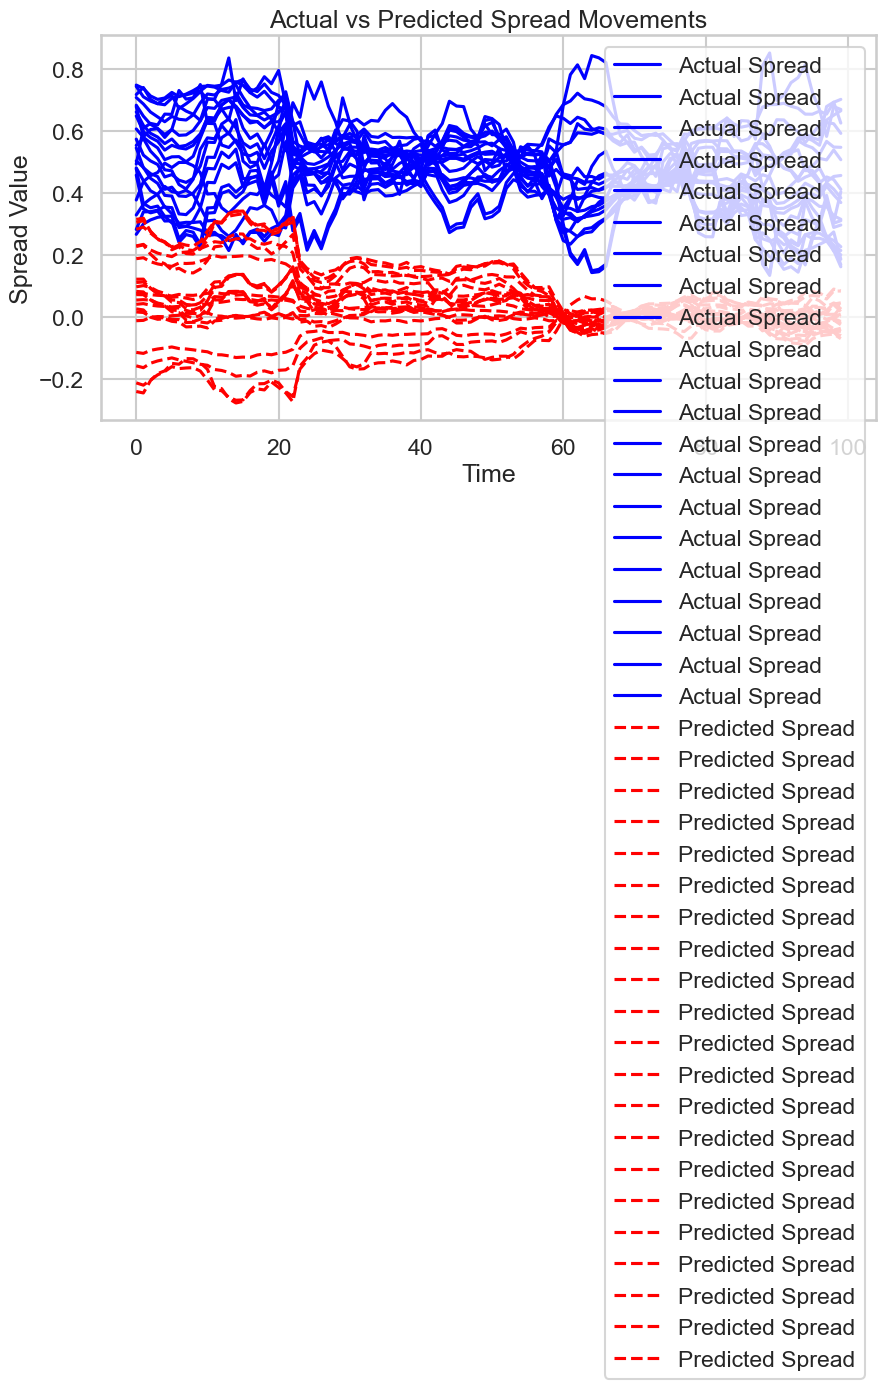

In [77]:

plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label="Actual Spread", color='blue')
plt.plot(predictions[:100], label="Predicted Spread", color='red', linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Spread Value")
plt.title("Actual vs Predicted Spread Movements")
plt.legend()
plt.show()

In [75]:
df_fras_normalized[selected_spreads]

2y1y      3y2y      4y1y      5y2y      7y3y      2y2y  \
Date                                                                     
2010-12-13  1.028600  1.028634  1.057809  0.993747  0.960959  1.014699   
2010-12-14  1.039536  1.035689  1.049881  1.000297  0.967721  1.030937   
2010-12-15  1.058031  1.047371  1.051189  0.990426  0.970938  1.050799   
2010-12-16  1.063469  1.049285  1.054065  0.999512  0.974290  1.054101   
2010-12-17  1.062167  1.050710  1.046930  0.993962  0.960559  1.057854   
...              ...       ...       ...       ...       ...       ...   
2024-12-02  0.995287  1.000710  1.007742  1.006828  0.993138  0.994619   
2024-12-03  1.000561  1.006346  1.011699  1.018283  0.998851  1.000951   
2024-12-04  1.001540  1.004767  1.007227  1.010439  0.997286  1.001961   
2024-12-05  1.010082  1.008011  1.007875  1.015559  1.001660  1.009114   
2024-12-06  1.010397  1.009445  1.015016  1.017222  0.993282  1.007216   

                5y5y  
Date                  
2010-12-13  0.975289  
2010-12-14  0.981922  
2010-12-15  0.979558  
2010-12-16  0.985361  
2010-12-17  0.975165  
...              ...  
2024-12-02  0.998988  
2024-12-03  1.007011  
2024-12-04  1.002780  
2024-12-05  1.007413  
2024-12-06  1.003476  

[3644 rows x 7 columns]

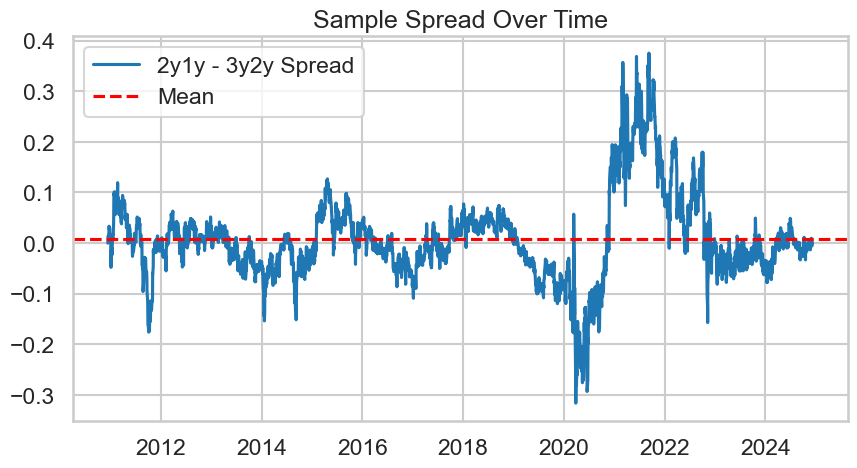

Testing half-life on 500 points
nan


Date
2010-12-13   -0.000034
2010-12-14    0.003848
2010-12-15    0.010661
2010-12-16    0.014184
2010-12-17    0.011457
2010-12-20    0.016766
2010-12-21    0.028218
2010-12-22    0.033403
2010-12-23    0.028801
2010-12-24    0.026754
dtype: float64

array([ 47.95895036,  53.80976205, 103.05485971, 114.63656325,
        21.24091806, 128.56937004,  12.36216792,  29.85818337,
        51.43235625,  54.28659749,  53.43490386,  10.46312538,
        23.14527346,  36.03521146,  19.47122779,   9.92499349,
        94.35288455,  10.15374064, 111.06776014,   9.61567013,
       132.90190378])

In [84]:
selected_cointegration_results.index.name

'Pairs'

In [85]:
print(selected_cointegration_results)

           Cointegration Score       P-Value
2y1y 3y2y            -6.621214  6.634520e-08
     4y1y            -6.169496  6.933566e-07
     5y2y            -4.638922  7.174045e-04
     7y3y            -4.400083  1.778873e-03
     2y2y            -6.470881  1.466235e-07
     5y5y            -4.285519  2.696753e-03
3y2y 4y1y            -5.576661  1.254094e-05
     5y2y            -5.492055  1.859161e-05
     7y3y            -5.638505  9.374084e-06
     2y2y            -8.573206  1.069592e-12
     5y5y            -5.652714  8.764413e-06
4y1y 5y2y            -7.806252  9.227643e-11
     7y3y            -6.480037  1.397559e-07
     2y2y            -7.190776  2.994745e-09
     5y5y            -6.674248  5.002172e-08
5y2y 7y3y            -7.274299  1.880729e-09
     2y2y            -5.456453  2.190721e-05
     5y5y            -7.448627  7.068358e-10
7y3y 2y2y            -5.579814  1.235701e-05
     5y5y            -7.618610  2.697368e-10
2y2y 5y5y            -4.497026  1.238525e-03


In [120]:
from nolds import hurst_rs



def hurst_exponent_python(ts):
    return hurst_rs(ts)

# Compute Hurst Exponent for selected pairs
hurst_results = {}

spread = df_fras_normalized['3y2y'] - df_fras_normalized['2y1y']
hurst_exponent(spread.dropna().values)

print("hurst_exponent_python ",hurst_exponent_python(spread.values))
print("hurst_exponent manual ",hurst_exponent(spread.dropna().values))


hurst_exponent_python  0.9036378643746561
hurst_exponent manual  0.3278462555571971


In [161]:
df_cam[columns].mean() 

3m       4.114182
3m3m     4.115841
6m3m     4.048607
9m3m     3.976754
1y6m     3.973383
18m6m    4.087725
1y1y     4.077233
2y1y     4.296495
3y1y     4.559890
4y1y     4.862428
2y2y     4.372492
3y2y     4.649709
5y2y     5.085480
7y3y     5.321634
5y5y     5.220001
dtype: float64

In [118]:
H, c, data = compute_Hc(spread.dropna().values, kind='random_walk', simplified=True)

In [119]:
H

np.float64(0.4348986573299078)